# Setup & Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype, is_datetime64_any_dtype, is_numeric_dtype
!pip install thefuzz
from thefuzz import fuzz
from scipy.stats import chi2_contingency
import re
from scipy.stats import f_oneway
import math
from matplotlib.ticker import MultipleLocator

# Helper function for plot styling
def clean_plot(ax, grid_on=False):
    """Removes top and right spines and optionally the grid for a cleaner plot."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not grid_on:
        ax.grid(False)

# Set a clean base style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10,
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.7 MB/s eta 0:00:00


# Core Classes for Data Processing and Analysis
# ---------------------------------------------------------------------------
- All classes are designed to be dataset-agnostic.
- Column names are passed as parameters to methods or during initialization.

## Class: DataLoader

In [ ]:
class DataLoader:
    """Handles loading data from a CSV file via URL."""
    def __init__(self, csv_url, separator=','):
        """Initializes the DataLoader."""
        self.csv_url = csv_url
        self.separator = separator
        self.df = None

    def load_data(self):
        """Loads the CSV data from the initialized URL."""
        print(f"Attempting to load data from URL: {self.csv_url}")
        try:
            self.df = pd.read_csv(self.csv_url, sep=self.separator)
            print(f"Data loaded successfully. Shape: {self.df.shape}")
        except Exception as e:
            print(f"An error occurred while loading the data: {e}")
            self.df = pd.DataFrame()
        return self.df

## Class: DataCleaner

In [ ]:
class DataCleaner:
    """Handles data cleaning, type conversion, and project-specific filtering."""
    def __init__(self, df):
        self.df = df.copy()

    def clean_column_names(self):
        """Standardizes all column names to lowercase with underscores."""
        self.df.columns = [
            col.lower().replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '')
            for col in self.df.columns
        ]
        print("Column names cleaned and standardized.")
        return self.df

    def check_missing_values(self):
        """Checks and displays the count and percentage of missing values for each column."""
        if self.df.empty:
            print("DataFrame is empty. Cannot check for missing values.")
            return pd.DataFrame()

        print("\n--- Missing Values Check ---")
        missing_info = pd.DataFrame({
            'Missing Count': self.df.isnull().sum(),
            'Missing Percentage': (self.df.isnull().sum() / len(self.df)) * 100
        })
        missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)

        if missing_info.empty:
            print("No missing values found.")
        else:
            print(missing_info)
        print("--- End of Missing Values Check ---")
        return missing_info

    def convert_data_types(self, column_dtype_map):
        """Converts columns to specified data types based on a provided map."""
        print("\n--- Applying Data Type Conversions ---")
        for col, dtype_to_convert in column_dtype_map.items():
            if col in self.df.columns:
                try:
                    if 'datetime' in str(dtype_to_convert):
                        self.df[col] = pd.to_datetime(self.df[col], errors='coerce')
                    else:
                        self.df[col] = self.df[col].astype(dtype_to_convert)
                    print(f"Converted column '{col}' to {self.df[col].dtype}.")
                except Exception as e:
                    print(f"Could not convert '{col}' to {dtype_to_convert}. Error: {e}")
        return self.df

    def filter_by_values(self, column, values, keep=True):
        """
        Filters the DataFrame based on values in a specified column.

        Args:
            column (str): The column to filter on.
            values (list): The list of values to filter by.
            keep (bool): If True, keeps rows with values in the list.
                         If False, removes them.
        """
        if column not in self.df.columns:
            print(f"Warning: Column '{column}' not found for filtering.")
            return self.df

        original_rows = len(self.df)
        if keep:
            self.df = self.df[self.df[column].isin(values)]
            action_str = "Kept"
        else:
            self.df = self.df[~self.df[column].isin(values)]
            action_str = "Removed"

        rows_after_filter = len(self.df)
        print(f"Filtered '{column}': {action_str} rows where value is in {values}. Kept {rows_after_filter} of {original_rows} rows.")
        return self.df

    def display_value_counts(self, top_n=15):
            """Displays value counts for all columns, summarizing if cardinality is high."""
            print("\n--- Displaying Value Counts for All Columns ---")
            for column in self.df.columns:
                print(f"\n--- Value Counts for '{column}' (Dtype: {self.df[column].dtype}) ---")
                counts = self.df[column].value_counts(dropna=False)
                num_unique = len(counts)
                print(f"  Number of Unique Values: {num_unique}")

                if num_unique == 0:
                    print("  Column is empty.")
                elif num_unique <= top_n:
                    print("  Value Counts (all):")
                    print(counts.to_string())
                else:
                    print(f"  Value Counts (Top {top_n} of {num_unique}):")
                    print(counts.head(top_n).to_string())
                print("-" * 60)

    def get_cleaned_df(self):
        """Returns the processed DataFrame."""
        return self.df

## Class: FeatureEngineer

In [ ]:
class FeatureEngineer:
    """Handles creation of new features from existing ones."""
    def __init__(self, df):
        self.df = df.copy()

    def create_feature_from_date_diff(self, start_date_col, end_date_col, new_col_name, unit='D'):
        """Creates a feature from the difference between two date columns."""
        if start_date_col not in self.df.columns or end_date_col not in self.df.columns:
            print(f"Warning: Date columns ('{start_date_col}' or '{end_date_col}') not found."); return self.df

        # Ensure columns are datetime
        self.df[start_date_col] = pd.to_datetime(self.df[start_date_col], errors='coerce')
        self.df[end_date_col] = pd.to_datetime(self.df[end_date_col], errors='coerce')

        # Calculate difference in days
        time_delta = (self.df[end_date_col] - self.df[start_date_col])
        if pd.api.types.is_timedelta64_dtype(time_delta.dtype):
            days = time_delta.dt.days
            if unit == 'Y':
                self.df[new_col_name] = round(days / 365.25, 1)
            elif unit == 'M':
                self.df[new_col_name] = round(days / (365.25 / 12), 1)
            else: # Default to days
                self.df[new_col_name] = days
            print(f"Feature '{new_col_name}' created in units '{unit}'.")
        else:
             print(f"Could not calculate timedelta for '{new_col_name}'.")

        # Handle negative values if they arise from data quality issues
        if is_numeric_dtype(self.df[new_col_name]) and (self.df[new_col_name] < 0).any():
             print(f"Warning: Negative values found in '{new_col_name}'. Setting to 0.")
             self.df.loc[self.df[new_col_name] < 0, new_col_name] = 0
        return self.df

    def create_binary_flag_from_null(self, source_col, new_col_name):
        """Creates a binary feature (1/0) indicating if the source column is null."""
        if source_col not in self.df.columns:
            print(f"Warning: Column '{source_col}' not found for creating binary flag."); return self.df

        self.df[new_col_name] = self.df[source_col].notna().astype(int)
        print(f"Feature '{new_col_name}' created from '{source_col}'.")
        return self.df

    def create_binary_flag_from_value(self, source_col, positive_value, new_col_name):
        """Creates a binary flag (1/0) based on a value in the source column."""
        if source_col not in self.df.columns:
            print(f"Warning: Column '{source_col}' not found."); return self.df

        self.df[new_col_name] = (self.df[source_col] == positive_value).astype(int)
        print(f"Feature '{new_col_name}' created (1 if {source_col} is '{positive_value}', 0 otherwise).")
        return self.df

    def extract_datetime_features(self, date_col, prefix=None):
        """Extracts month, year, and dayofweek from a datetime column."""
        if date_col not in self.df.columns or not is_datetime64_any_dtype(self.df[date_col]):
            print(f"Warning: Datetime column '{date_col}' not found or not in datetime format."); return self.df

        col_prefix = prefix if prefix else date_col.replace('_date', '').replace('_datetime', '')
        self.df[f'{col_prefix}_month'] = self.df[date_col].dt.month
        self.df[f'{col_prefix}_year'] = self.df[date_col].dt.year
        self.df[f'{col_prefix}_dayofweek'] = self.df[date_col].dt.dayofweek
        print(f"Datetime features extracted from '{date_col}' with prefix '{col_prefix}_'.")
        return self.df

    def convert_days_to_unit(self, days_col, new_col_name, unit='Y'):
        """
        Converts a column of days into another unit (Years or Months).

        Args:
            days_col (str): The name of the source column containing day counts.
            new_col_name (str): The name of the new column to create.
            unit (str): The target unit, 'Y' for years or 'M' for months.
        """
        if days_col not in self.df.columns:
            print(f"Warning: Column '{days_col}' not found for unit conversion.")
            return self.df

        if unit.upper() == 'Y':
            self.df[new_col_name] = round(self.df[days_col] / 365.25, 1)
        elif unit.upper() == 'M':
            # Using an average of 30.44 days per month (365.25 / 12)
            self.df[new_col_name] = round(self.df[days_col] / (365.25 / 12), 1)
        else:
            print(f"Unsupported unit '{unit}'. Please use 'Y' for years or 'M' for months.")
            return self.df

        print(f"Feature '{new_col_name}' created from '{days_col}' in units '{unit}'.")
        return self.df

    def _parse_single_text_age(self, age_str):
        """(Private) Helper function to parse a single age string into years as a float."""
        if pd.isna(age_str) or not isinstance(age_str, str):
            return np.nan

        # Standardize the string: lowercase, remove periods and plurals for easier matching
        age_str_lower = age_str.lower().replace('.', '').replace('s', '')

        years = 0
        months = 0
        days = 0 # Added for robustness in case 'day' appears

        # Use regex to find numbers associated with year, month, and day
        year_match = re.search(r'(\d+)\s*year', age_str_lower)
        if year_match:
            years = int(year_match.group(1))

        month_match = re.search(r'(\d+)\s*month', age_str_lower)
        if month_match:
            months = int(month_match.group(1))

        day_match = re.search(r'(\d+)\s*day', age_str_lower)
        if day_match:
            days = int(day_match.group(1))

        # Calculate total years as a float
        total_years = years + (months / 12.0) + (days / 365.25)

        # Return the result rounded to one decimal place, or NaN if no age info was found
        return round(total_years, 1) if total_years > 0 else np.nan

    def parse_text_age_to_years(self, text_age_col, new_col_name_years):
        """
        Parses a text-based age column (e.g., '5 years 2 months.') and converts
        it into a numerical column of years as a float.
        """
        if text_age_col not in self.df.columns:
            print(f"Warning: Age column '{text_age_col}' not found for parsing.")
            return self.df

        self.df[new_col_name_years] = self.df[text_age_col].apply(self._parse_single_text_age)
        print(f"Feature '{new_col_name_years}' created by parsing '{text_age_col}'.")
        return self.df

    def get_engineered_df(self):
        """Returns the processed DataFrame."""
        return self.df

## Class: ExploratoryDataAnalyzer

In [ ]:
class ExploratoryDataAnalyzer:
    """Handles a wide range of EDA tasks with consistent, clean visualizations."""
    def __init__(self, df):
        self.df = df.copy()
        self.default_color = '#4285f4'
        self.deemphasis_color = 'lightgrey'

    # --- Univariate Analysis ---
    def display_summary_statistics(self):
        """
        Displays a comprehensive summary including quantile statistics for numerical
        columns and cardinality for all columns.
        """
        if self.df.empty:
            print("DataFrame is empty. Cannot display summary statistics.")
            return

        print("\n" + "="*80)
        print("--- Comprehensive Data Summary ---")
        print("="*80)

        # 1. Display descriptive statistics for all columns using .describe()
        print("\n--- Descriptive Statistics (Quantiles, Frequencies, etc.) ---")
        # For object/category columns, it shows count, unique, top, freq.
        # For numerical columns, it shows count, mean, std, min, 25%, 50%, 75%, max.
        print(self.df.describe(include='all').transpose())

        # 2. Display cardinality and data type for every column
        print("\n--- Column Cardinality (Unique Values) & Data Types ---")
        cardinality_df = pd.DataFrame({
            'Data Type': self.df.dtypes,
            'Unique Values': self.df.nunique(dropna=False) # includes NaN in the count
        }).sort_values(by='Unique Values', ascending=False)

        print(cardinality_df.to_string())
        print("\n" + "="*80)

    def plot_distribution(self, column, bins='auto', title_suffix="Distribution",
                          title_fontsize=15, axis_label_fontsize=12, tick_label_fontsize=10,
                          xlim=None, ax=None, xtick_interval=None):
        """Plots the distribution of a numerical column on a given axis."""
        if column not in self.df.columns or not pd.api.types.is_numeric_dtype(self.df[column]):
            return

        # If no axis is provided, create a new figure for a standalone plot
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))

        sns.histplot(self.df[column], bins=bins, kde=True, color=self.default_color, ax=ax)
        ax.set_title(f'{column.replace("_", " ").title()} {title_suffix}', fontsize=title_fontsize)
        ax.set_xlabel(column.replace("_", " ").title(), fontsize=axis_label_fontsize)
        ax.set_ylabel('Frequency', fontsize=axis_label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_label_fontsize)

        if xlim is not None and isinstance(xlim, tuple) and len(xlim) == 2:
            ax.set_xlim(xlim)

        # Set custom tick interval
        if xtick_interval is not None and (isinstance(xtick_interval, int) or isinstance(xtick_interval, float)):
            # Use MultipleLocator to set the ticks at regular intervals
            ax.xaxis.set_major_locator(MultipleLocator(xtick_interval))
            # When ticks are closer together, rotation can prevent overlap
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            print(f"Note: X-axis ticks for '{column}' set to intervals of {xtick_interval}.")

        if 'clean_plot' in globals():
            clean_plot(ax, grid_on=False)


    def plot_categorical_distribution(self, column, top_n=15, title_suffix="Distribution",
                                      title_fontsize=15, axis_label_fontsize=12, tick_label_fontsize=10,
                                      ax=None):
        """Plots the distribution of a categorical column on a given axis."""
        if column not in self.df.columns:
            return
        if not (isinstance(self.df[column].dtype, CategoricalDtype) or self.df[column].dtype == 'object'):
            return

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 7))

        original_counts = self.df[column].value_counts(dropna=False)
        categories_to_plot = original_counts
        plot_title = f'{column.replace("_", " ").title()} {title_suffix}'

        if len(original_counts) > top_n:
            categories_to_plot = original_counts.nlargest(top_n).copy()
            other_sum = original_counts.iloc[top_n:].sum()
            if other_sum > 0: categories_to_plot.loc['Other'] = other_sum
            plot_title = f'Top {top_n} {column.replace("_", " ").title()} {title_suffix} (Incl. Others)'

        plot_index_str = categories_to_plot.index.astype(str)
        sns.barplot(x=plot_index_str, y=categories_to_plot.values, color=self.default_color, order=plot_index_str, ax=ax)

        ax.set_title(plot_title, fontsize=title_fontsize)
        ax.set_xlabel(column.replace("_", " ").title(), fontsize=axis_label_fontsize)
        ax.set_ylabel('Count', fontsize=axis_label_fontsize)

        new_xticklabels = [f"{cat_name}\n(n={categories_to_plot.loc[cat_name]})" for cat_name in categories_to_plot.index]
        ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)
        ax.tick_params(axis='y', labelsize=tick_label_fontsize)

        if 'clean_plot' in globals():
            clean_plot(ax)

    # --- Bivariate and Multivariate Plotting ---
    def plot_correlation_heatmap(self, numeric_cols=None, title="Correlation Heatmap",
                                 title_fontsize=15, tick_label_fontsize=10, annot_fontsize=8):
        """Plots a correlation heatmap for numerical columns."""
        df_numeric = self.df.select_dtypes(include=np.number).copy() if numeric_cols is None else self.df[numeric_cols].copy()
        if df_numeric.empty: print("No numerical columns for correlation heatmap."); return
        df_numeric.dropna(axis=1, how='all', inplace=True)
        if df_numeric.empty: print("Numerical columns are all NaN. Cannot compute correlation."); return
        corr_matrix = df_numeric.corr()
        plt.figure(figsize=(max(8, len(df_numeric.columns)*0.8), max(6, len(df_numeric.columns)*0.6)))
        ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, annot_kws={"size": annot_fontsize})
        ax.set_title(title, fontsize=title_fontsize); plt.xticks(rotation=45, ha='right', fontsize=tick_label_fontsize)
        plt.yticks(rotation=0, fontsize=tick_label_fontsize); plt.tight_layout(); plt.show()


    def plot_feature_vs_outcome(self, feature_column, outcome_column, positive_outcome_value,
                                top_n_feature_categories=7, title_fontsize=15, axis_label_fontsize=12,
                                tick_label_fontsize=10, legend_fontsize=10, xtick_label_map=None,
                                figure_size=(11,12), deemphasize_if_rate_above_average=False,
                                show_descriptive_stats=False):
        """Plots a feature against a binary outcome (e.g., adoption rate by category)."""
        if feature_column not in self.df.columns: print(f"Feature column '{feature_column}' not found."); return
        if outcome_column not in self.df.columns: print(f"Outcome column '{outcome_column}' not found."); return
        temp_df = self.df[[feature_column, outcome_column]].copy()
        temp_df['is_adopted_binary'] = (temp_df[outcome_column] == positive_outcome_value).astype(int)
        plt.figure(figsize=figure_size)
        feature_title = feature_column.replace("_", " ").title()
        outcome_title_display = str(positive_outcome_value).replace("_", " ").title()
        ax = None; plot_title_text = f'{outcome_title_display} Rate by {feature_title}'
        if isinstance(temp_df[feature_column].dtype, CategoricalDtype) or temp_df[feature_column].dtype == 'object' or temp_df[feature_column].nunique() < 20:
            if temp_df[feature_column].isnull().any():
                if isinstance(temp_df[feature_column].dtype, CategoricalDtype):
                    if 'Unknown' not in temp_df[feature_column].cat.categories: temp_df[feature_column] = temp_df[feature_column].cat.add_categories(['Unknown'])
                temp_df[feature_column] = temp_df[feature_column].fillna('Unknown')
            all_category_adoption_rates = temp_df.groupby(feature_column)['is_adopted_binary'].mean()
            original_counts = temp_df[feature_column].value_counts(dropna=False)
            other_n_for_label = None; plot_data_rates = all_category_adoption_rates
            if len(original_counts) > top_n_feature_categories:
                categories_to_plot_individually_names = original_counts.nlargest(top_n_feature_categories).index
                plot_data_rates_dict = all_category_adoption_rates.reindex(categories_to_plot_individually_names).fillna(0).to_dict()
                other_category_names = original_counts.index[~original_counts.index.isin(categories_to_plot_individually_names)]
                if not other_category_names.empty:
                    other_df = temp_df[temp_df[feature_column].isin(other_category_names)]
                    if not other_df.empty:
                        other_rate_val = other_df['is_adopted_binary'].mean(); other_n_for_label = len(other_df)
                        if other_n_for_label > 0: plot_data_rates_dict['Other'] = other_rate_val
                plot_data_rates = pd.Series(plot_data_rates_dict)
                plot_title_text = f'{outcome_title_display} Rate by Top {top_n_feature_categories} {feature_title} (by Count)'
            plot_data_rates = plot_data_rates.sort_values(ascending=False)
            overall_rate = temp_df['is_adopted_binary'].mean()
            bar_palette = [self.deemphasis_color if deemphasize_if_rate_above_average and rate > overall_rate else self.default_color for rate in plot_data_rates]
            ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
            ax.set_ylim(0, 1.0)
            new_xticklabels = []
            for cat_name_obj in plot_data_rates.index:
                count = original_counts.get(cat_name_obj, 0)
                if str(cat_name_obj) == 'Other' and other_n_for_label is not None: count = other_n_for_label
                display_label = str(cat_name_obj)
                if xtick_label_map: display_label = xtick_label_map.get(cat_name_obj, xtick_label_map.get(str(cat_name_obj), str(cat_name_obj)))
                new_xticklabels.append(f"{display_label}\n(n={count})")
            ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)
            ax.tick_params(axis='y', labelsize=tick_label_fontsize)
            ax.axhline(overall_rate, color='dimgrey', linestyle='--', label=f'Overall Rate ({overall_rate:.2%})')
            ax.legend(loc='upper right', fontsize=legend_fontsize)
        elif is_numeric_dtype(temp_df[feature_column]):
            temp_df['is_adopted_binary_str'] = temp_df['is_adopted_binary'].astype(str)
            if show_descriptive_stats:
                stats_index_map = {'0': 'Other Outcomes (0)', '1': f'{outcome_title_display} (1)'}
                descriptive_stats = temp_df.groupby('is_adopted_binary_str')[feature_column].describe()
                print(f"\n--- Stats for '{feature_title}' by Adoption Status ---"); print(descriptive_stats.rename(index=stats_index_map)); print("-" * 70)
            boxplot_xtick_map = {'0': 'Other Outcomes', '1': outcome_title_display}
            if xtick_label_map: boxplot_xtick_map.update({k: v for k, v in xtick_label_map.items() if k in ['0', '1']})
            custom_palette_str_keys = {'0': self.deemphasis_color, '1': self.default_color}
            ax = sns.boxplot(x='is_adopted_binary_str', y=feature_column, data=temp_df, palette=custom_palette_str_keys)
            plot_title_text = f'{feature_title} Distribution by {outcome_title_display} Status'
            outcome_counts = temp_df['is_adopted_binary_str'].value_counts()
            xticklabels_with_counts = [f"{boxplot_xtick_map.get('0')}\n(n={outcome_counts.get('0',0)})", f"{boxplot_xtick_map.get('1')}\n(n={outcome_counts.get('1',0)})"]
            ax.set_xticklabels(xticklabels_with_counts, fontsize=tick_label_fontsize)
            ax.tick_params(axis='y', labelsize=tick_label_fontsize)
        else: print(f"Column '{feature_column}' has an unhandled data type."); return
        if ax is not None:
            ax.set_title(plot_title_text, fontsize=title_fontsize)
            is_cat_like = isinstance(temp_df[feature_column].dtype, CategoricalDtype) or temp_df[feature_column].dtype == 'object' or temp_df[feature_column].nunique() < 20
            ax.set_xlabel(feature_title if is_cat_like else f'{outcome_title_display} Status', fontsize=axis_label_fontsize)
            ax.set_ylabel(f'{outcome_title_display} Rate' if is_cat_like else feature_title, fontsize=axis_label_fontsize)
            if 'clean_plot' in globals(): clean_plot(ax)
            else: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(False)
            plt.tight_layout(); plt.show()


    def plot_bivariate_categorical(self, cat_col1, cat_col2, top_n_cat1=5, top_n_cat2=5, normalize=False,
                                   title_fontsize=15, axis_label_fontsize=12, tick_label_fontsize=10, legend_fontsize=10):
        """Plots relationship between two categorical variables using a grouped or stacked bar chart."""
        if cat_col1 not in self.df.columns or cat_col2 not in self.df.columns: print("One or both categorical columns not found."); return
        plt.figure(figsize=(12,8)); temp_df_cat = self.df[[cat_col1, cat_col2]].copy()
        temp_df_cat[cat_col1] = temp_df_cat[cat_col1].fillna('Unknown').astype(str)
        temp_df_cat[cat_col2] = temp_df_cat[cat_col2].fillna('Unknown').astype(str)
        cat1_top_values = temp_df_cat[cat_col1].value_counts().nlargest(top_n_cat1).index
        plot_df = temp_df_cat[temp_df_cat[cat_col1].isin(cat1_top_values)]
        if plot_df.empty: print(f"No data remaining after filtering for top {top_n_cat1} of '{cat_col1}'."); return

        crosstab_df = pd.crosstab(plot_df[cat_col1], plot_df[cat_col2], normalize='index' if normalize else False)
        if len(crosstab_df.columns) > top_n_cat2: # Group rare cat2 into 'Other'
            top_cat2 = crosstab_df.sum().nlargest(top_n_cat2).index
            crosstab_df['Other'] = crosstab_df.loc[:, ~crosstab_df.columns.isin(top_cat2)].sum(axis=1)
            crosstab_df = crosstab_df[list(top_cat2) + ['Other']]

        ax = crosstab_df.plot(kind='bar', stacked=True, figsize=(12,8), width=0.8)

        title = f'{"Normalized " if normalize else ""}Distribution of {cat_col2.replace("_"," ").title()} within Top {top_n_cat1} {cat_col1.replace("_"," ").title()}'
        ax.set_title(title, fontsize=title_fontsize); ax.set_xlabel(cat_col1.replace("_"," ").title(), fontsize=axis_label_fontsize)
        ax.set_ylabel("Percentage" if normalize else "Count", fontsize=axis_label_fontsize); ax.tick_params(axis='both', labelsize=tick_label_fontsize)
        ax.legend(title=cat_col2.replace("_"," ").title(), fontsize=legend_fontsize, title_fontsize=max(10, legend_fontsize-2))
        plt.xticks(rotation=45, ha='right');
        if 'clean_plot' in globals(): clean_plot(ax, grid_on=normalize) # Grid is useful for normalized plots
        else: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(normalize)
        plt.tight_layout(); plt.show()


    def plot_metric_over_time(self, time_col, metric_col, aggregation_func='mean', time_unit='M',
                              title_fontsize=15, axis_label_fontsize=12, tick_label_fontsize=10):
        """Plots a metric over time, aggregated by a specified time unit."""
        if time_col not in self.df.columns or metric_col not in self.df.columns: print("Time or metric column not found."); return
        try: temp_df_time = self.df[[time_col, metric_col]].copy(); temp_df_time[time_col] = pd.to_datetime(temp_df_time[time_col], errors='coerce')
        except Exception as e: print(f"Error handling time column: {e}"); return
        temp_df_time.dropna(subset=[time_col], inplace=True)
        if temp_df_time.empty: print(f"No data after dropping NaNs in time column '{time_col}'."); return
        temp_series = temp_df_time.set_index(time_col)[metric_col]
        try:
            if aggregation_func == 'mean': resampled_data = temp_series.resample(time_unit).mean()
            elif aggregation_func == 'sum': resampled_data = temp_series.resample(time_unit).sum()
            elif aggregation_func in ['count', 'size']: resampled_data = temp_series.resample(time_unit).size()
            else: print(f"Unsupported agg_func: {aggregation_func}."); return
        except Exception as e: print(f"Error during resampling: {e}"); return
        resampled_data.dropna(inplace=True);
        if resampled_data.empty: print(f"No data to plot for metric '{metric_col}' aggregated by '{time_unit}'."); return

        plt.figure(figsize=(14, 7)); ax = resampled_data.plot(kind='line', marker='.', color=self.default_color, linewidth=2)
        agg_display = {'mean': 'Average', 'sum': 'Total Sum', 'count': 'Count', 'size': 'Count'}.get(aggregation_func, aggregation_func.title())
        unit_display = {'M': 'Month', 'Y': 'Year', 'Q': 'Quarter', 'W': 'Week', 'D': 'Day'}.get(time_unit.upper(), time_unit)
        title = f'{unit_display}ly {agg_display} of {metric_col.replace("_"," ").title()} Over Time'
        ax.set_title(title, fontsize=title_fontsize); ax.set_xlabel(f"Time ({unit_display})", fontsize=axis_label_fontsize)
        ax.set_ylabel(f'{agg_display} {metric_col.replace("_"," ").title()}', fontsize=axis_label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_label_fontsize); plt.xticks(rotation=45 if time_unit.upper() not in ['Y', 'Q'] else 0)
        if 'clean_plot' in globals(): clean_plot(ax, grid_on=True)
        else: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout(); plt.show()

    def test_and_plot_categorical_association(self, cat_predictor, cat_target,
                                              top_n_predictor=10, significance_level=0.05,
                                              title_fontsize=15, axis_label_fontsize=12,
                                              tick_label_fontsize=10, legend_fontsize=10):
        """
        Tests for association between two categorical variables using the Chi-squared test,
        and visualizes the relationship with a normalized stacked bar chart.
        The printed contingency table is enhanced with total counts and adoption rates.
        """
        if cat_predictor not in self.df.columns or cat_target not in self.df.columns:
            print("One or both specified columns not found."); return

        print("\n" + "="*80)
        print(f"--- Association Test: '{cat_predictor}' vs. '{cat_target}' ---")
        print("="*80)

        temp_df = self.df[[cat_predictor, cat_target]].copy().dropna()
        predictor_counts = temp_df[cat_predictor].value_counts()
        if len(predictor_counts) > top_n_predictor:
            top_categories = predictor_counts.nlargest(top_n_predictor).index
            temp_df[cat_predictor] = temp_df[cat_predictor].apply(lambda x: x if x in top_categories else 'Other')

        # 1. Create the base contingency table for the statistical test
        contingency_table = pd.crosstab(temp_df[cat_predictor], temp_df[cat_target])

        # 2. Perform the Chi-squared test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        # 3. Create an enhanced table for display with "Total count" and "pct_adopted"
        display_table = contingency_table.copy()
        display_table['Total count'] = display_table.sum(axis=1)

        if 1 in display_table.columns:
            display_table['pct_adopted'] = (display_table[1] / display_table['Total count']) * 100
        else:
            # Handle case where there are no adoptions in the filtered data for this category
            display_table['pct_adopted'] = 0.0
            print("\nWarning: Target column does not contain '1' (Adopted) values for this group.")

        # Sort by the new adoption rate column for better insights
        display_table = display_table.sort_values(by='pct_adopted', ascending=False)

        print("\nContingency Table (Observed Counts & Adoption Rate):\n")
        # Use a formatting map to add '%' symbol and round
        print(display_table.to_string(formatters={'pct_adopted': '{:,.1f}%'.format}))

        # 4. Print the Chi-squared test results
        print("\n--- Chi-Squared Test Results ---")
        print(f"Null Hypothesis (H₀): '{cat_predictor}' and '{cat_target}' are independent (no association).")
        print(f"Chi-Squared Statistic: {chi2:.4f}")
        print(f"P-value: {p_value:.4f}")

        # 5. Interpret the result
        print("\n--- Conclusion ---")
        if p_value < significance_level:
            print(f"P-value ({p_value:.4f}) is less than the significance level ({significance_level}).")
            print(f"Conclusion: We reject the null hypothesis. There IS a statistically significant association between '{cat_predictor}' and '{cat_target}'.")
        else:
            print(f"P-value ({p_value:.4f}) is not less than the significance level ({significance_level}).")
            print(f"Conclusion: We fail to reject the null hypothesis. There is NO statistically significant association found.")

        # 6. Visualize the relationship with a normalized stacked bar chart
        print("\n--- Visualization ---")
        # Normalize the original contingency table for the plot
        normalized_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        # Sort the normalized table based on the adoption rate for a more intuitive plot
        normalized_table_sorted = normalized_table.reindex(display_table.index)

        ax = normalized_table_sorted.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')

        title = f'Proportion of {cat_target.replace("_"," ").title()} by {cat_predictor.replace("_"," ").title()}'
        ax.set_title(title, fontsize=title_fontsize)
        ax.set_xlabel(cat_predictor.replace("_"," ").title(), fontsize=axis_label_fontsize)
        ax.set_ylabel("Proportion", fontsize=axis_label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_label_fontsize)
        ax.legend(title=cat_target.replace("_"," ").title(), fontsize=legend_fontsize, bbox_to_anchor=(1.04, 1))

        if 'clean_plot' in globals(): clean_plot(ax, grid_on=True)
        else: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(True)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout(); plt.show()

    def _cramers_v(self, x, y):
        """(Private) Calculates Cramér's V for two categorical series."""
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        r_corr = r - ((r-1)**2)/(n-1)
        k_corr = k - ((k-1)**2)/(n-1)
        # The denominator is min(k-1, r-1) corrected for bias
        return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

    def plot_categorical_association_heatmap(self, cat_columns=None,
                                             title="Categorical Feature Association Heatmap (Cramér's V)",
                                             title_fontsize=15, tick_label_fontsize=10, annot_fontsize=8):
        """
        Calculates and plots a heatmap of the association between categorical columns
        using the Cramér's V statistic.

        Args:
            cat_columns (list, optional): A list of column names to include.
                                          If None, uses all 'category' and 'object' columns.
        """
        if cat_columns is None:
            # Automatically select categorical and object type columns
            cat_columns = self.df.select_dtypes(include=['category', 'object']).columns.tolist()

        # Filter for columns that actually exist in the DataFrame
        cat_columns = [col for col in cat_columns if col in self.df.columns]
        if len(cat_columns) < 2:
            print("Need at least two categorical columns to create an association matrix.")
            return

        print(f"Calculating Cramér's V for columns: {cat_columns}")

        # Initialize an empty DataFrame to hold the association scores
        cramers_v_matrix = pd.DataFrame(index=cat_columns, columns=cat_columns, dtype=float)

        # Calculate Cramér's V for each pair of columns
        for col1 in cat_columns:
            for col2 in cat_columns:
                if col1 == col2:
                    cramers_v_matrix.loc[col1, col2] = 1.0 # Association with self is 1
                    continue

                if pd.notna(cramers_v_matrix.loc[col2, col1]):
                    cramers_v_matrix.loc[col1, col2] = cramers_v_matrix.loc[col2, col1]
                    continue

                association = self._cramers_v(self.df[col1], self.df[col2])
                cramers_v_matrix.loc[col1, col2] = association
                cramers_v_matrix.loc[col2, col1] = association

        # Plot the heatmap
        plt.figure(figsize=(max(8, len(cat_columns)*0.8), max(6, len(cat_columns)*0.6)))
        ax = sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap='viridis',
                         linewidths=.5, annot_kws={"size": annot_fontsize})
        ax.set_title(title, fontsize=title_fontsize)
        plt.xticks(rotation=45, ha='right', fontsize=tick_label_fontsize)
        plt.yticks(rotation=0, fontsize=tick_label_fontsize)
        plt.tight_layout()
        plt.show()

    def test_and_plot_numeric_vs_categorical(self, num_col, cat_col, significance_level=0.05,
                                                title_fontsize=15, axis_label_fontsize=12, tick_label_fontsize=10, ylim_max=20):
            """
            Performs an ANOVA F-test and generates a box plot to analyze the relationship
            between a numerical predictor and a categorical target.
            """
            if num_col not in self.df.columns or cat_col not in self.df.columns:
                print("One or both specified columns not found."); return

            print("\n" + "="*80)
            print(f"--- Analysis: '{num_col}' vs. '{cat_col}' ---")
            print("="*80)

            # --- 1. Statistical Test: ANOVA F-test ---
            groups = [self.df[num_col][self.df[cat_col] == category] for category in self.df[cat_col].unique()]
            # Remove any groups that are empty after filtering
            groups = [g.dropna() for g in groups if not g.empty]

            f_stat, p_value = "N/A", "N/A" # Default values
            if len(groups) > 1:
                f_stat, p_value = f_oneway(*groups)

                print("\n--- ANOVA F-test Results ---")
                print(f"Null Hypothesis (H₀): The mean of '{num_col}' is the same across all categories of '{cat_col}'.")
                print(f"F-statistic: {f_stat:.4f}")
                print(f"P-value: {p_value:.4f}")
                print("\n--- Conclusion ---")
                if p_value < significance_level:
                    print(f"P-value is less than {significance_level}. We reject the null hypothesis.")
                    print(f"Conclusion: There IS a statistically significant difference in '{num_col}' across '{cat_col}' groups.")
                else:
                    print(f"P-value is not less than {significance_level}. We fail to reject the null hypothesis.")
                    print(f"Conclusion: There is NO statistically significant difference found.")
            else:
                print("\nCould not perform ANOVA F-test: requires at least two groups with data.")

            # --- 2. Visualization: Box Plot ---
            print("\n--- Visualization ---")
            plt.figure(figsize=(10, 6))
            ax = sns.boxplot(x=self.df[cat_col], y=self.df[num_col], color=self.default_color)

            title = f'Distribution of {num_col.replace("_"," ").title()} by {cat_col.replace("_"," ").title()}'
            ax.set_title(title, fontsize=title_fontsize)
            ax.set_xlabel(cat_col.replace("_"," ").title(), fontsize=axis_label_fontsize)
            ax.set_ylabel(num_col.replace("_"," ").title(), fontsize=axis_label_fontsize)
            ax.tick_params(axis='both', labelsize=tick_label_fontsize)
            ax.set_ylim(0, ylim_max)

            if 'clean_plot' in globals(): clean_plot(ax)
            else: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(False)
            plt.tight_layout(); plt.show()

    def plot_age_distribution_by_outcome(self, age_col = 'age_at_intake_years', outcome_binary_col='is_adopted',
                                         title_fontsize=15, axis_label_fontsize=12, tick_label_fontsize=10,
                                         legend_fontsize=10, xlim_max = 20):
        """Plots the density distribution of age by adoption outcome."""
        if age_col not in self.df.columns or outcome_binary_col not in self.df.columns:
            print(f"Required columns ('{age_col}' and '{outcome_binary_col}') not found for age distribution plot."); return

        plt.figure(figsize=(10, 6))
        ax = sns.kdeplot(data=self.df, x=age_col, hue=outcome_binary_col, fill=True, common_norm=False, palette={0: self.deemphasis_color, 1: self.default_color})

        ax.set_title(f'Age at Intake Distribution by Adoption Status', fontsize=title_fontsize)
        ax.set_xlabel('Age in Years', fontsize=axis_label_fontsize)
        ax.set_ylabel('Density', fontsize=axis_label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_label_fontsize)
        ax.set_xlim(0, xlim_max)

        # Improve legend labels
        legend_labels = {0: 'Other Outcomes', 1: 'Adopted'}
        handles, labels = ax.get_legend_handles_labels()
        new_labels = [legend_labels.get(int(label), label) for label in labels] # Map 0/1 to descriptive text
        ax.legend(handles, new_labels, title='Outcome', fontsize=legend_fontsize, title_fontsize=legend_fontsize)

        if 'clean_plot' in globals(): clean_plot(ax)
        else: ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.grid(False)
        plt.tight_layout(); plt.show()

## Class: DataIntegration

In [ ]:
# --- Class Definition and Usage ---
class DataIntegration:
    """
    A class to find column matches between two DataFrames using a hybrid of
    name-based fuzzy matching and value-based Jaccard similarity.
    """
    def __init__(self, df1, df2):
        """
        Initializes the DataIntegration class with two DataFrames.

        Args:
            df1 (pd.DataFrame): The source DataFrame.
            df2 (pd.DataFrame): The DataFrame to match against.
        """
        self.df1 = df1.copy()
        self.df2 = df2.copy()
        print("DataIntegration class initialized with two DataFrames.")

    def _get_name_similarity(self, name1, name2):
        """(Private) Calculates a name similarity score between 0 and 100."""
        name1_processed = name1.lower().replace('_', '').replace('-', '')
        name2_processed = name2.lower().replace('_', '').replace('-', '')
        return fuzz.ratio(name1_processed, name2_processed)

    def _get_jaccard_similarity(self, series1, series2):
        """(Private) Calculates Jaccard similarity between the unique values of two columns."""
        if pd.api.types.is_numeric_dtype(series1) and pd.api.types.is_numeric_dtype(series2):
            return 0

        set1 = set(series1.dropna().astype(str).str.lower())
        set2 = set(series2.dropna().astype(str).str.lower())

        if not set1 and not set2: # Both are empty or all NaN
            return 100.0
        if not set1 or not set2: # One is empty
            return 0.0

        intersection_size = len(set1.intersection(set2))
        union_size = len(set1.union(set2))

        return (intersection_size / union_size) * 100

    def find_column_matches(self, name_weight=0.5, value_weight=0.5, score_threshold=60):
        """
        Finds the best column matches between the DataFrames based on a hybrid score.

        Args:
            name_weight (float): The weight for the name similarity score.
            value_weight (float): The weight for the value similarity score.
            score_threshold (int): The minimum combined score to consider a potential match.

        Returns:
            pd.DataFrame: A DataFrame of the best matches.
        """
        matches = []

        print(f"\nFinding matches with name_weight={name_weight}, value_weight={value_weight}, threshold={score_threshold}...")
        for col1 in self.df1.columns:
            best_match_info = {'best_match_col': None, 'highest_score': -1}

            for col2 in self.df2.columns:
                name_score = self._get_name_similarity(col1, col2)
                value_score = self._get_jaccard_similarity(self.df1[col1], self.df2[col2])

                # Calculate a final weighted score
                combined_score = (name_weight * name_score) + (value_weight * value_score)

                if combined_score > best_match_info['highest_score']:
                    best_match_info['highest_score'] = combined_score
                    best_match_info['best_match_col'] = col2

            if best_match_info['highest_score'] >= score_threshold:
                matches.append({
                    'source_column': col1,
                    'best_match_column': best_match_info['best_match_col'],
                    'match_score': round(best_match_info['highest_score'])
                })

        return pd.DataFrame(matches).sort_values(by='match_score', ascending=False)

# Workflow 1: Long Beach Analysis
# ---------------------------------------------------------------------------
# In this section, we define the specific parameters for the Long Beach dataset
# and run it through our agnostic processing classes.

## Configuration & Data Loading (df_long_beach_raw)

In [ ]:
# --- Configuration for Long Beach Dataset ---
long_beach_config = {
    "url": "https://data.longbeach.gov/explore/dataset/animal-shelter-intakes-and-outcomes/download/?format=csv&timezone=America/Los_Angeles&lang=en-us&use_labels_for_header=true&csv_separator=%3B",
    "separator": ";",
    "datetime_cols": {
        'dob': 'datetime64[ns]',
        'intake_date': 'datetime64[ns]',
        'outcome_date': 'datetime64[ns]'
    },
    "categorical_cols": [
        'animal_type', 'primary_color', 'secondary_color', 'sex',
        'intake_condition', 'intake_type', 'intake_subtype',
        'jurisdiction', 'outcome_type', 'outcome_subtype', 'reason_for_intake'
    ],
    # --- Column Names for Feature Engineering & Analysis ---
    "col_map": {
        "name": "animal_name",
        "dob": "dob",
        "intake_date": "intake_date",
        "outcome_date": "outcome_date",
        "animal_type": "animal_type",
        "outcome_type": "outcome_type"
    },
    # --- Filtering Rules ---
    "animal_types_to_keep": ["DOG", "CAT"],
    "outcomes_to_remove": ["DUPLICATE"]
}

# --- Data Loading ---
loader_lb = DataLoader(csv_url=long_beach_config["url"], separator=long_beach_config["separator"])
df_long_beach_raw = loader_lb.load_data()

Attempting to load data from URL: https://data.longbeach.gov/explore/dataset/animal-shelter-intakes-and-outcomes/download/?format=csv&timezone=America/Los_Angeles&lang=en-us&use_labels_for_header=true&csv_separator=%3B
Data loaded successfully. Shape: (31598, 23)


## Data Cleaning & Filtering (df_long_beach_cleaned)

In [ ]:
# --- Data Cleaning & Filtering ---
if not df_long_beach_raw.empty:
    cleaner_lb = DataCleaner(df_long_beach_raw)
    cleaner_lb.clean_column_names()
    cleaner_lb.convert_data_types(long_beach_config["datetime_cols"])
    cleaner_lb.convert_data_types({col: 'category' for col in long_beach_config["categorical_cols"]})

    # Apply filters
    # Keep dogs and cats only. Take out duplicate animals.
    cleaner_lb.filter_by_values(
        column=long_beach_config["col_map"]["animal_type"],
        values=long_beach_config["animal_types_to_keep"],
        keep=True
    )
    cleaner_lb.filter_by_values(
        column=long_beach_config["col_map"]["outcome_type"],
        values=long_beach_config["outcomes_to_remove"],
        keep=False
    )

    df_long_beach_cleaned = cleaner_lb.get_cleaned_df()
    print("\n--- Long Beach Data Cleaning Complete ---")
    print(f"Shape after cleaning and filtering: {df_long_beach_cleaned.shape}")

    cleaner_lb.display_value_counts()

Column names cleaned and standardized.

--- Applying Data Type Conversions ---
Converted column 'dob' to datetime64[ns].
Converted column 'intake_date' to datetime64[ns].
Converted column 'outcome_date' to datetime64[ns].

--- Applying Data Type Conversions ---
Converted column 'animal_type' to category.
Converted column 'primary_color' to category.
Converted column 'secondary_color' to category.
Converted column 'sex' to category.
Converted column 'intake_condition' to category.
Converted column 'intake_type' to category.
Converted column 'intake_subtype' to category.
Converted column 'jurisdiction' to category.
Converted column 'outcome_type' to category.
Converted column 'outcome_subtype' to category.
Converted column 'reason_for_intake' to category.
Filtered 'animal_type': Kept rows where value is in ['DOG', 'CAT']. Kept 25098 of 31598 rows.
Filtered 'outcome_type': Removed rows where value is in ['DUPLICATE']. Kept 25065 of 25098 rows.

--- Long Beach Data Cleaning Complete ---
Sh

## Feature Engineering (df_long_beach_featured)
- Creates `has_name` feature
- Creates `age_at_intake_days` feature
- Creates `age_at_intake_years` feature
- Creates `is_adopted` feature
- TODO: explore why `age_at_intake_days` have negative values


In [ ]:
# --- Feature Engineering ---
if 'df_long_beach_cleaned' in locals() and not df_long_beach_cleaned.empty:
    fe_lb = FeatureEngineer(df_long_beach_cleaned)

    # Use col_map to pass dataset-specific column names to agnostic methods
    col_map = long_beach_config["col_map"]

    fe_lb.create_binary_flag_from_null(source_col=col_map["name"], new_col_name='has_name')
    fe_lb.create_feature_from_date_diff(start_date_col=col_map["dob"], end_date_col=col_map["intake_date"], new_col_name='age_at_intake_days', unit='D')
    fe_lb.convert_days_to_unit(days_col='age_at_intake_days', new_col_name='age_at_intake_years', unit='Y')
    fe_lb.extract_datetime_features(date_col=col_map["intake_date"])
    fe_lb.create_binary_flag_from_value(source_col=col_map["outcome_type"], positive_value='ADOPTION', new_col_name='is_adopted')

    df_long_beach_featured = fe_lb.get_engineered_df()
    print("\n--- Long Beach Feature Engineering Complete ---")

Feature 'has_name' created from 'animal_name'.
Feature 'age_at_intake_days' created in units 'D'.
Feature 'age_at_intake_years' created from 'age_at_intake_days' in units 'Y'.
Datetime features extracted from 'intake_date' with prefix 'intake_'.
Feature 'is_adopted' created (1 if outcome_type is 'ADOPTION', 0 otherwise).

--- Long Beach Feature Engineering Complete ---


## EDA
------------
### Observations:
1. `Has name`: Pets without a name recorded appear to have a lower adoption rate
2. `Intake type`: Pets that were stray, confiscated, or quarantined have a lower than average adoption rate
3. `Sex`: Pets that are not known to have been spayed or neutered have a lower than average adoption rate
4. `Intake condition`: Pet that were ill moderately or above, under age/weight, or injured have a lower than average adoption rate
5. Age at intake appears to center around 0
6. `is_adopted`: (TODO) adoption rate of 24.8% means class imbalance exists. We may want to use SMOTE to oversample minority class (not adopted). AUC / F1 may also be used to evaluate accuracy.

TODO: explore reason_for_intake
OTC: over the counter (glossary source: https://www.shelteranimalscount.org/explore-the-data/elementor-5427/intake-metrics/)



--- Starting EDA for Long Beach Data ---


<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


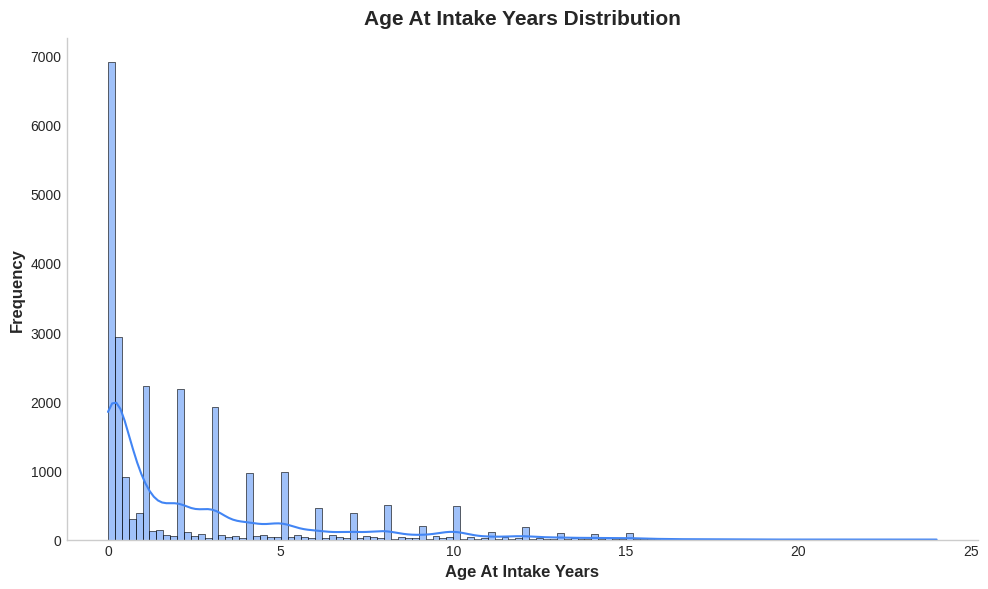

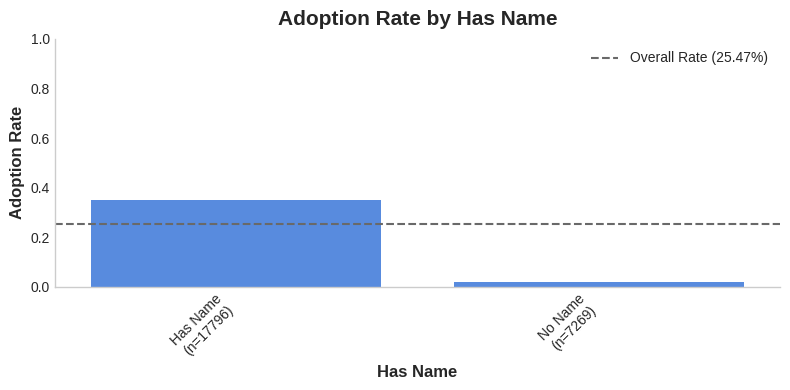

<ipython-input-5-2500007134>:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_category_adoption_rates = temp_df.groupby(feature_column)['is_adopted_binary'].mean()
<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


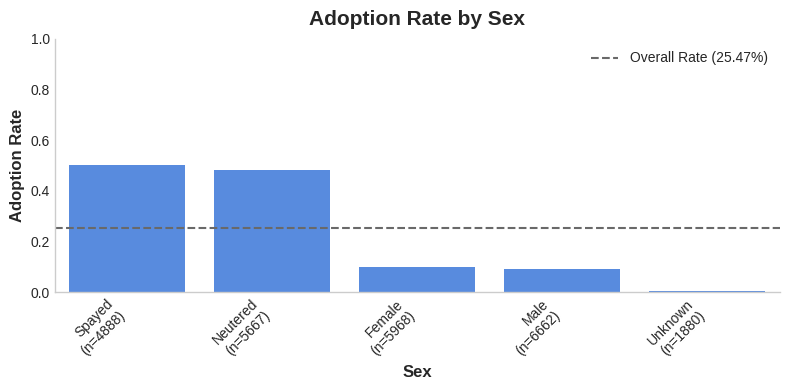

<ipython-input-5-2500007134>:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_category_adoption_rates = temp_df.groupby(feature_column)['is_adopted_binary'].mean()
<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


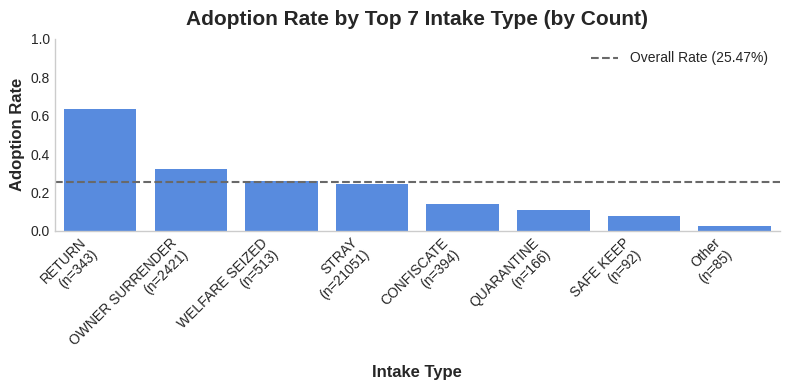

<ipython-input-5-2500007134>:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_category_adoption_rates = temp_df.groupby(feature_column)['is_adopted_binary'].mean()
<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


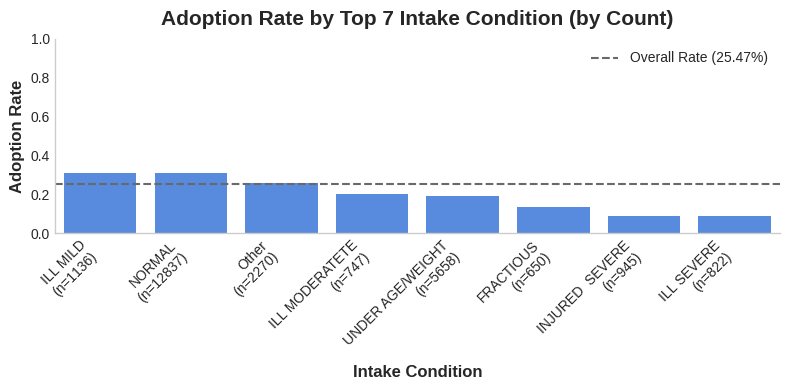

In [ ]:
#@title { vertical-output: true }
# --- Perform EDA on Long Beach Data ---
if 'df_long_beach_featured' in locals() and not df_long_beach_featured.empty:
    print("\n--- Starting EDA for Long Beach Data ---")
    eda_lb = ExploratoryDataAnalyzer(df_long_beach_featured)

    # Plot age distribution
    eda_lb.plot_distribution(column='age_at_intake_years')

    # Plot adoption rate by has_name
    eda_lb.plot_feature_vs_outcome(
        feature_column='has_name',
        outcome_column='outcome_type',
        positive_outcome_value='ADOPTION',
        xtick_label_map={1: "Has Name", 0: "No Name"},
        figure_size=(8,4)
    )

    eda_lb.plot_feature_vs_outcome(
        feature_column='sex',
        outcome_column='outcome_type',
        positive_outcome_value='ADOPTION',
        figure_size=(8,4)
    )

    eda_lb.plot_feature_vs_outcome(
        feature_column='intake_type',
        outcome_column='outcome_type',
        positive_outcome_value='ADOPTION',
        figure_size=(8,4)
    )

    eda_lb.plot_feature_vs_outcome(
        feature_column='intake_condition',
        outcome_column='outcome_type',
        positive_outcome_value='ADOPTION',
        figure_size=(8,4)
    )

---
### **Hypothesis Testing: Association Between Predictors and Adoption**
Here we use the Chi-squared test to determine if there is a statistically significant association between key categorical features and the adoption outcome, as recommended in the Google Cloud EDA guide. A low p-value (<0.05) suggests an association.


--- Association Test: 'intake_condition' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted            0     1  Total count pct_adopted
intake_condition                                      
INJURED  MILD       441   207          648       31.9%
ILL MILD            783   353         1136       31.1%
NORMAL             8886  3951        12837       30.8%
Other               546   241          787       30.6%
INJURED  MODERATE   428   123          551       22.3%
ILL MODERATETE      597   150          747       20.1%
UNDER AGE/WEIGHT   4561  1097         5658       19.4%
FRACTIOUS           562    88          650       13.5%
INJURED  SEVERE     863    82          945        8.7%
ILL SEVERE          751    71          822        8.6%
FERAL               264    20          284        7.0%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'intake_condition' and 'is_adopted' are independent (no association).
Chi-Squared Statistic: 721.9025
P-value: 

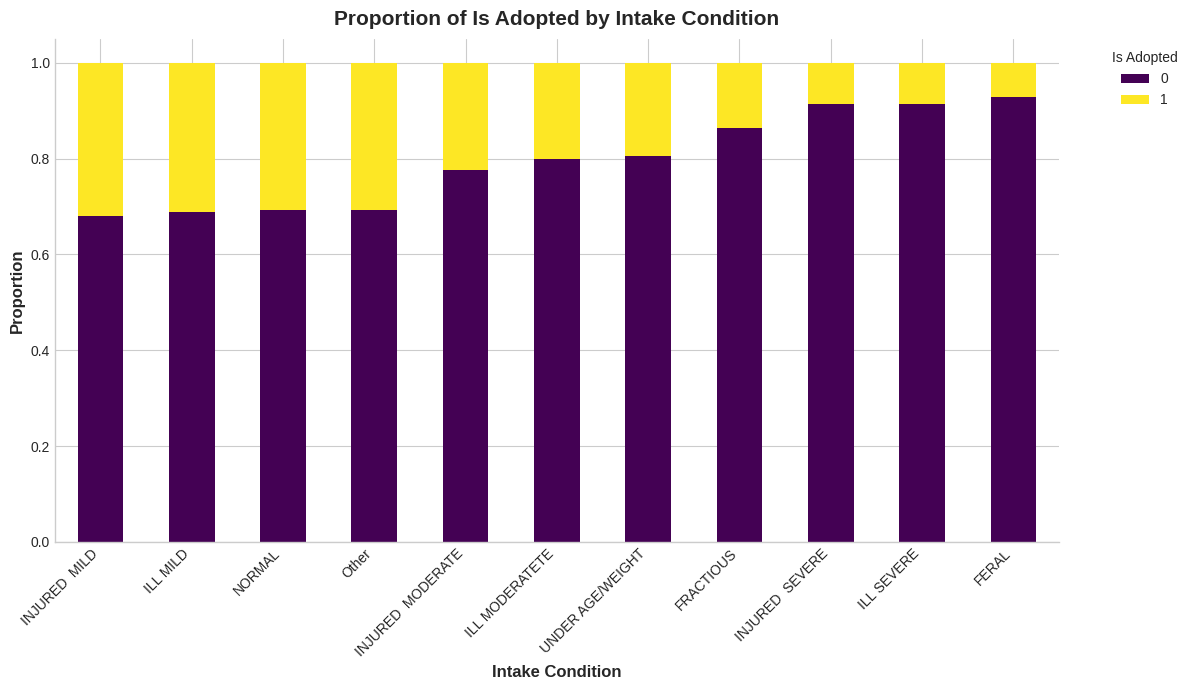


--- Association Test: 'sex' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted     0     1  Total count pct_adopted
sex                                            
Spayed      2442  2446         4888       50.0%
Neutered    2942  2725         5667       48.1%
Female      5386   582         5968        9.8%
Male        6042   620         6662        9.3%
Unknown     1870    10         1880        0.5%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'sex' and 'is_adopted' are independent (no association).
Chi-Squared Statistic: 5391.5598
P-value: 0.0000

--- Conclusion ---
P-value (0.0000) is less than the significance level (0.05).
Conclusion: We reject the null hypothesis. There IS a statistically significant association between 'sex' and 'is_adopted'.

--- Visualization ---


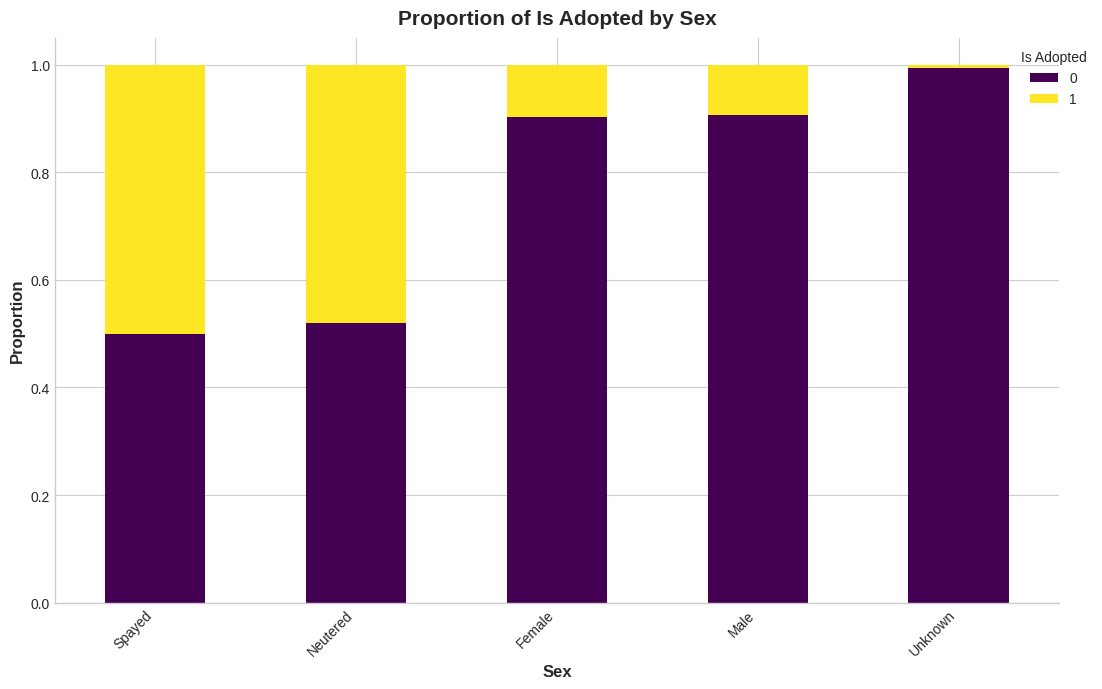


--- Association Test: 'primary_color' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted        0     1  Total count pct_adopted
primary_color                                     
GRAY TABBY      938   365         1303       28.0%
ORANGE          395   149          544       27.4%
ORG TABBY       625   230          855       26.9%
TAN            1061   384         1445       26.6%
BROWN          1447   523         1970       26.5%
Other          2689   936         3625       25.8%
GRAY           1713   587         2300       25.5%
BLACK          5155  1762         6917       25.5%
CALICO          401   135          536       25.2%
WHITE          2454   803         3257       24.7%
BRN TABBY      1804   509         2313       22.0%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'primary_color' and 'is_adopted' are independent (no association).
Chi-Squared Statistic: 24.5737
P-value: 0.0062

--- Conclusion ---
P-value (0.0062) is less than th

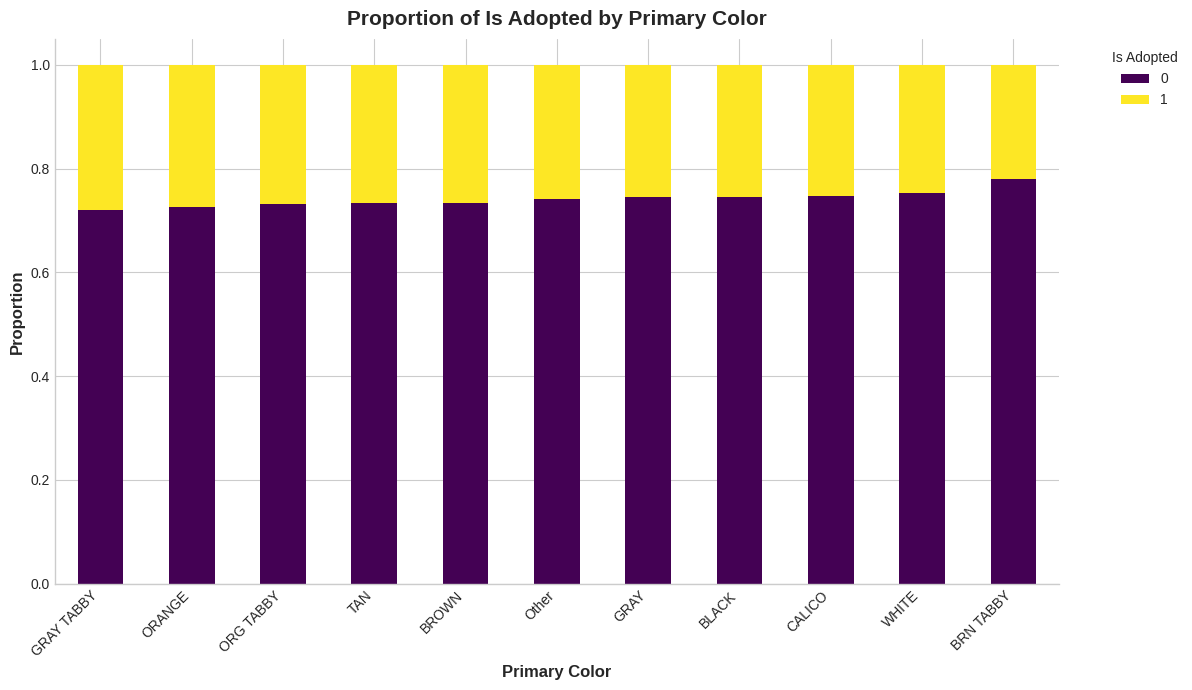


--- Association Test: 'intake_type' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted                 0     1  Total count pct_adopted
intake_type                                                
RETURN                   126   217          343       63.3%
Adopted Animal Return      2     1            3       33.3%
OWNER SURRENDER         1645   776         2421       32.1%
WELFARE SEIZED           380   133          513       25.9%
STRAY                  15877  5174        21051       24.6%
CONFISCATE               338    56          394       14.2%
QUARANTINE               148    18          166       10.8%
SAFE KEEP                 85     7           92        7.6%
TRAP, NEUTER, RETURN      73     1           74        1.4%
Euthenasia Required        4     0            4        0.0%
Other                      4     0            4        0.0%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'intake_type' and 'is_adopted' are independent (no 

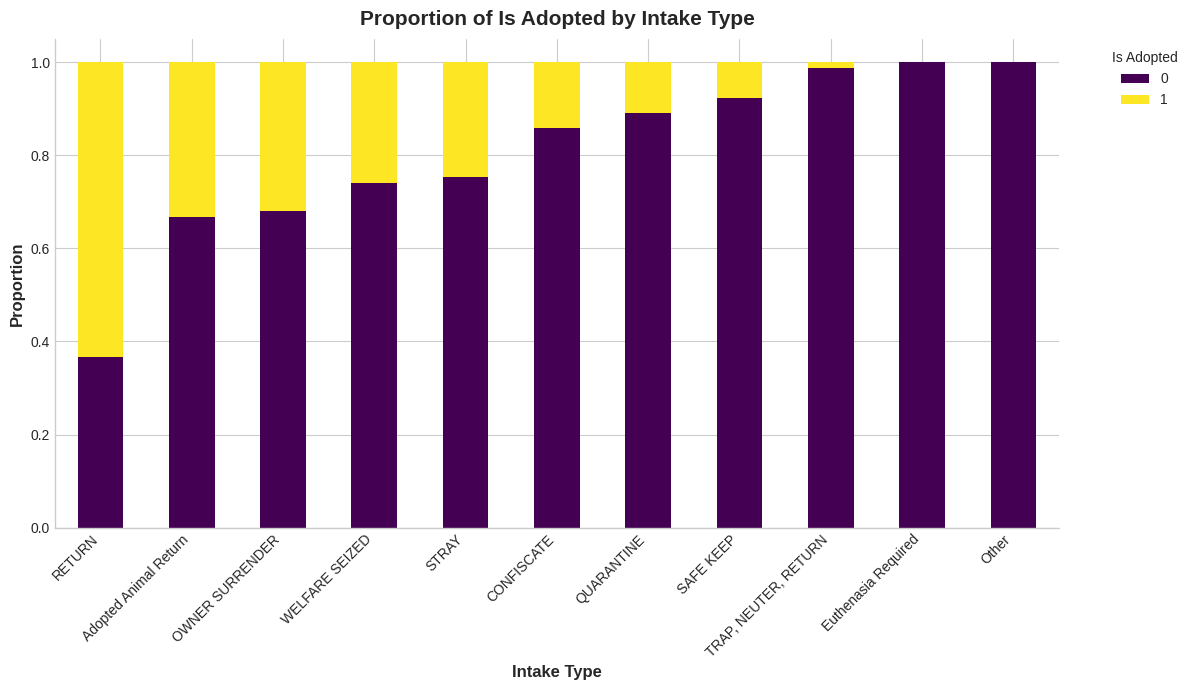


--- Association Test: 'animal_type' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted       0     1  Total count pct_adopted
animal_type                                      
DOG           7515  2772        10287       26.9%
CAT          11167  3611        14778       24.4%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'animal_type' and 'is_adopted' are independent (no association).
Chi-Squared Statistic: 20.0258
P-value: 0.0000

--- Conclusion ---
P-value (0.0000) is less than the significance level (0.05).
Conclusion: We reject the null hypothesis. There IS a statistically significant association between 'animal_type' and 'is_adopted'.

--- Visualization ---


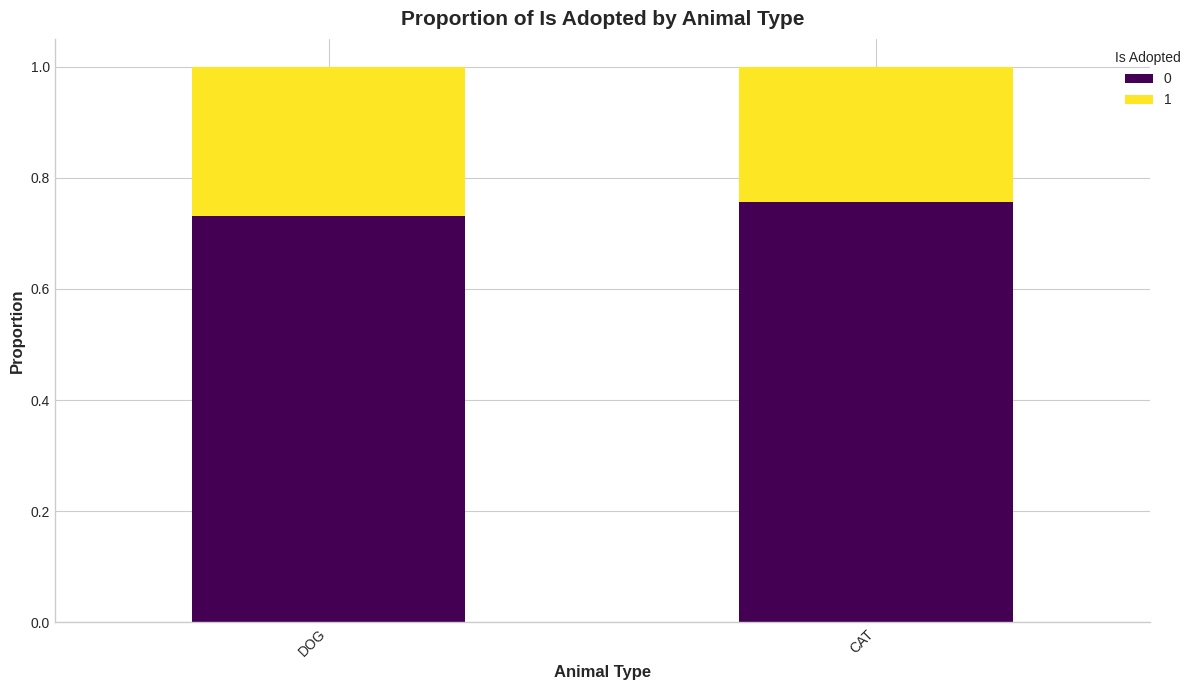


--- Association Test: 'intake_subtype' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted          0     1  Total count pct_adopted
intake_subtype                                      
ADOPTION           83   151          234       64.5%
ABAN FIELD         92    78          170       45.9%
ABAN SHLTR         78    44          122       36.1%
OTC             10468  4297        14765       29.1%
OWNER DIED         85    31          116       26.7%
Other             203    65          268       24.3%
CRUELTY            88    22          110       20.0%
POLICE            336    79          415       19.0%
FIELD            6390  1460         7850       18.6%
HOSPITAL          141    24          165       14.5%
TRAP              396    37          433        8.5%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'intake_subtype' and 'is_adopted' are independent (no association).
Chi-Squared Statistic: 616.6091
P-value: 0.0000

--- Conclusion ---
P-v

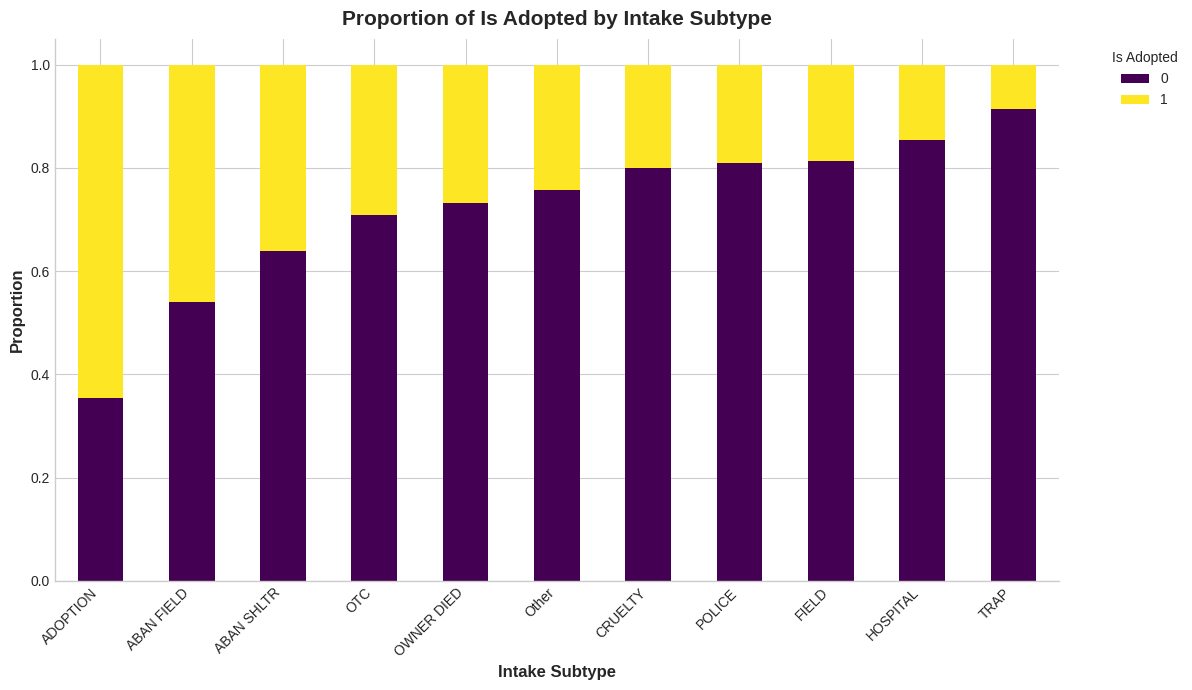


--- Association Test: 'reason_for_intake' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted           0    1  Total count pct_adopted
reason_for_intake                                   
Other              275  212          487       43.5%
OWNER DIED          44   31           75       41.3%
NO HOME             60   38           98       38.8%
COST                80   50          130       38.5%
MOVE               126   72          198       36.4%
LANDLORD            94   51          145       35.2%
NO TIME             73   34          107       31.8%
AGG ANIMAL          58   27           85       31.8%
BITES               73   31          104       29.8%
OWNER PROB         269  113          382       29.6%
TOO MANY            61   22           83       26.5%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'reason_for_intake' and 'is_adopted' are independent (no association).
Chi-Squared Statistic: 26.9532
P-value: 0.0026

--- Conclusion --

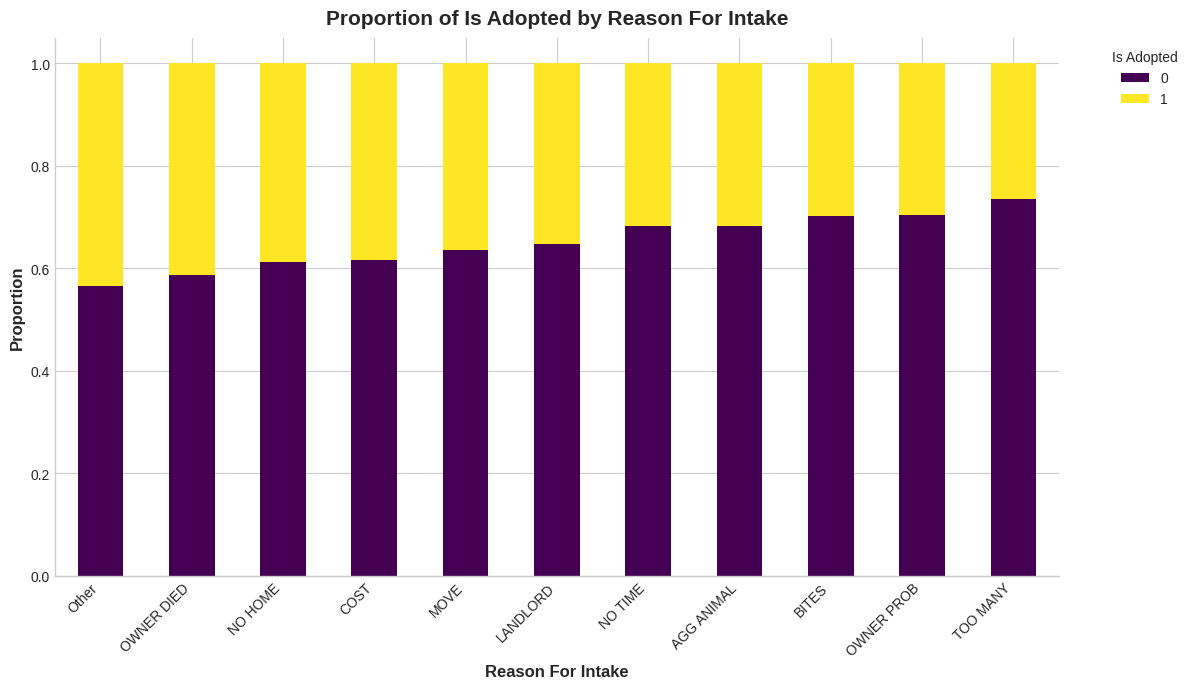


--- Association Test: 'age_at_intake_years' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted              0     1  Total count pct_adopted
age_at_intake_years                                     
0.3                   609   381          990       38.5%
0.2                  1218   722         1940       37.2%
1.0                  1469   631         2100       30.0%
2.0                  1484   613         2097       29.2%
Other                4525  1546         6071       25.5%
4.0                   698   224          922       24.3%
3.0                  1429   448         1877       23.9%
5.0                   729   227          956       23.7%
8.0                   355   110          465       23.7%
0.1                  3532  1058         4590       23.1%
0.0                  1962   357         2319       15.4%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'age_at_intake_years' and 'is_adopted' are independent (no association).
Chi-Squar

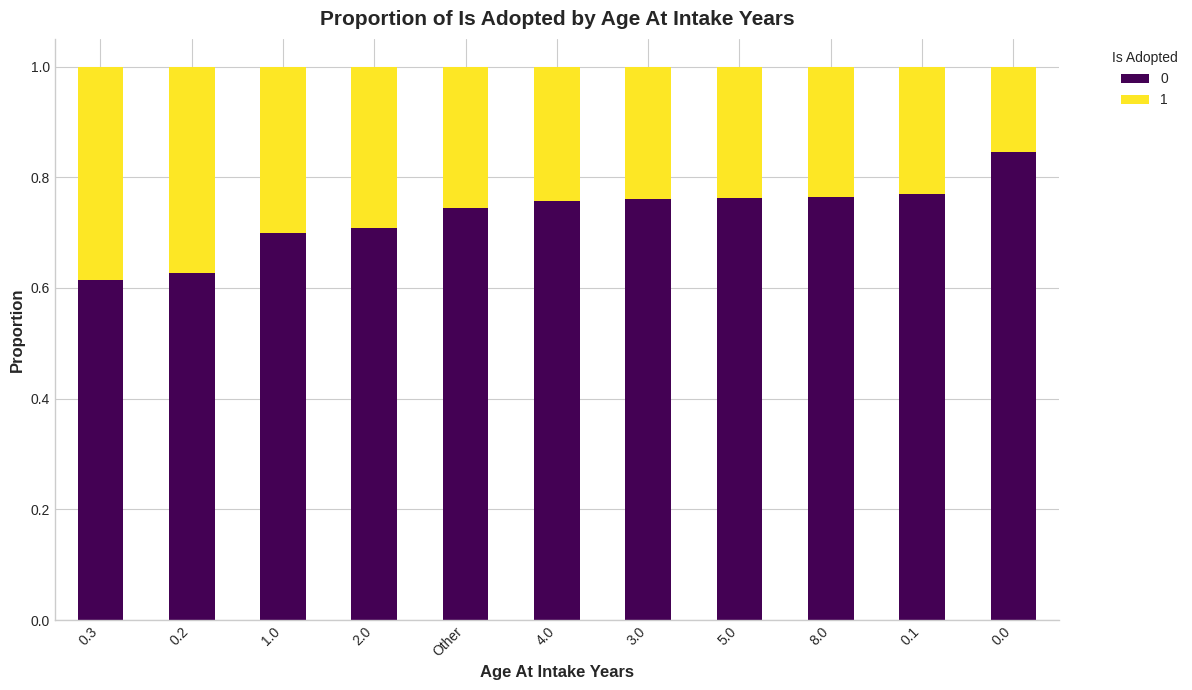

In [ ]:
#@title { vertical-output: true }
# List of categorical features to test against adoption outcome
categorical_predictors_to_test = [
    'intake_condition',
    'sex',
    'primary_color',
    'intake_type',
    'animal_type',
    'intake_subtype',
    'reason_for_intake',
    'age_at_intake_years'
]

target_variable = 'is_adopted'

for predictor in categorical_predictors_to_test:

    if predictor in eda_lb.df.columns and target_variable in eda_lb.df.columns:
        eda_lb.test_and_plot_categorical_association(
            cat_predictor=predictor,
            cat_target=target_variable,
            top_n_predictor=10 # Show top 10 most frequent categories, group rest as 'Other'
        )
    else:
        print(f"\nSkipping test for '{predictor}': column not found in the DataFrame.")

## Feature Selection
___
`intake_condition`, `animaltype`, `age`, `primary_color`, `days_until_outcome`, `is_returned`, `sex`,

`intake_subtype`?

Unique to this dataset: `intake_type`, `has_name`

# Workflow 2: Bloomington Animal Shelter Analysis
# ---------------------------------------------------------------------------

## Configuration & Data Loading (df_bloomington_raw)

In [ ]:
# --- Configuration for Bloomington Dataset ---
bloomington_config = {
    "url": "https://data.bloomington.in.gov/api/views/e245-r9ub/rows.csv?accessType=DOWNLOAD",
    "separator": ",",
    "datetime_cols": {
        'intakedate': 'datetime64[ns]',
        'movementdate': 'datetime64[ns]'
    },
    "categorical_cols": [
        'animal_type', 'primary_breed', 'color', 'sex', 'intake_type', 'outcome_type'
    ],
    # --- Map Bloomington's column names to the names our feature engineer expects ---
    "col_map": {
        "name": "animalname",
        "intake_date": "intakedate",
        "animal_type": "speciesname",
        "outcome_type": "movementtype",
        "sex": "sexname",
        "animal_name": "animalname",
        "primary_color": "basecolour",
        "outcome_date": "movementdate"
    },
    # --- Filtering Rules ---
    "animal_types_to_keep": ["Dog", "Cat"],
}

# --- Data Loading ---
loader_bt = DataLoader(csv_url=bloomington_config["url"], separator=bloomington_config["separator"])
df_bloomington_raw = loader_bt.load_data()

Attempting to load data from URL: https://data.bloomington.in.gov/api/views/e245-r9ub/rows.csv?accessType=DOWNLOAD
Data loaded successfully. Shape: (39760, 23)


## Data Cleaning & Filtering (df_bloomington_cleaned)
___
### Missing values:
1. `deceaseddate`: 96%, probably because there's not many that deceased.
2. `returndate`: same, only applicable for relevant records
3. `movementtype`: our outcome variable: **(EXECUTED) need to remove those that do not have an outcome**. Lack of documentation on why we are missing values - data entry error?

In [ ]:
#@title { vertical-output: true }
# --- Data Cleaning & Filtering ---
if not df_bloomington_raw.empty:
    cleaner_bt = DataCleaner(df_bloomington_raw)
    cleaner_bt.clean_column_names()

    # Pass the dataset-specific config maps
    cleaner_bt.convert_data_types(bloomington_config["datetime_cols"])
    cleaner_bt.convert_data_types({col: 'category' for col in bloomington_config["categorical_cols"]})

    # Check missing values
    cleaner_bt.check_missing_values()

    # Apply filters
    # Keep dogs and cats only.
    cleaner_bt.filter_by_values(
        column=bloomington_config["col_map"]["animal_type"],
        values=bloomington_config["animal_types_to_keep"],
        keep=True
    )

    # Remove those that do not have a movement type
    cleaner_bt.df = cleaner_bt.df.dropna(subset=['movementtype'])

    df_bloomington_cleaned = cleaner_bt.get_cleaned_df()
    print("\n--- Bloomington Data Cleaning Complete ---")
    print(f"Shape after cleaning and filtering: {df_bloomington_cleaned.shape}")

    # Check distribution
    cleaner_bt.display_value_counts()

Column names cleaned and standardized.

--- Applying Data Type Conversions ---


<ipython-input-3-3351524997>:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[col] = pd.to_datetime(self.df[col], errors='coerce')


Converted column 'intakedate' to datetime64[ns].


<ipython-input-3-3351524997>:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df[col] = pd.to_datetime(self.df[col], errors='coerce')


Converted column 'movementdate' to datetime64[ns].

--- Applying Data Type Conversions ---

--- Missing Values Check ---
                  Missing Count  Missing Percentage
deceaseddate              38388           96.549296
returndate                27261           68.563883
movementtype               6586           16.564386
movementdate               6586           16.564386
identichipnumber           4545           11.431087
breedname                    77            0.193662
intakereason                  2            0.005030
--- End of Missing Values Check ---
Filtered 'speciesname': Kept rows where value is in ['Dog', 'Cat']. Kept 38240 of 39760 rows.

--- Bloomington Data Cleaning Complete ---
Shape after cleaning and filtering: (31811, 23)

--- Displaying Value Counts for All Columns ---

--- Value Counts for 'id' (Dtype: int64) ---
  Number of Unique Values: 20057
  Value Counts (Top 15 of 20057):
id
72513    14
71461    12
68297    11
58510    11
60702    11
75714    11
6500

## Column Matching with Other Dataframes

In [ ]:
# 1. Instantiate the class
matcher = DataIntegration(df_long_beach_cleaned, df_bloomington_cleaned)

# 2. Find the matches using desired weights
column_mapping = matcher.find_column_matches(name_weight=0.4, value_weight=0.6, score_threshold=10)

# 3. Display the results
print("\n--- Automated Column Matching Results ---")
print(column_mapping.to_string())

DataIntegration class initialized with two DataFrames.

Finding matches with name_weight=0.4, value_weight=0.6, threshold=10...

--- Automated Column Matching Results ---
        source_column best_match_column  match_score
12       outcome_date      movementdate           78
7         intake_date      movementdate           77
2         animal_type       speciesname           72
5                 sex           sexname           60
1         animal_name        animalname           46
15       outcome_type      movementtype           33
6                 dob      movementdate           32
4     secondary_color        basecolour           32
9         intake_type        intakedate           32
3       primary_color        basecolour           31
19     intake_is_dead        intakedate           29
0           animal_id         animalage           28
10     intake_subtype        intakedate           28
8    intake_condition        intakedate           26
16    outcome_subtype      movemen

## Feature Engineering (df_bloomington_featured)
1. TODO: create short vs. long hair breed. Breed has too high of a cardinality.
2. Added `days_until_outcome`, `months_until_outcome`, `years_until_outcome` variables.
3. TODO (DONE): add `is_returned`, `age` features

In [ ]:
# --- Feature Engineering ---
if 'df_bloomington_cleaned' in locals() and not df_bloomington_cleaned.empty:
    fe_bt = FeatureEngineer(df_bloomington_cleaned)
    col_map = bloomington_config["col_map"]

    fe_bt.create_binary_flag_from_null(source_col=col_map["name"], new_col_name='has_name')
    fe_bt.create_binary_flag_from_value(source_col=col_map["outcome_type"], positive_value='Adoption', new_col_name='is_adopted')

    df_bloomington_featured = fe_bt.get_engineered_df()
    print("\n--- Bloomington Feature Engineering Complete ---")


    # 1. Create days_until_outcome field

    # --- Step 1: Calculate the difference in days ---
    fe_bt.create_feature_from_date_diff(
        start_date_col='intakedate',
        end_date_col='movementdate',
        new_col_name='days_until_outcome',
        unit='D' # 'D' for Days
    )

    # --- Step 2: Convert the new 'days' column into months and years ---

    # 2. Create months_until_outcome
    fe_bt.convert_days_to_unit(
        days_col='days_until_outcome',
        new_col_name='months_until_outcome',
        unit='M' # 'M' for Months
    )

    # 3. Create years_until_outcome
    fe_bt.convert_days_to_unit(
        days_col='days_until_outcome',
        new_col_name='years_until_outcome',
        unit='Y' # 'Y' for Years
    )

    # 4. Create age column
    if 'animalage' in fe_bt.df.columns:
        fe_bt.parse_text_age_to_years(text_age_col='animalage', new_col_name_years='age_in_years_parsed')

    # 5. Create is_returned column

    # Create a '1' if 'returndate' is NOT NaN, and '0' if it is NaN.
    fe_bt.create_binary_flag_from_null(
        source_col='returndate',
        new_col_name='is_returned'
    )

    # Get the updated DataFrame
    df_bloomington_featured = fe_bt.get_engineered_df()

    # Verify the results to see the new column in action
    print("\n--- Verifying 'is_returned' Feature ---")
    if 'is_returned' in df_bloomington_featured.columns:
        print("Value counts for the new 'is_returned' column:")
        print(df_bloomington_featured['is_returned'].value_counts())

        # Show some examples of rows where a return date exists
        print("\nExamples of animals that were returned (is_returned = 1):")
        print(df_bloomington_featured[df_bloomington_featured['is_returned'] == 1][['returndate', 'is_returned']].head())
    else:
        print(f"'{return_proxy_col}' column might not exist, 'is_returned' feature was not created.")

    # Verify the new column was created correctly
    if 'age_in_years_parsed' in df_bloomington_featured.columns:
        print("\nVerifying parsed age column:")
        print(df_bloomington_featured[['animalage', 'age_in_years_parsed']].head(10))


Feature 'has_name' created from 'animalname'.
Feature 'is_adopted' created (1 if movementtype is 'Adoption', 0 otherwise).

--- Bloomington Feature Engineering Complete ---
Feature 'days_until_outcome' created in units 'D'.
Feature 'months_until_outcome' created from 'days_until_outcome' in units 'M'.
Feature 'years_until_outcome' created from 'days_until_outcome' in units 'Y'.
Feature 'age_in_years_parsed' created by parsing 'animalage'.
Feature 'is_returned' created from 'returndate'.

--- Verifying 'is_returned' Feature ---
Value counts for the new 'is_returned' column:
is_returned
0    19535
1    12276
Name: count, dtype: int64

Examples of animals that were returned (is_returned = 1):
               returndate  is_returned
0  10/31/2024 12:00:00 AM            1
2  02/28/2020 12:00:00 AM            1
3  11/06/2023 12:00:00 AM            1
7  05/29/2018 12:00:00 AM            1
9  05/08/2017 12:00:00 AM            1

Verifying parsed age column:
              animalage  age_in_years

## EDA

In [ ]:
# --- Initiate EDA Bloomington instance ---
if 'df_bloomington_featured' in locals() and not df_bloomington_featured.empty:
    print("\n--- Starting EDA for Bloomington Data ---")
    eda_bt = ExploratoryDataAnalyzer(df_bloomington_featured)


--- Starting EDA for Bloomington Data ---


### EDA - descriptive / univariate analysis
__________

### Distribution / cardinality insights:
1. `breed`: (TODO) there are 1264 breeds! Might need to find a way to simplify this in feature engineering. Domestic short hair dog is the most common (18k records) / seems to be a catch all? "The Domestic shorthair comes in a wide array of colors, sizes, and statures, though they tend to be medium-sized and muscular. They have short, sleek coats and round heads and paws. Because of their mixed parentage, Domestic Shorthairs don't tend to be at-risk for any unusual health complications."
2. `animal type`: considerably more cat than dogs.
3. `age`: 8 months seems to be the most common and minimum cutoff.
4. `outcome type`: doesn't seem to have rescue.
5. `deceased reason`: almost all court order / legal. Perhaps this is a kill shelter?
6. `basecolor`: 60 different colors!
7. `hasname`: all have a name
8. `intakereason`: 36!


--- Generating High-Level Statistical Summary of the Dataset ---

--- Comprehensive Data Summary ---

--- Descriptive Statistics (Quantiles, Frequencies, etc.) ---
                        count unique                     top   freq  \
id                    31811.0    NaN                     NaN    NaN   
intakedate              31811    NaN                     NaN    NaN   
intakereason            31810     35                   Stray  16492   
istransfer              31811      2                   False  31728   
sheltercode             31811  20057                D2202176     14   
identichipnumber        28859  17188         985113003276857     14   
animalname              31811   9692                    Luna    147   
breedname               31810   1264     Domestic Short Hair  16334   
basecolour              31811     80                   Black   4457   
speciesname             31811      2                     Cat  19872   
animalage               31811    365               8 m

<ipython-input-5-2500007134>:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)
<ipython-input-5-2500007134>:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)
<ipython-input-5-2500007134>:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)
<ipython-input-5-2500007134>:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=t

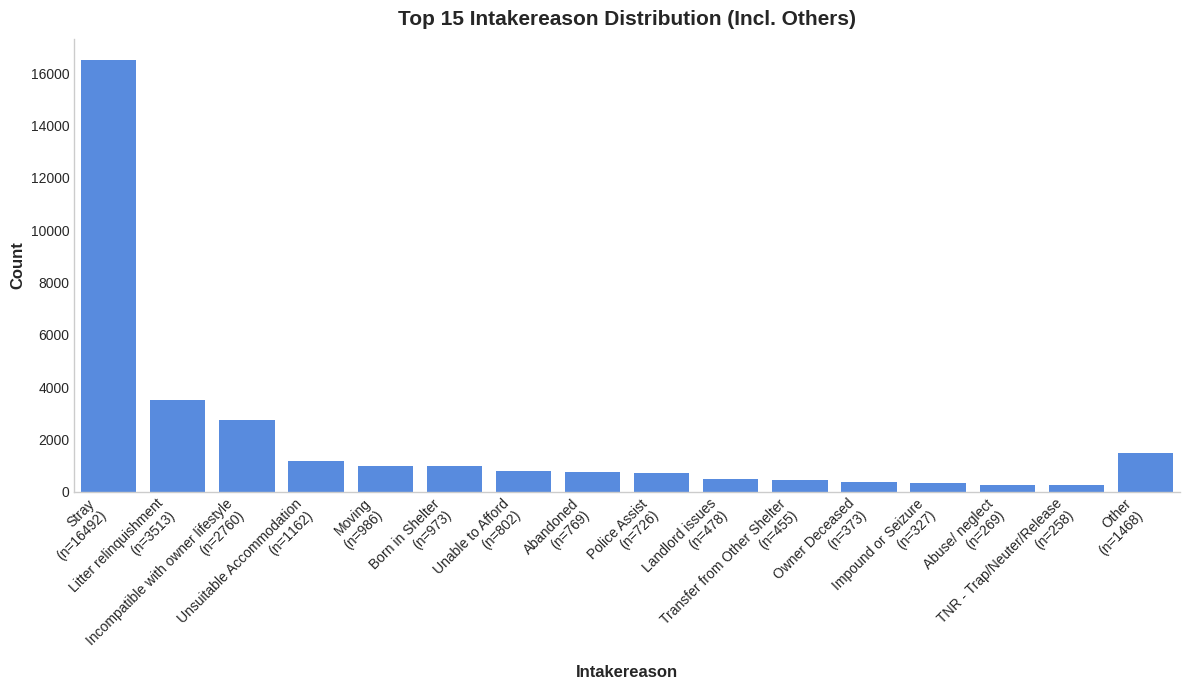

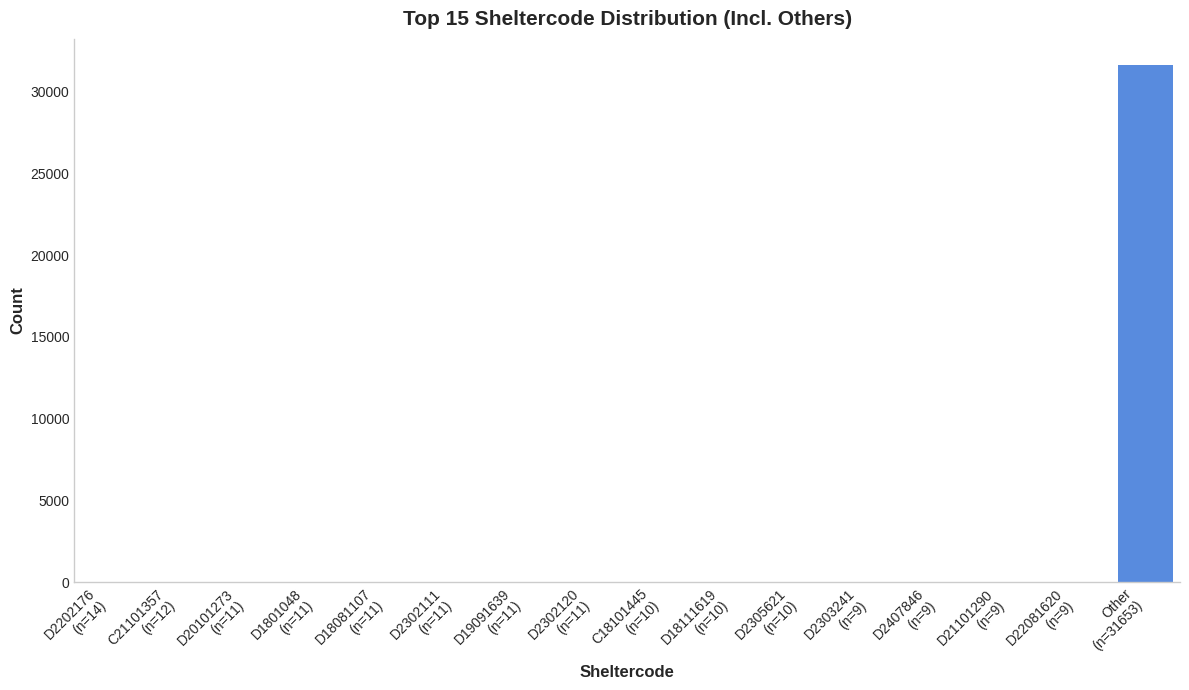

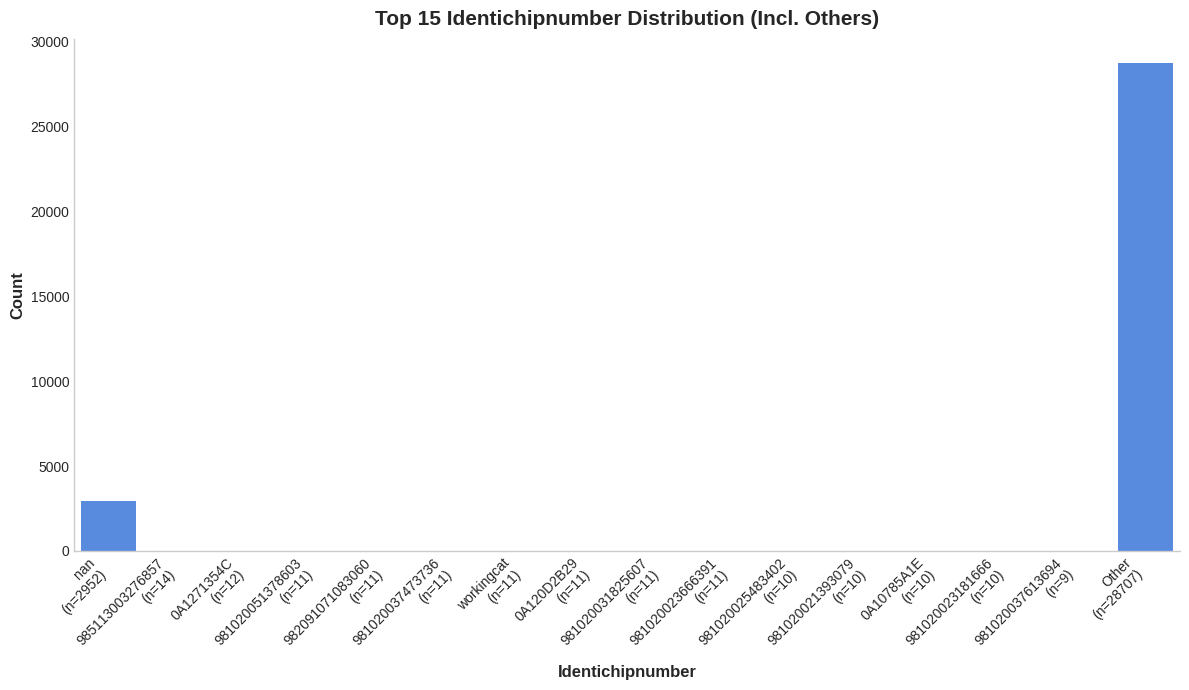

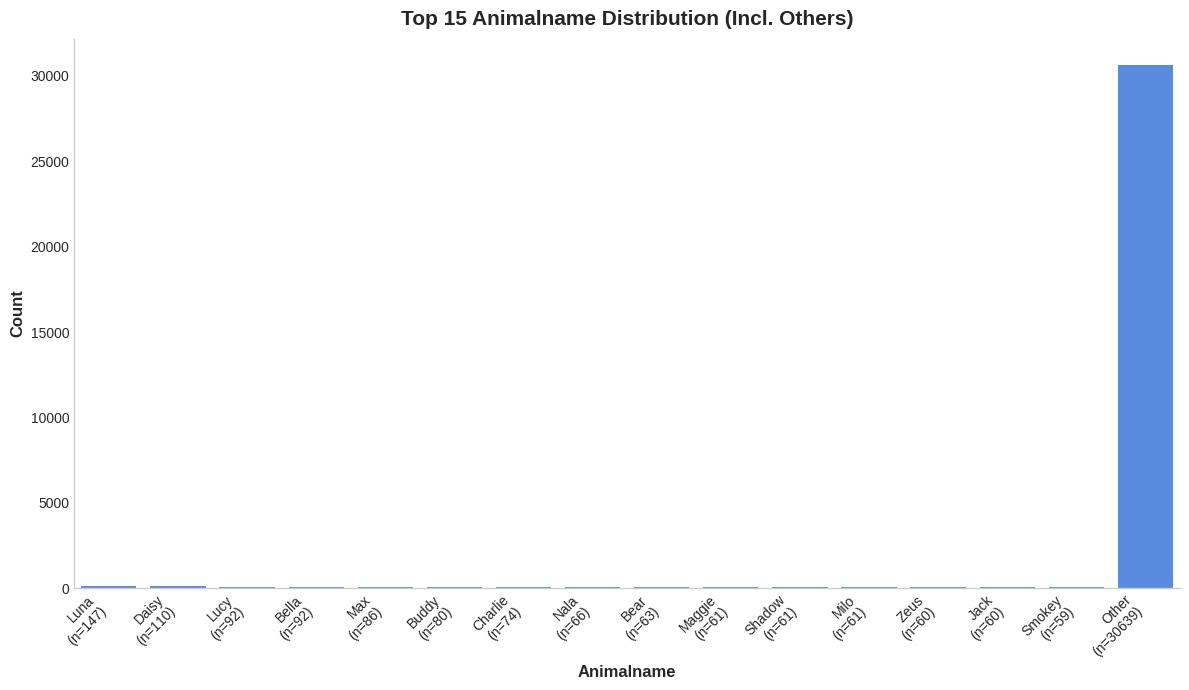

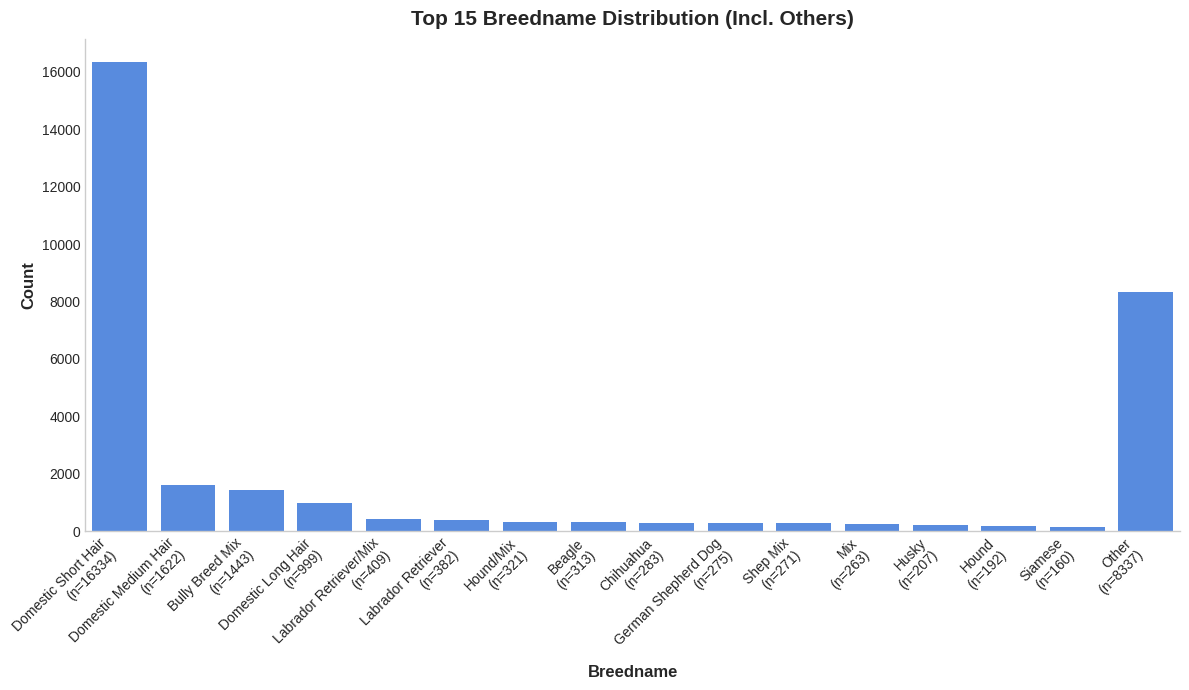

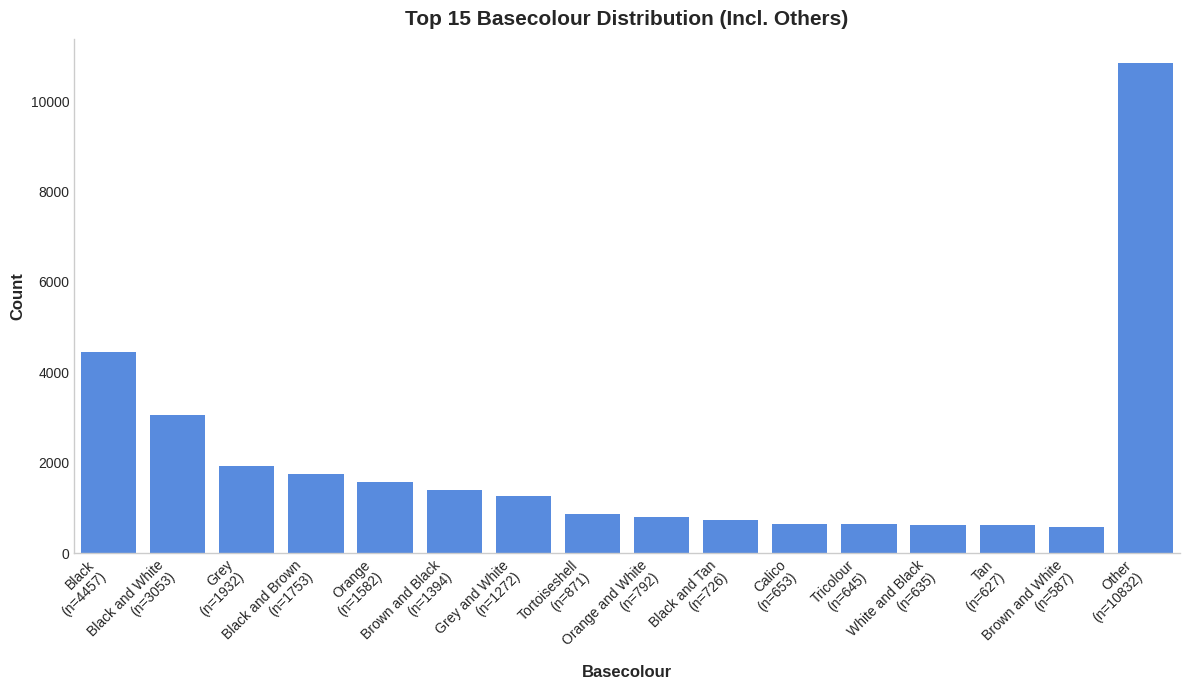

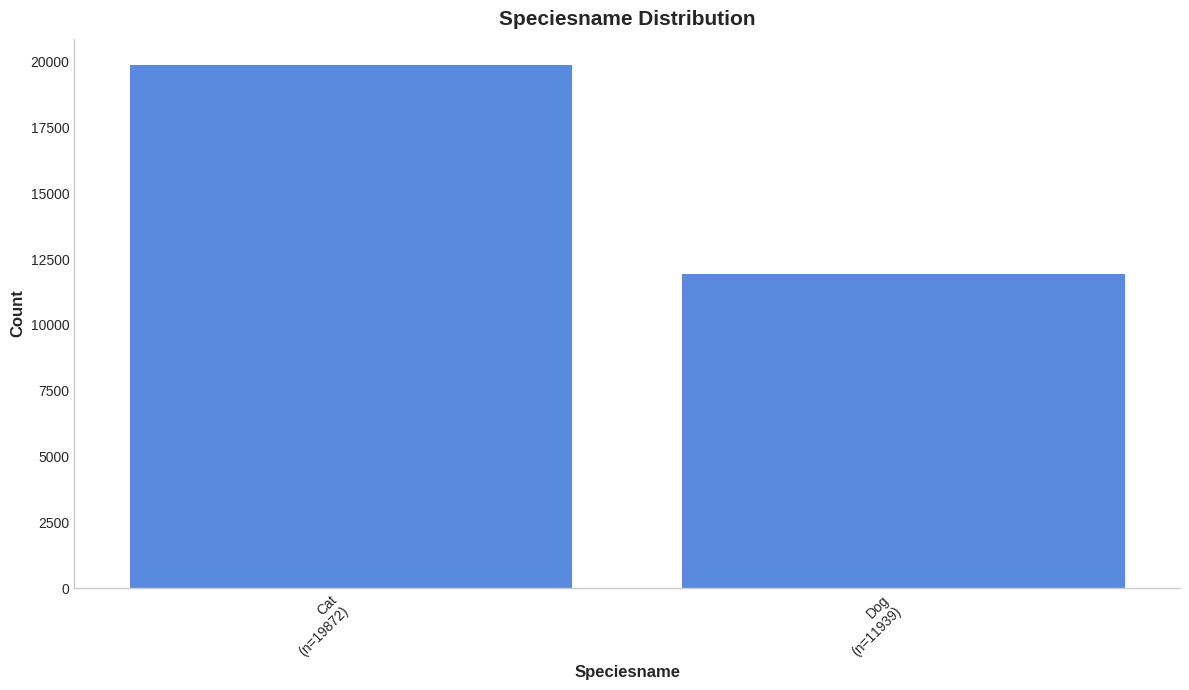

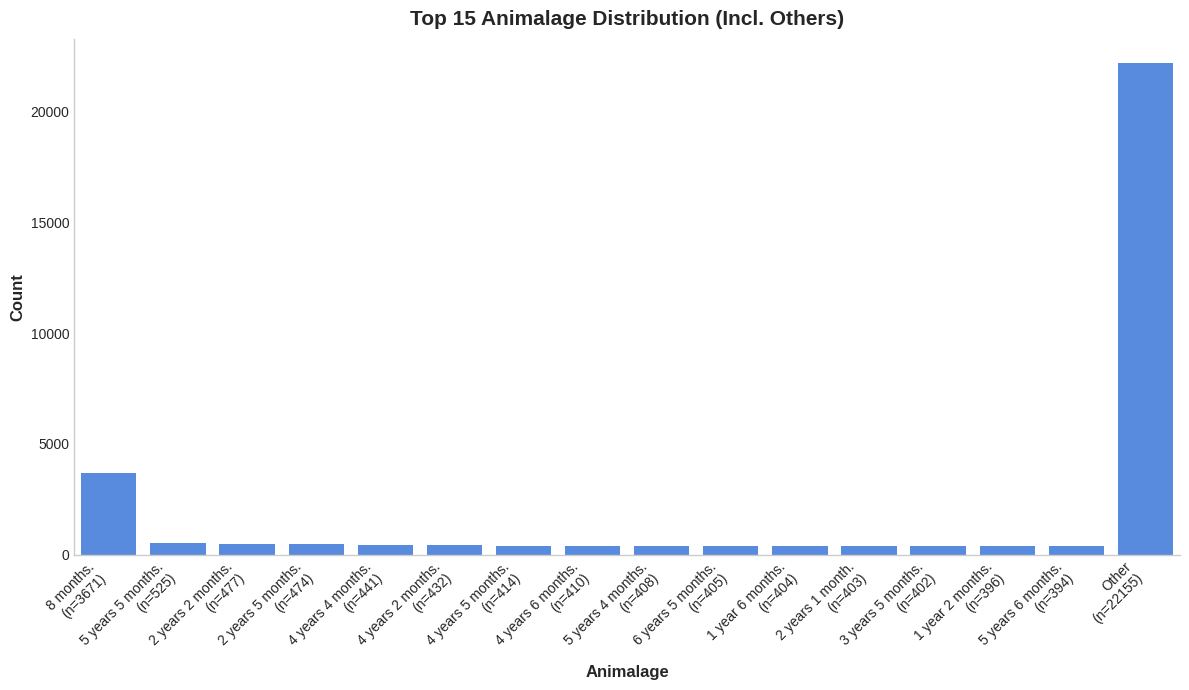

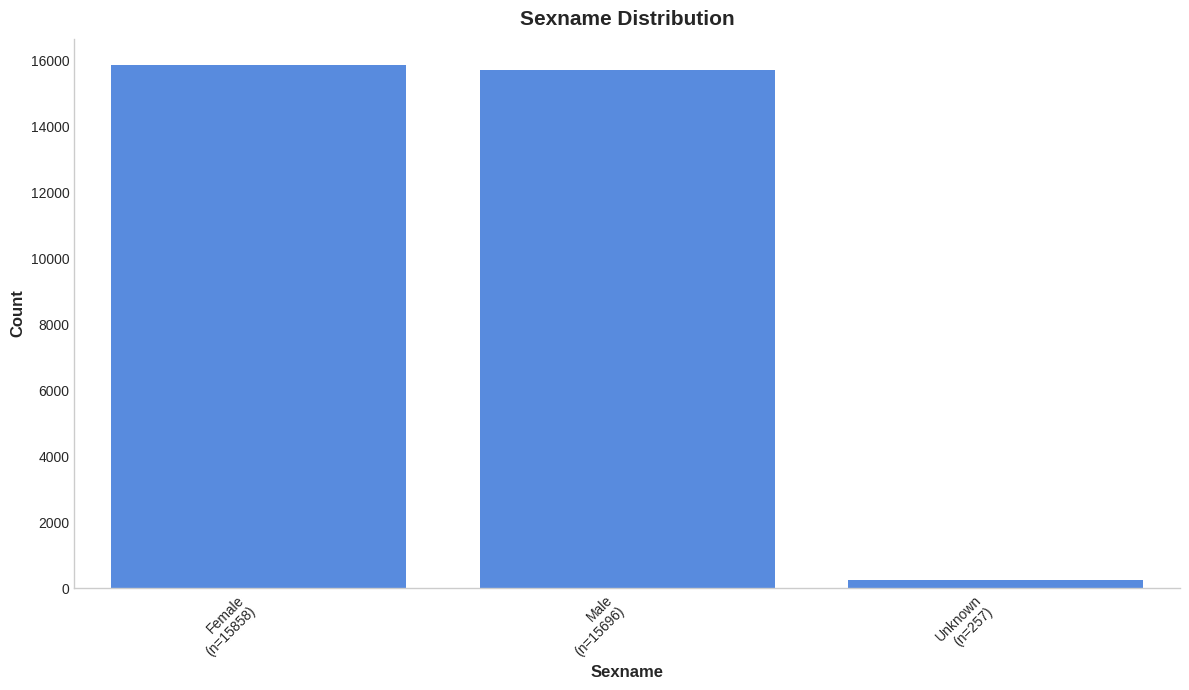

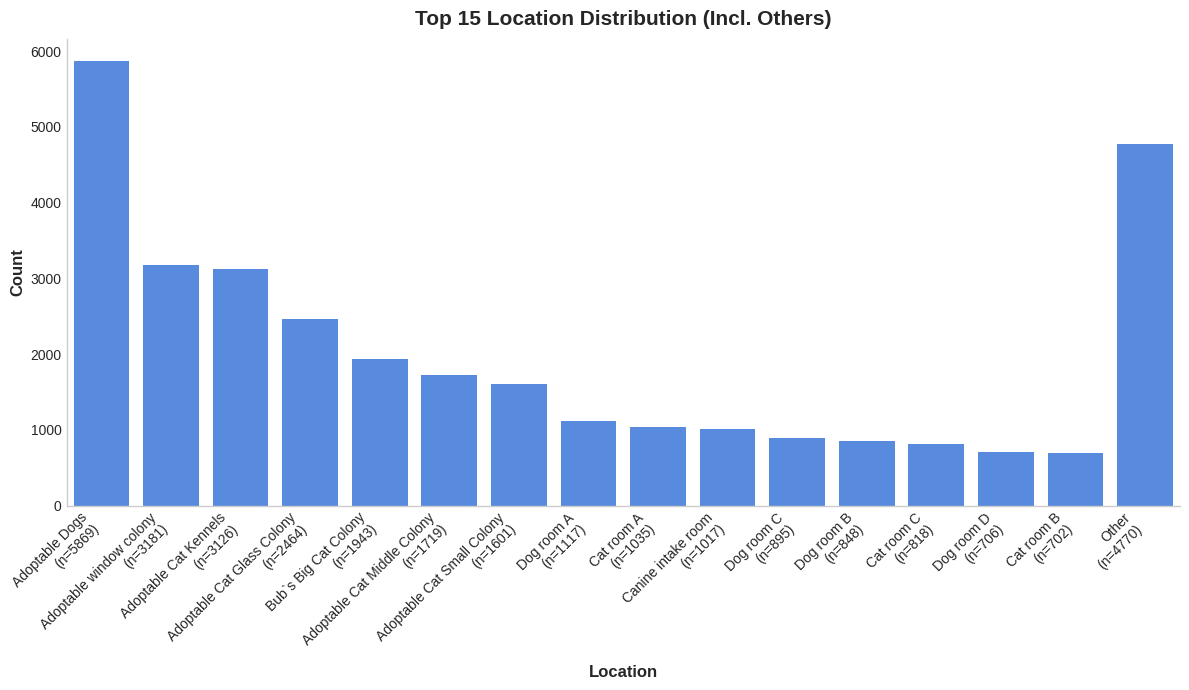

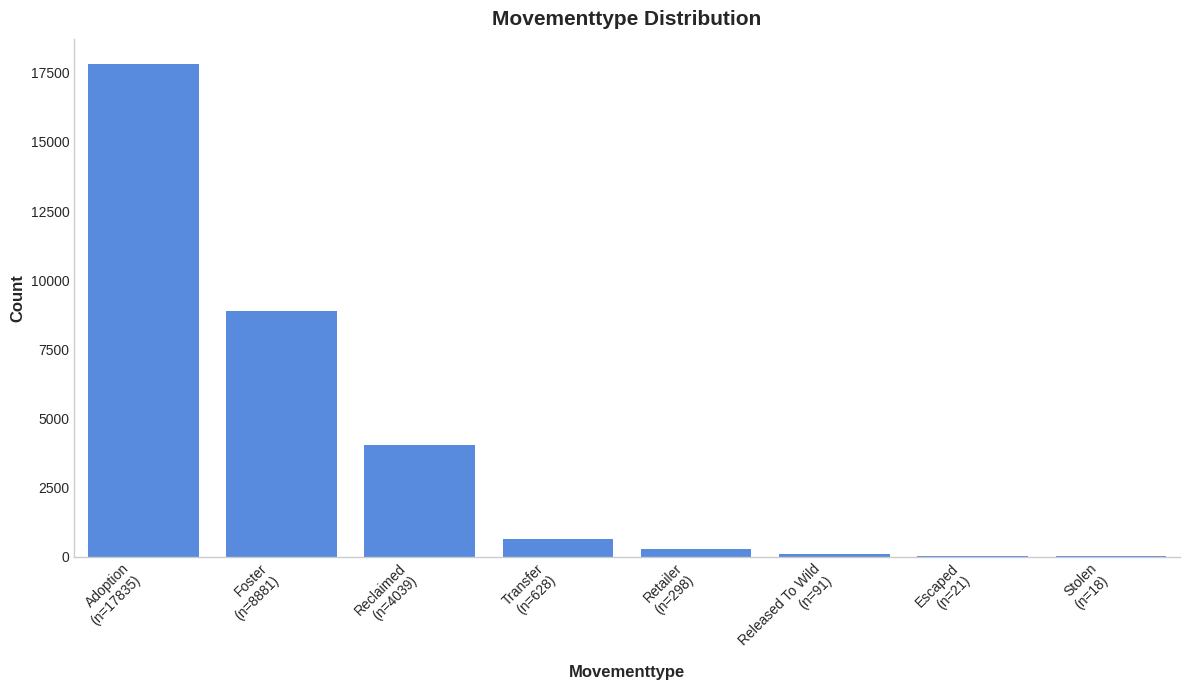

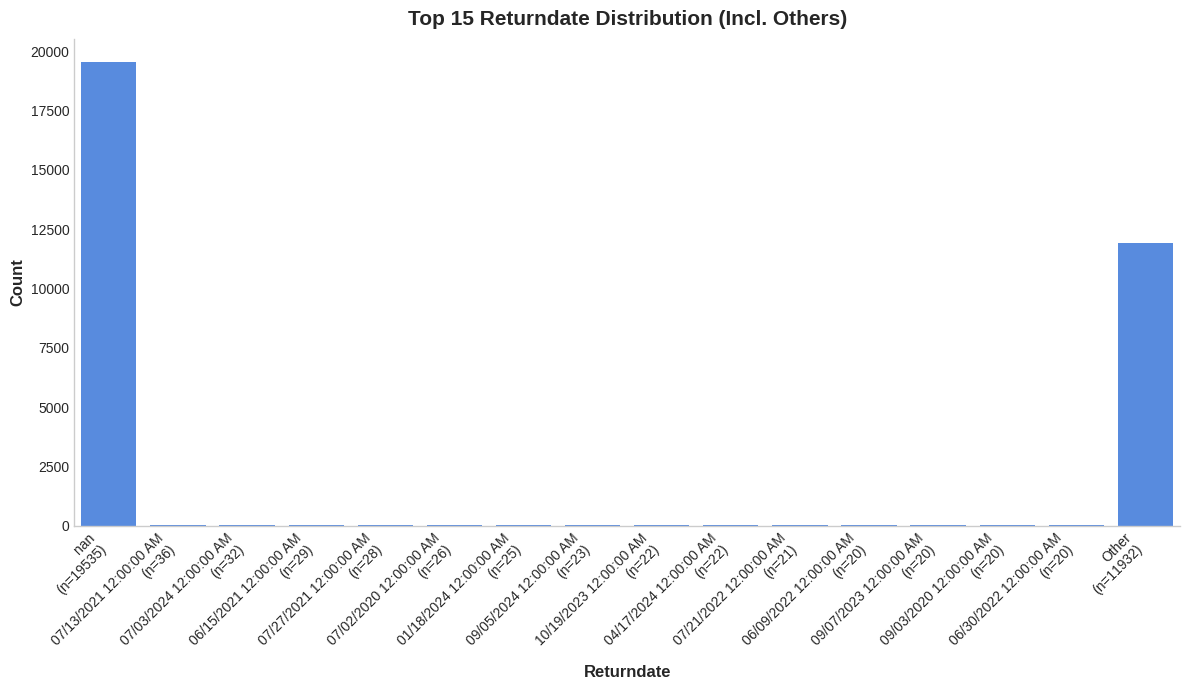

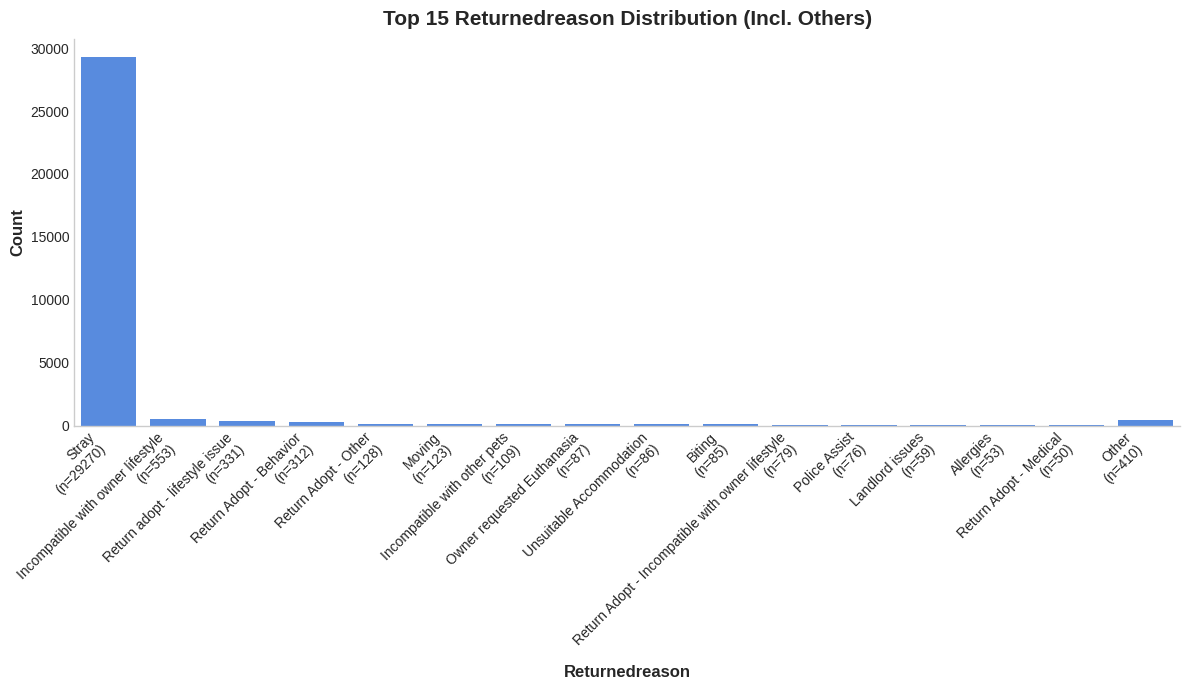

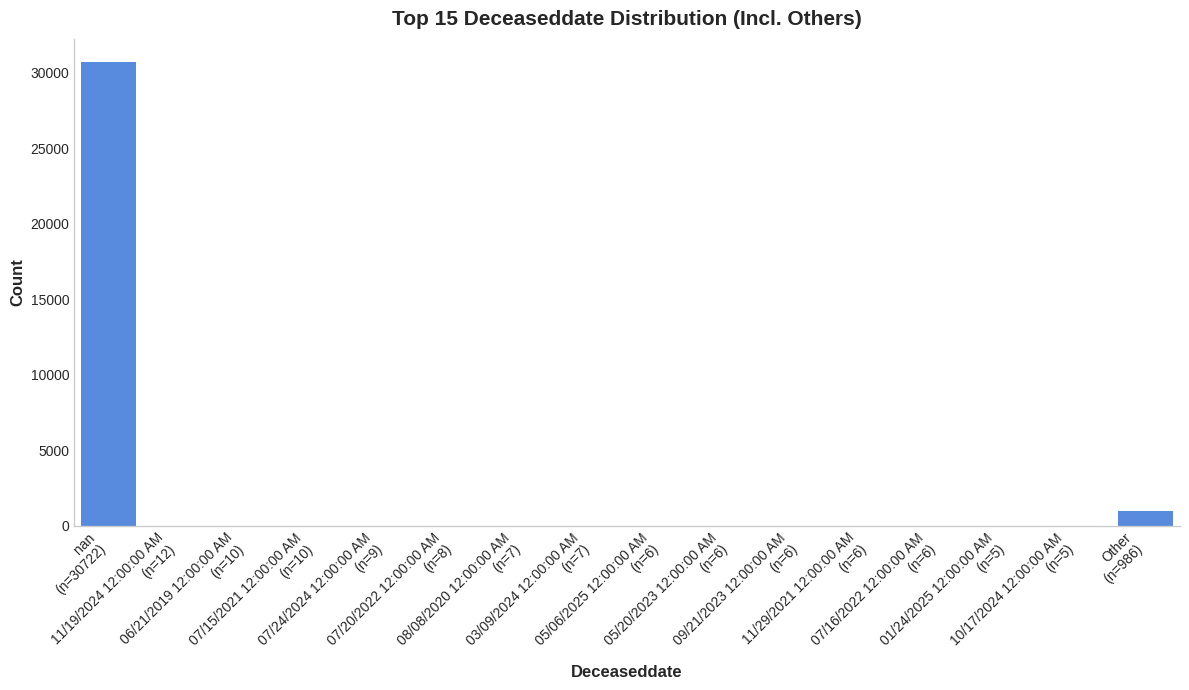

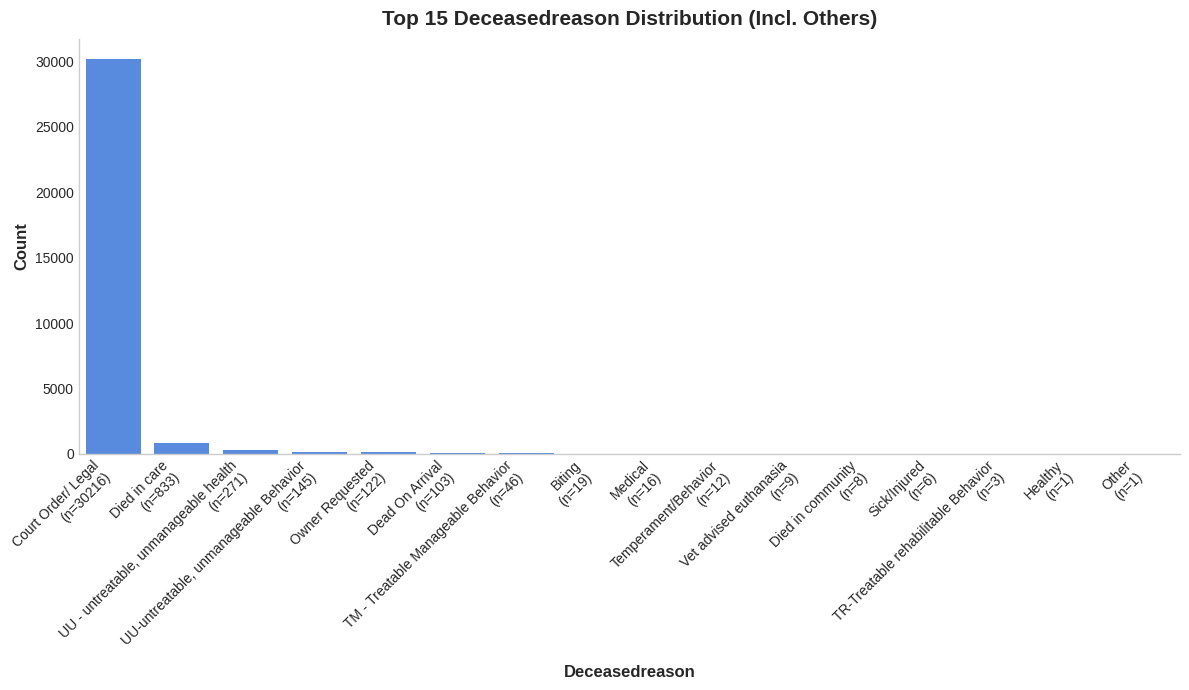

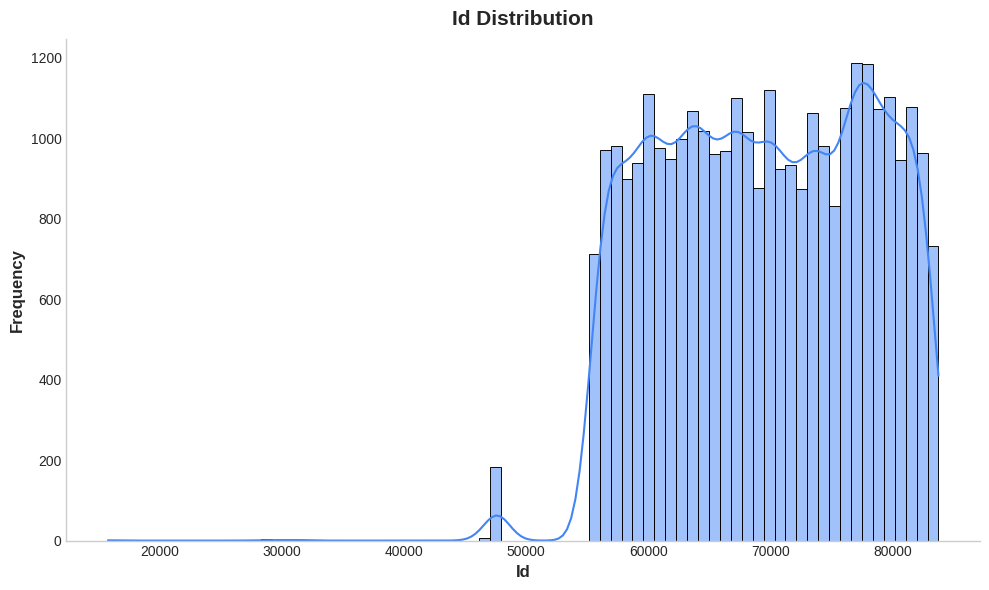

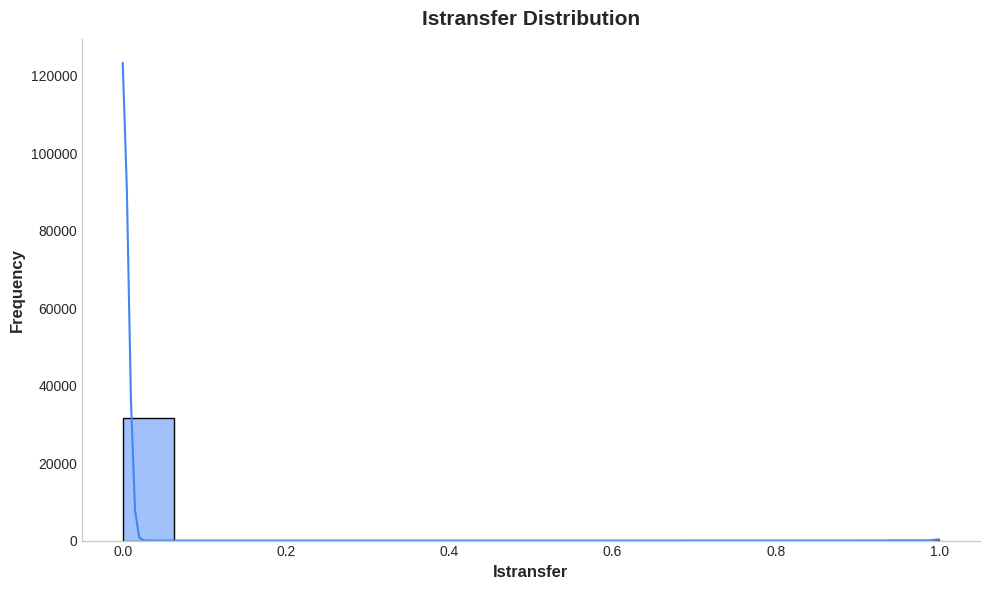

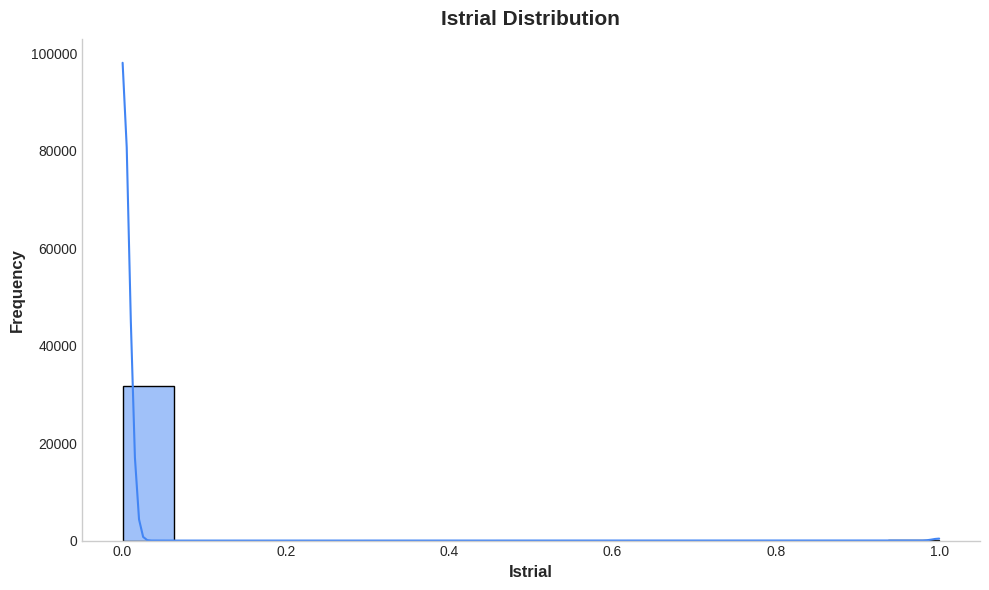

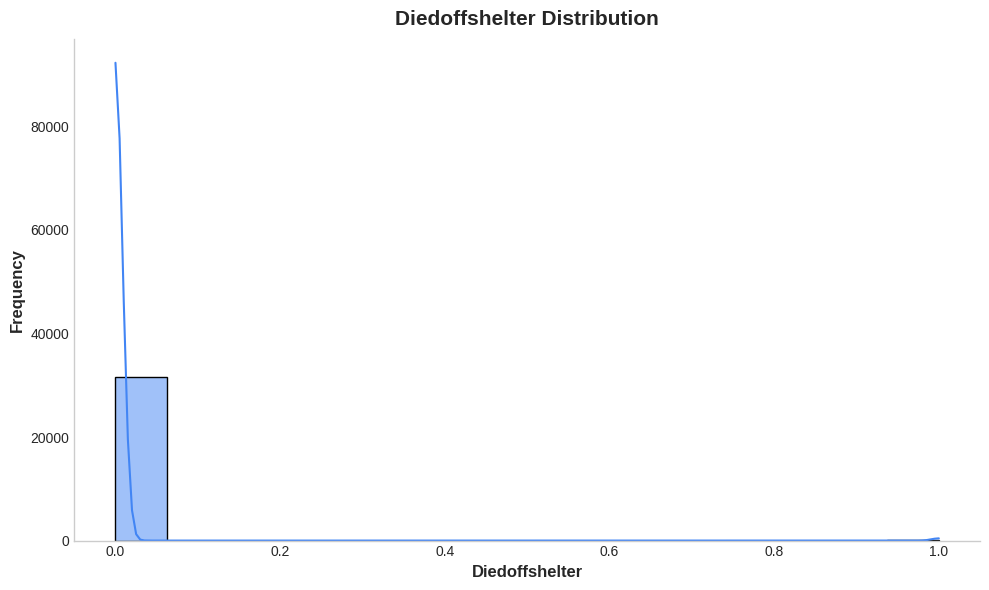

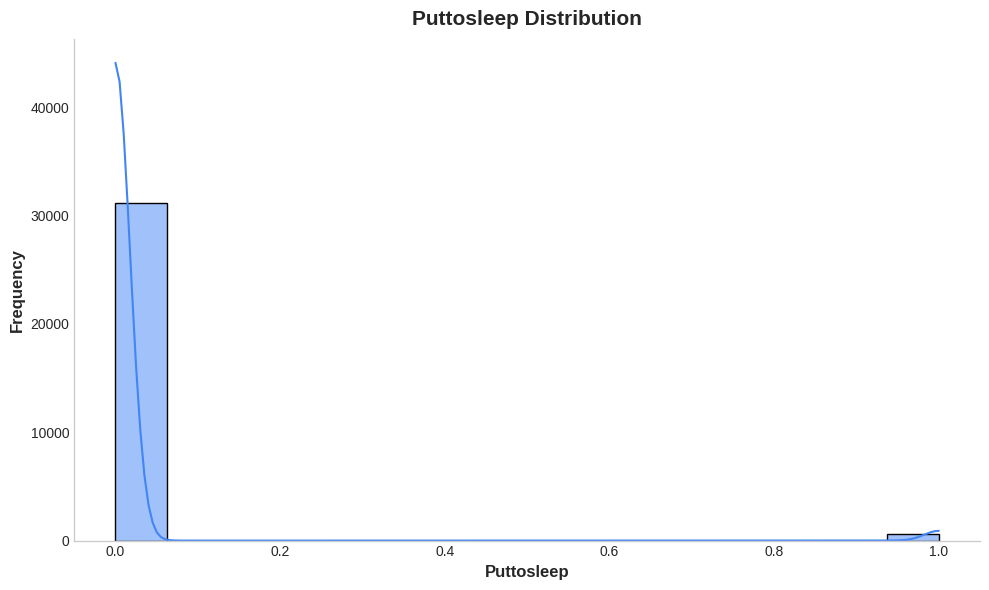

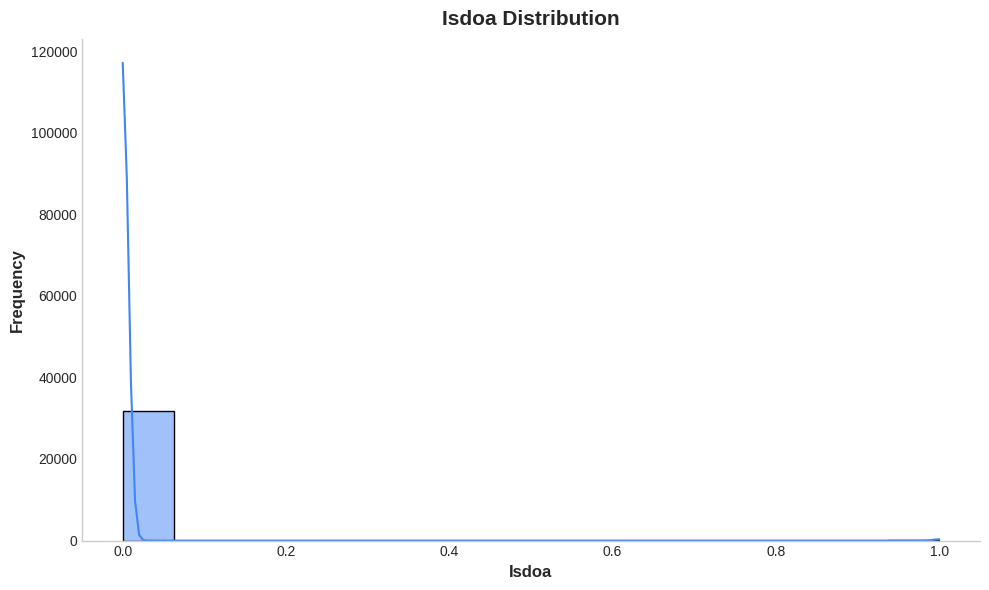

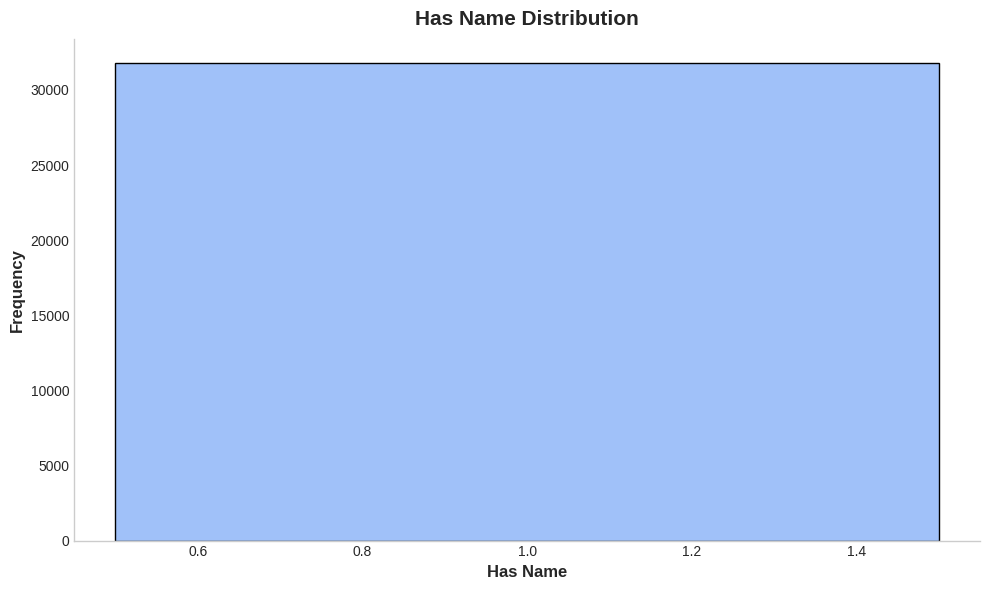

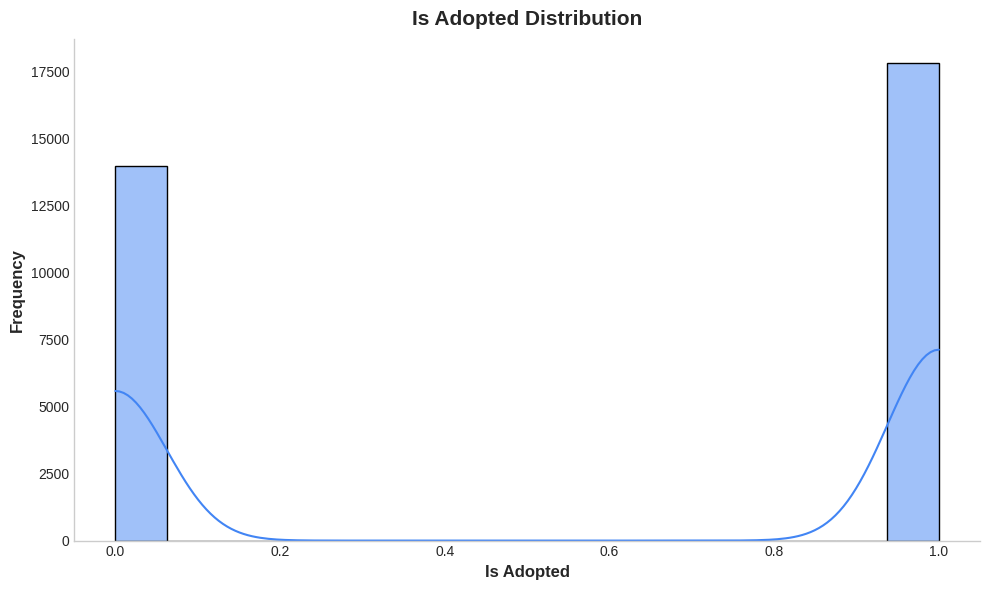

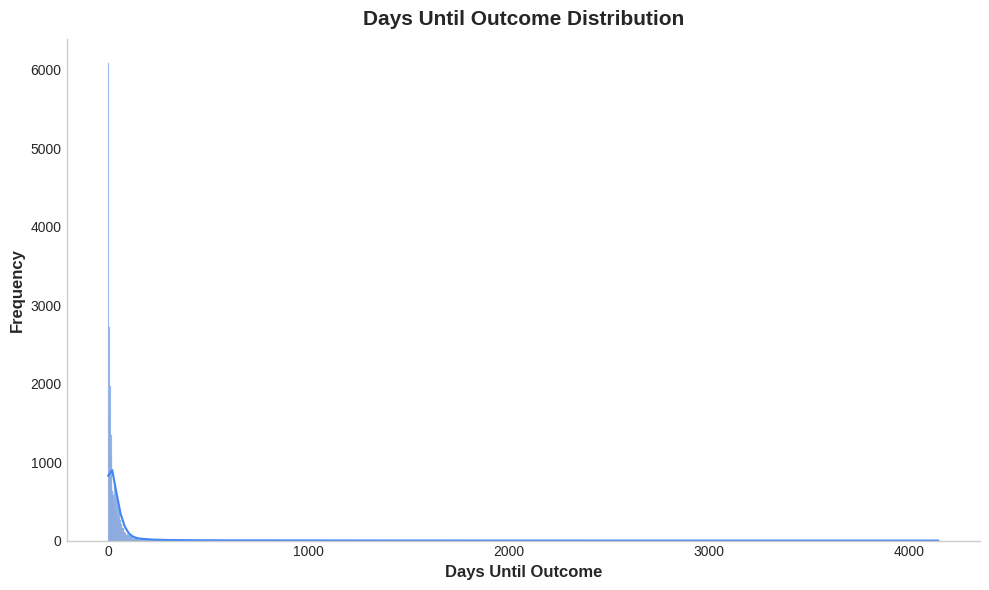

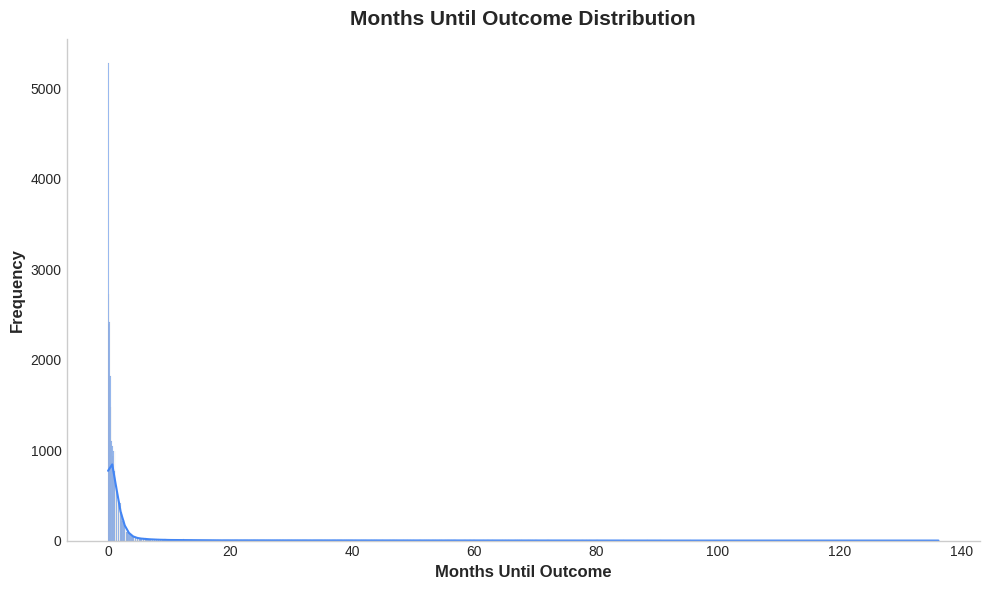

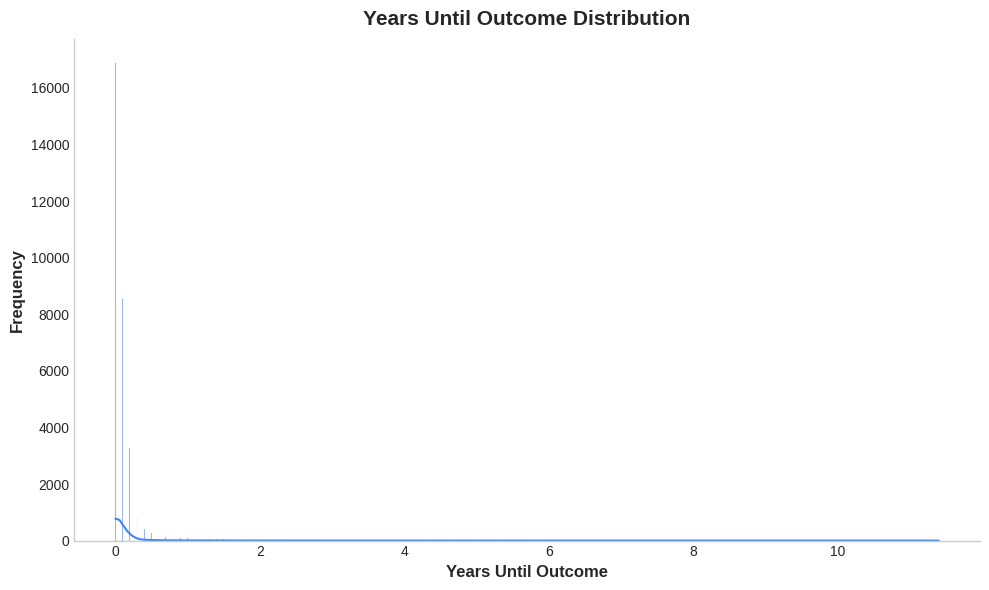

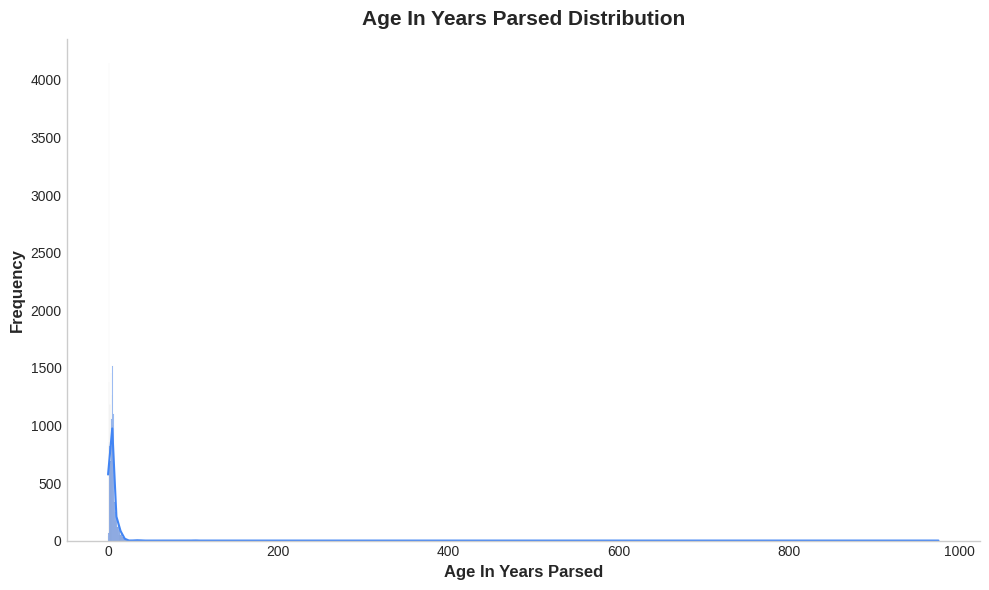

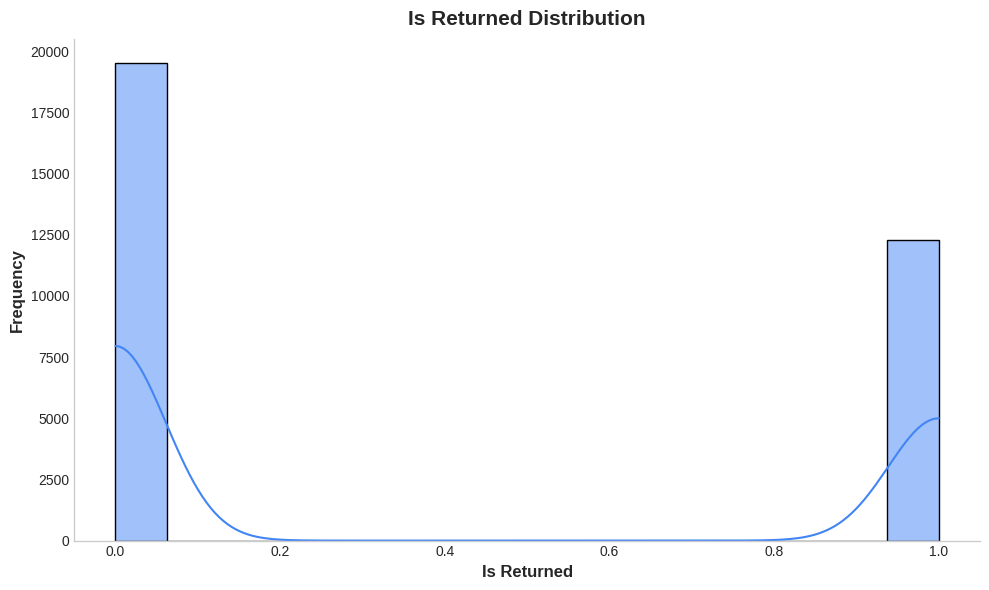

In [ ]:
#@title { vertical-output: true }

print("\n--- Generating High-Level Statistical Summary of the Dataset ---")

eda_bt.display_summary_statistics()

# Look at distribution
for column in eda_bt.df.columns:
  eda_bt.plot_categorical_distribution(column)

for column in eda_bt.df.columns:
  eda_bt.plot_distribution(column)

### EDA: bivariate analysis
________
### Descriptive insights:
1. `Has name`: all pets have names
2. `Sex`: does not have neutered/spayed status
3. `Intake reasons`: interesting that they have a "Born in shelter" option. Consistent with  Long beach those who had a previous owner has a higher adoption rate.
4. `Intake condition`: does not exist

TODO: look at practical significance, not just statistical significance, since we have a large sample size

<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


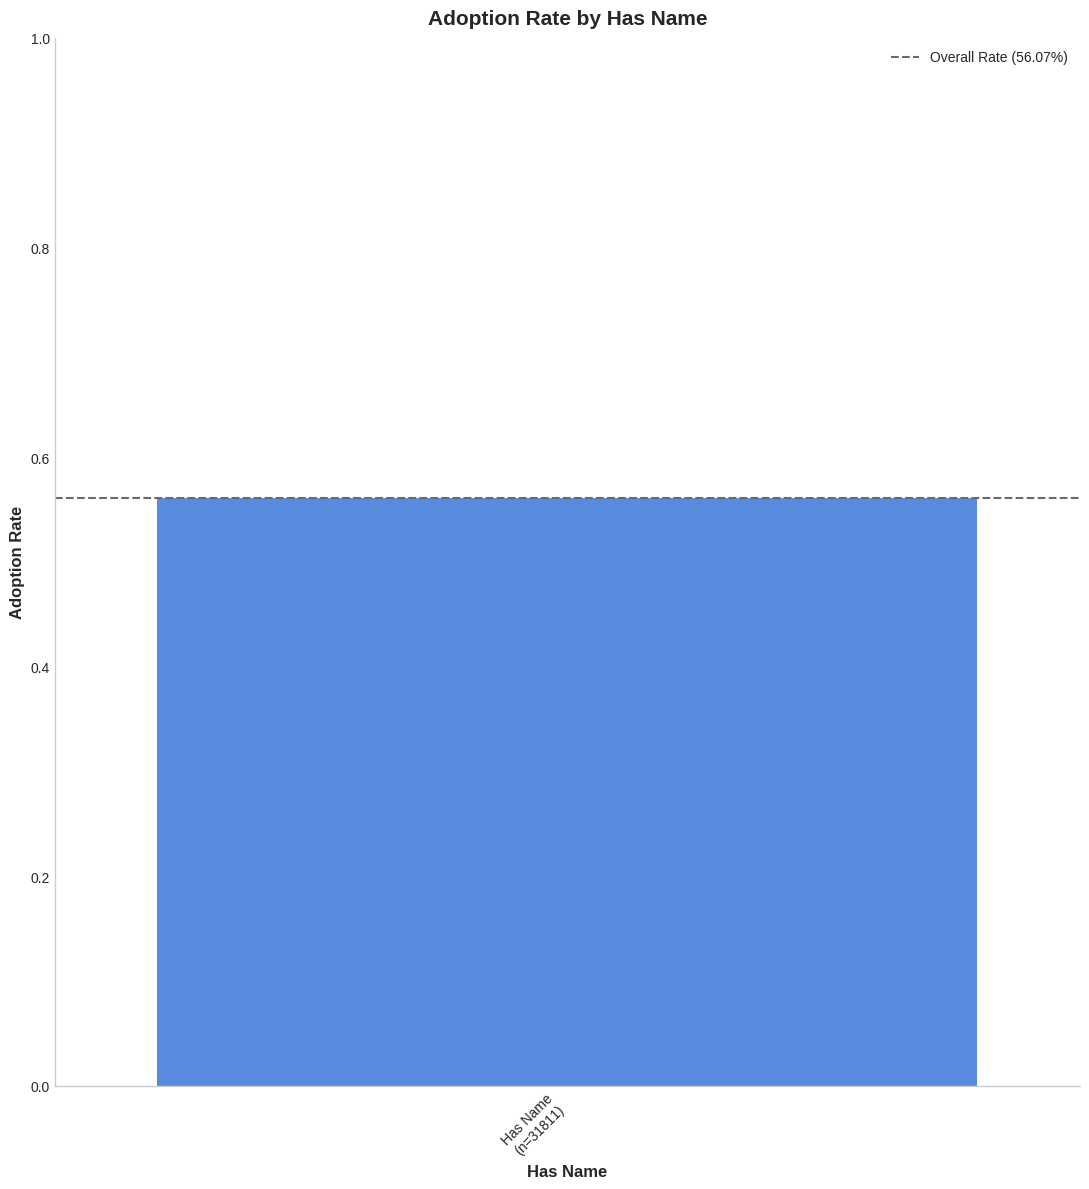

<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


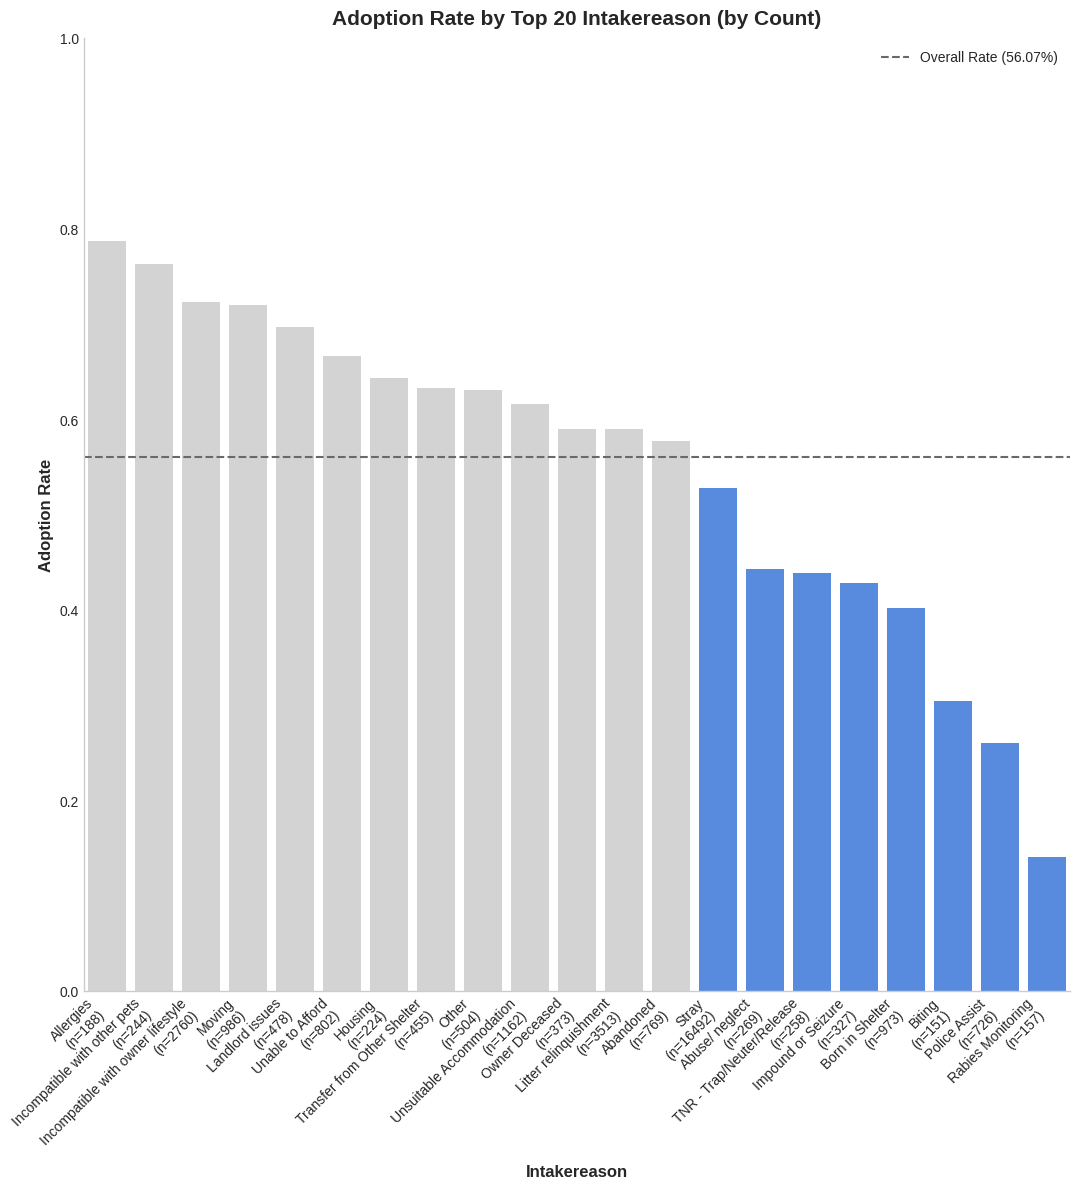

<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


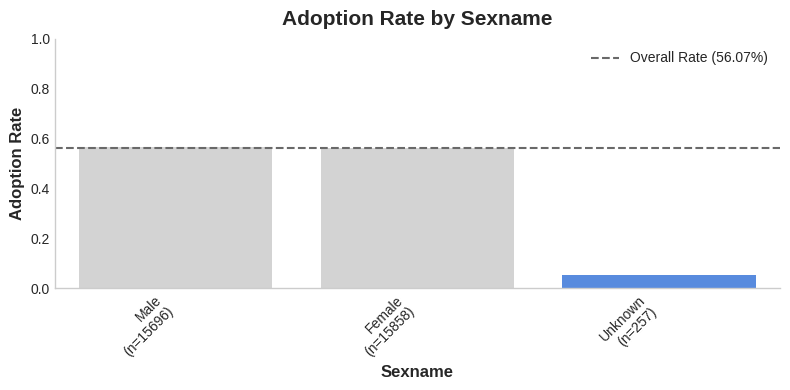

<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


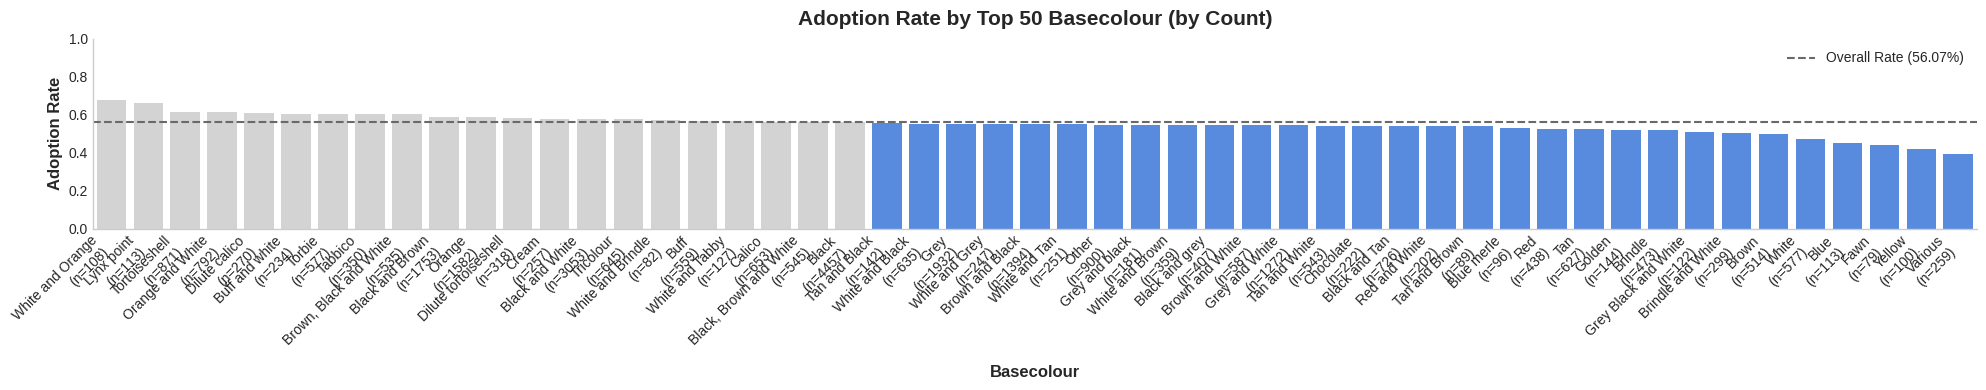

<ipython-input-5-2500007134>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=plot_data_rates.index.astype(str), y=plot_data_rates.values, palette=bar_palette, order=plot_data_rates.index.astype(str))
<ipython-input-5-2500007134>:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', fontsize=tick_label_fontsize)


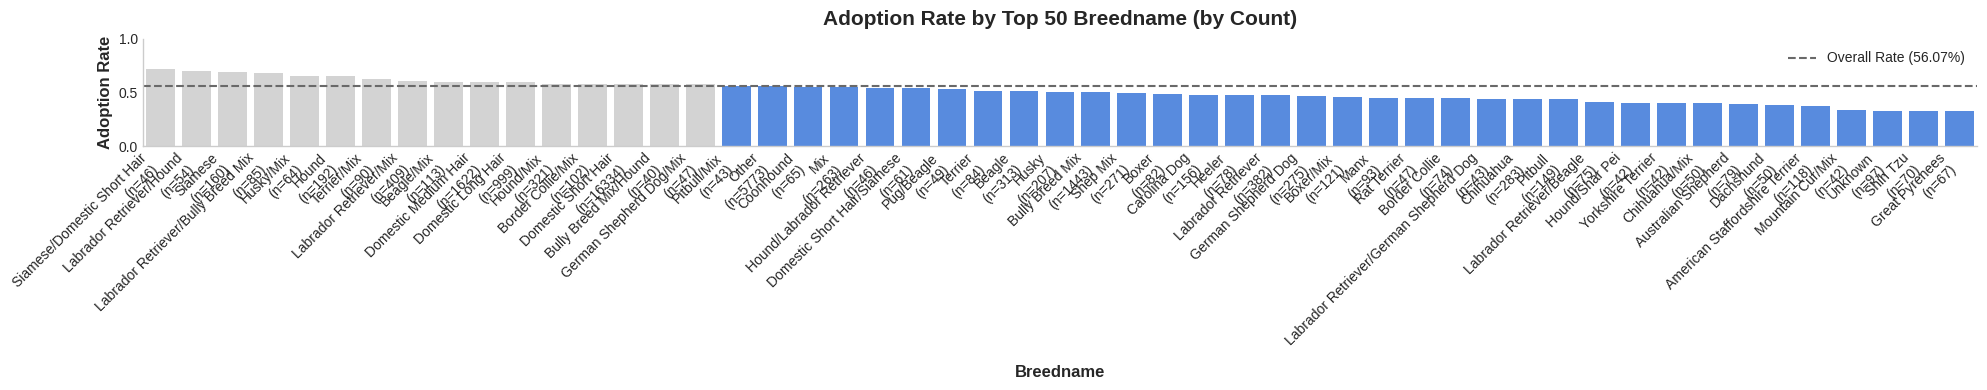

<Figure size 1200x800 with 0 Axes>

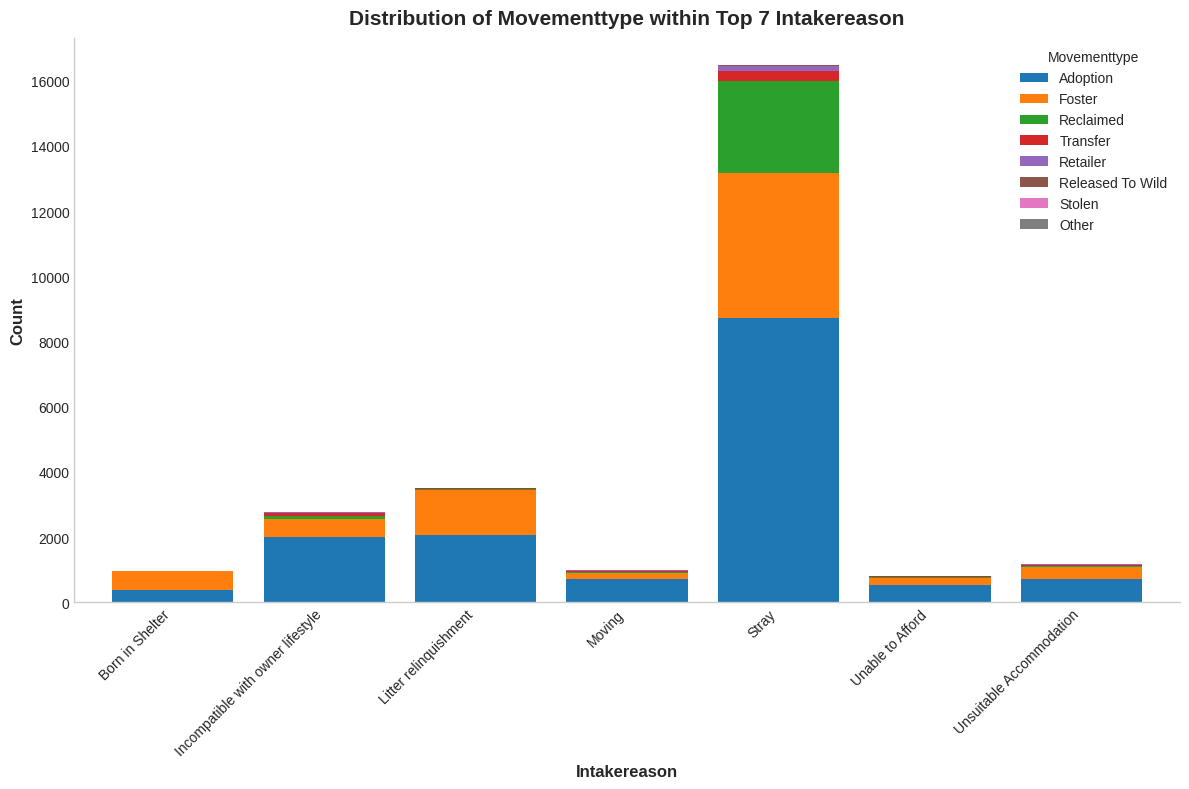


--- Analysis: 'age_in_years_parsed' vs. 'is_adopted' ---

--- ANOVA F-test Results ---
Null Hypothesis (H₀): The mean of 'age_in_years_parsed' is the same across all categories of 'is_adopted'.
F-statistic: 139.2428
P-value: 0.0000

--- Conclusion ---
P-value is less than 0.05. We reject the null hypothesis.
Conclusion: There IS a statistically significant difference in 'age_in_years_parsed' across 'is_adopted' groups.

--- Visualization ---


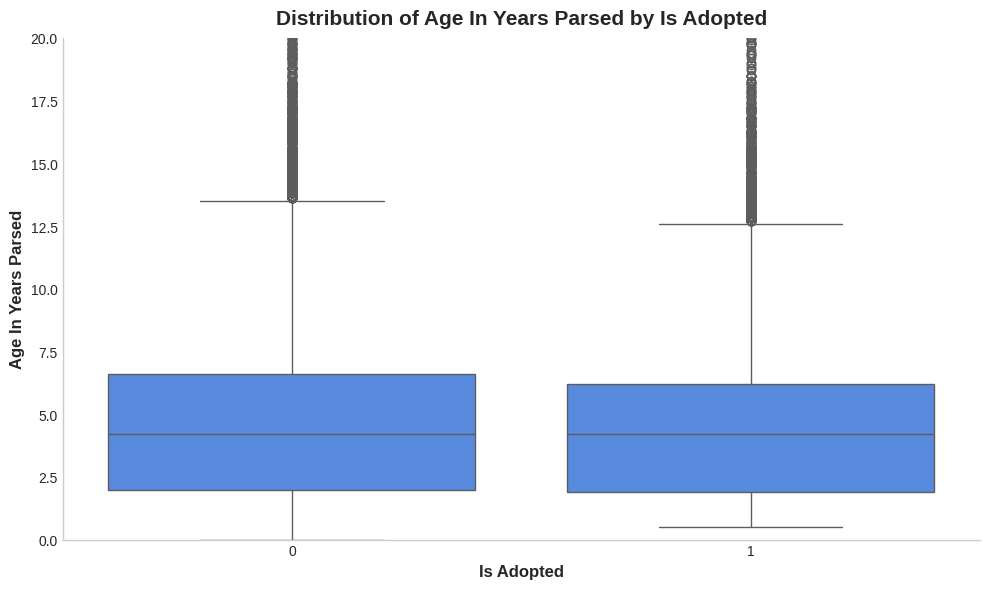

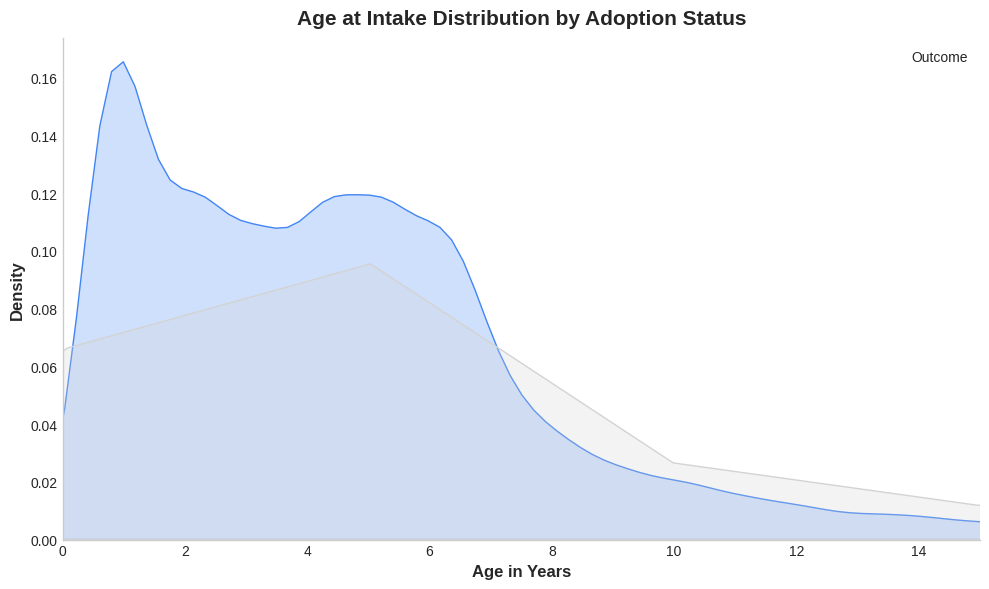

In [ ]:
#@title { vertical-output: true }

eda_bt.plot_feature_vs_outcome(
    feature_column='has_name',
    outcome_column= col_map["outcome_type"],
    positive_outcome_value='Adoption',
    xtick_label_map={1: "Has Name", 0: "No Name"},
    deemphasize_if_rate_above_average=True
)

eda_bt.plot_feature_vs_outcome(
    feature_column='intakereason',
    outcome_column= col_map["outcome_type"],
    positive_outcome_value='Adoption',
    top_n_feature_categories=20,
    deemphasize_if_rate_above_average=True
)

eda_bt.plot_feature_vs_outcome(
    feature_column= col_map["sex"],
    outcome_column= col_map["outcome_type"],
    positive_outcome_value='Adoption',
    figure_size=(8,4),
    deemphasize_if_rate_above_average=True
)

eda_bt.plot_feature_vs_outcome(
    feature_column= "basecolour",
    outcome_column= col_map["outcome_type"],
    positive_outcome_value='Adoption',
    figure_size=(20,4),
    top_n_feature_categories=50,
    deemphasize_if_rate_above_average=True
)

eda_bt.plot_feature_vs_outcome(
    feature_column= "breedname",
    outcome_column= col_map["outcome_type"],
    positive_outcome_value='Adoption',
    figure_size=(20,4),
    top_n_feature_categories=50,
    deemphasize_if_rate_above_average=True
)

eda_bt.plot_bivariate_categorical("intakereason", "movementtype", 7, 7)

# Test if 'age_in_years_parsed' is a good predictor for 'is_adopted'
eda_bt.test_and_plot_numeric_vs_categorical(
  num_col='age_in_years_parsed',
  cat_col='is_adopted'
)

eda_bt.plot_age_distribution_by_outcome('age_in_years_parsed', xlim_max = 15)

---
### **Hypothesis Testing: Association Between Predictors and Adoption**
Use Chi-squared test to determine if there is a statistically significant association between key categorical features and the adoption outcome; a low p-value (<0.05) suggests an association.

1. `intakereason` seems to be one of the higher correlated items with is_adopted. For example, those that had a previous owner (derived from intake reason: "incompatible with owner lifestyle", "Moving", "Landlord issues", "Unable to Afford", "Unsuitable Accomodation", etc., have a condierably higher adoption rate (60%+) than stray (53%)  (TODO: feature engineer `had_previous_owner`?))



--- Generating Association Heatmap for Categorical Variables ---
Calculating Cramér's V for columns: ['is_adopted', 'intakereason', 'sexname', 'basecolour', 'breedname']


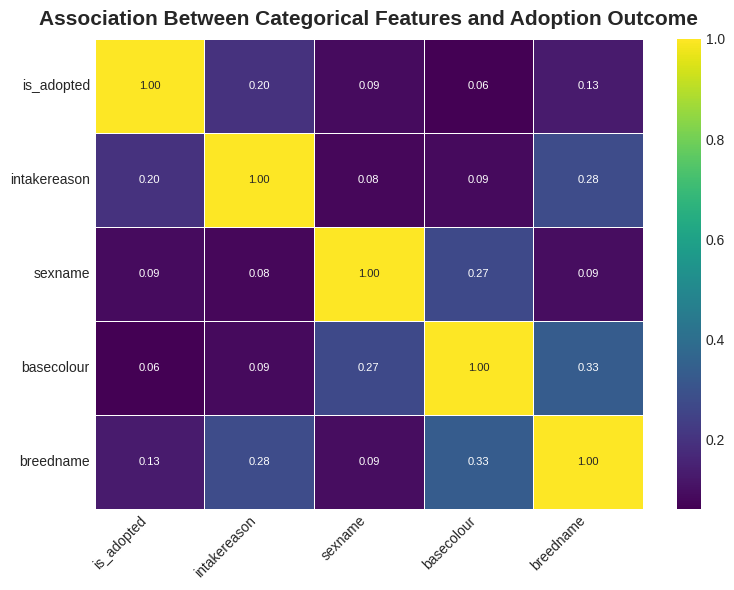


--- Association Test: 'intakereason' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted                            0     1  Total count pct_adopted
intakereason                                                          
Incompatible with owner lifestyle   765  1995         2760       72.3%
Moving                              276   710          986       72.0%
Landlord issues                     145   333          478       69.7%
Unable to Afford                    268   534          802       66.6%
Transfer from Other Shelter         167   288          455       63.3%
Unsuitable Accommodation            446   716         1162       61.6%
Owner Deceased                      153   220          373       59.0%
Litter relinquishment              1443  2070         3513       58.9%
Other                               603   864         1467       58.9%
Abandoned                           325   444          769       57.7%
Stray                             

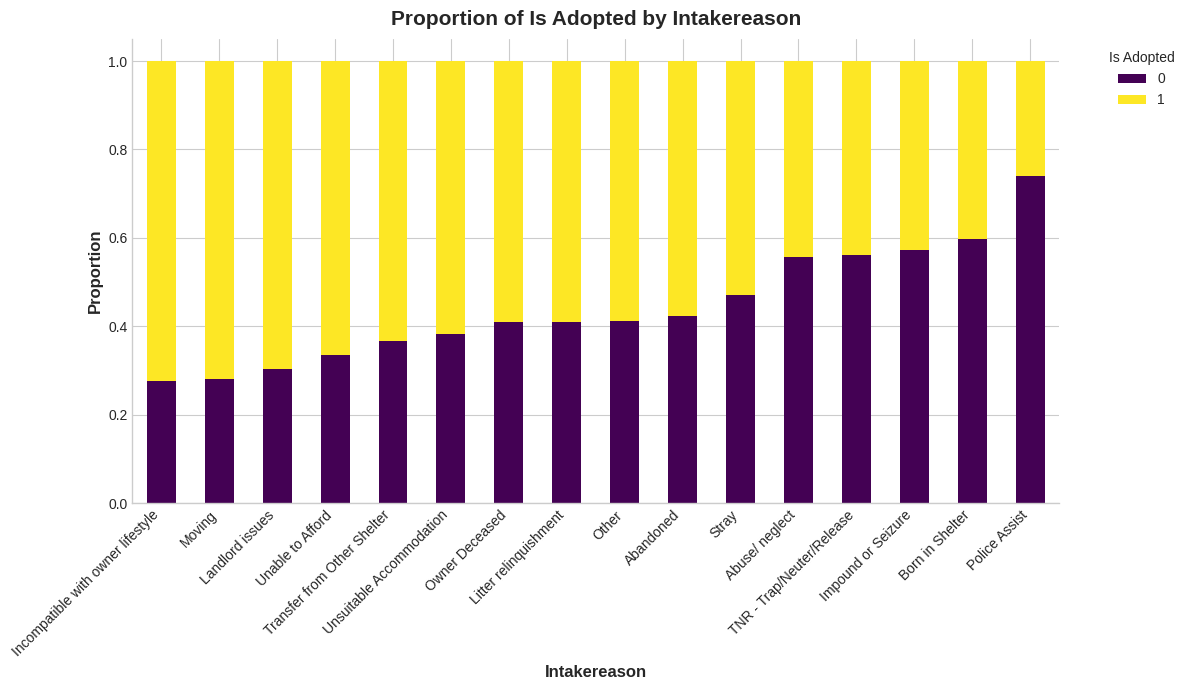


--- Association Test: 'sexname' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted     0     1  Total count pct_adopted
sexname                                        
Male        6817  8879        15696       56.6%
Female      6916  8942        15858       56.4%
Unknown      243    14          257        5.4%

--- Chi-Squared Test Results ---
Null Hypothesis (H₀): 'sexname' and 'is_adopted' are independent (no association).
Chi-Squared Statistic: 269.6085
P-value: 0.0000

--- Conclusion ---
P-value (0.0000) is less than the significance level (0.05).
Conclusion: We reject the null hypothesis. There IS a statistically significant association between 'sexname' and 'is_adopted'.

--- Visualization ---


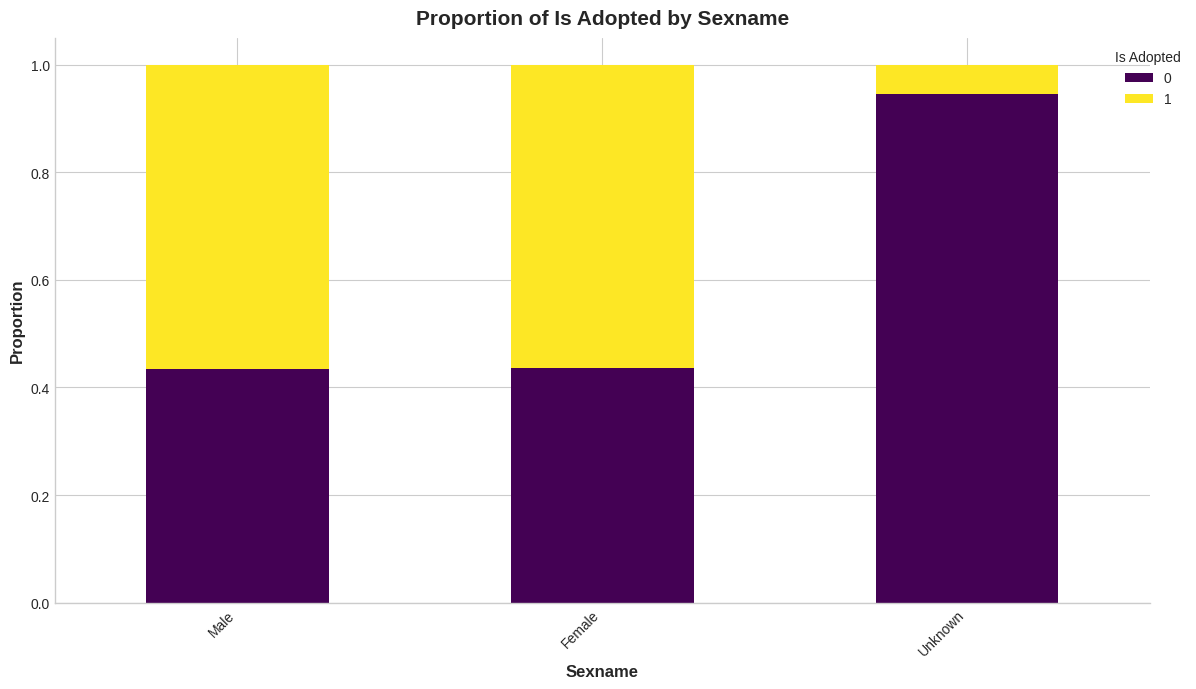


--- Association Test: 'basecolour' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted           0     1  Total count pct_adopted
basecolour                                           
Tortoiseshell      335   536          871       61.5%
Orange and White   305   487          792       61.5%
Black and Brown    720  1033         1753       58.9%
Orange             652   930         1582       58.8%
Black and White   1287  1766         3053       57.8%
Tricolour          273   372          645       57.7%
Calico             285   368          653       56.4%
Black             1955  2502         4457       56.1%
White and Black    284   351          635       55.3%
Grey               867  1065         1932       55.1%
Brown and Black    627   767         1394       55.0%
Other             4907  5925        10832       54.7%
Brown and White    267   320          587       54.5%
Grey and White     580   692         1272       54.4%
Black and Tan      334  

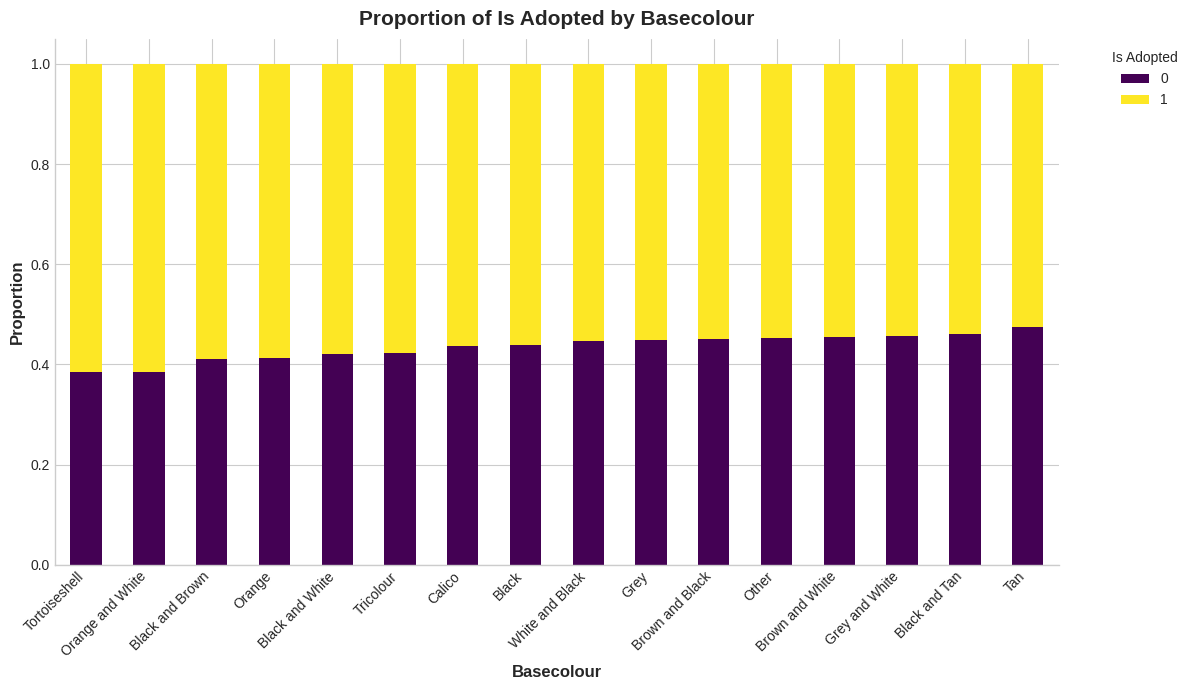


--- Association Test: 'breedname' vs. 'is_adopted' ---

Contingency Table (Observed Counts & Adoption Rate):

is_adopted                 0     1  Total count pct_adopted
breedname                                                  
Siamese                   50   110          160       68.8%
Hound                     66   126          192       65.6%
Labrador Retriever/Mix   162   247          409       60.4%
Domestic Medium Hair     653   969         1622       59.7%
Domestic Long Hair       404   595          999       59.6%
Hound/Mix                135   186          321       57.9%
Domestic Short Hair     6903  9431        16334       57.7%
Mix                      118   145          263       55.1%
Other                   3871  4465         8336       53.6%
Beagle                   153   160          313       51.1%
Husky                    102   105          207       50.7%
Bully Breed Mix          717   726         1443       50.3%
Shep Mix                 136   135          271  

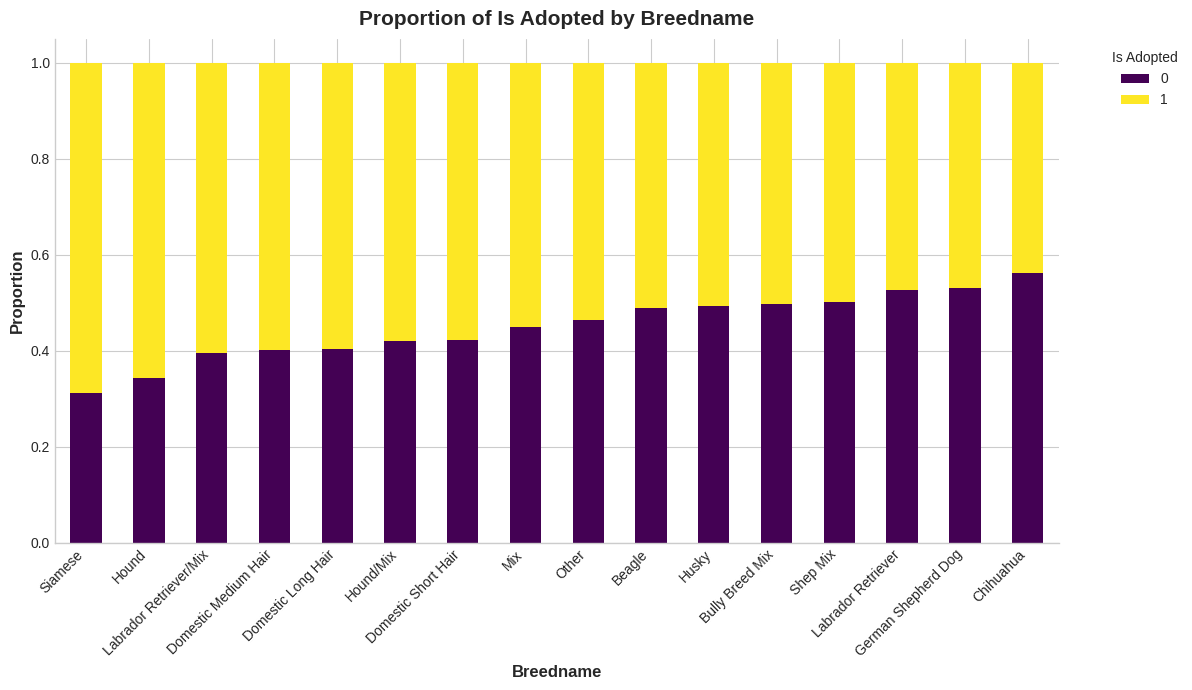

In [ ]:
#@title { vertical-output: true }

if 'df_bloomington_featured' in locals() and not df_bloomington_featured.empty:

    # --- Association heatmap for categorical features and outcome ---
    print("\n--- Generating Association Heatmap for Categorical Variables ---")

    # Select the categorical features and the binary outcome to analyze
    categorical_features_for_heatmap = [
        'is_adopted',
        'intakereason',
        col_map['sex'],
        col_map['primary_color'],
        'breedname',
    ]

    # Ensure all selected columns are in the df before calling the plot
    existing_cols_for_heatmap = [col for col in categorical_features_for_heatmap if col in eda_bt.df.columns]

    if len(existing_cols_for_heatmap) > 1:
        eda_bt.plot_categorical_association_heatmap(
            cat_columns=existing_cols_for_heatmap,
            title="Association Between Categorical Features and Adoption Outcome"
        )
    else:
        print("Not enough categorical columns found to generate an association heatmap.")


    # List of categorical features to test against the adoption outcome
    categorical_predictors_to_test = [
        'intakereason',
        col_map['sex'],
        col_map['primary_color'],
        'breedname',
    ]

    target_variable = 'is_adopted'

    for predictor in categorical_predictors_to_test:
        # Check if both predictor and target exist in the df before testing
        if predictor in eda_bt.df.columns and target_variable in eda_bt.df.columns:
            eda_bt.test_and_plot_categorical_association(
                cat_predictor=predictor,
                cat_target=target_variable,
                top_n_predictor=15 # Show top 15 most frequent categories, group rest as 'Other'
            )
        else:
            print(f"\nSkipping test for '{predictor}': column not found in the DataFrame.")

else:
    print("DataFrame `df_shelter_featured` not available for analysis.")

Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.


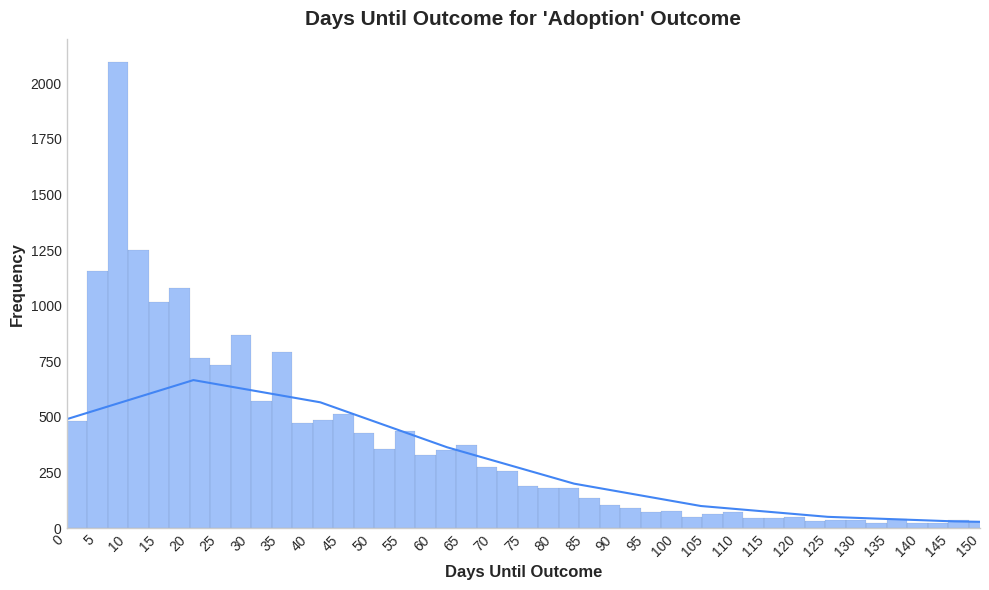

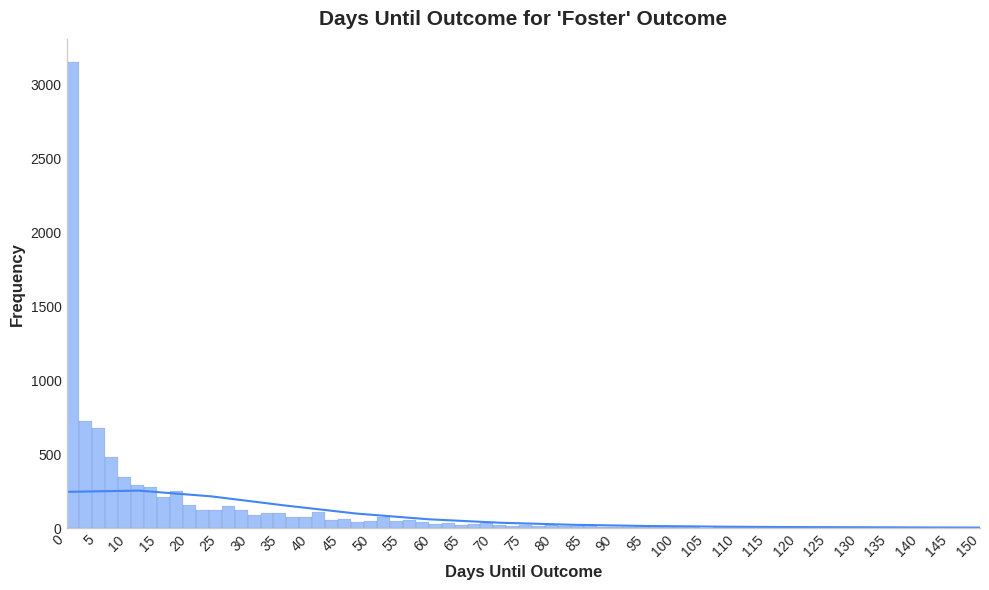

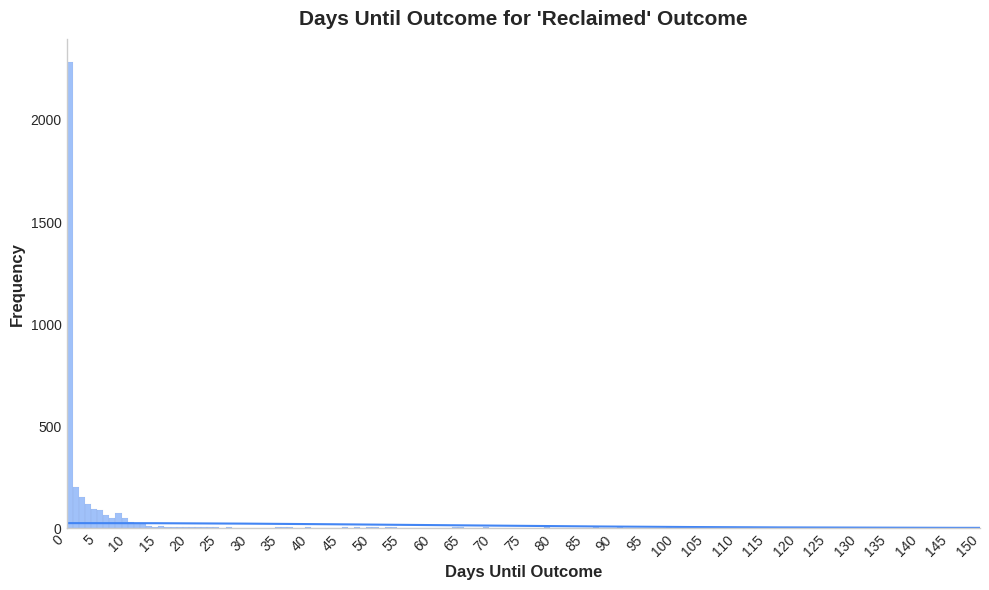

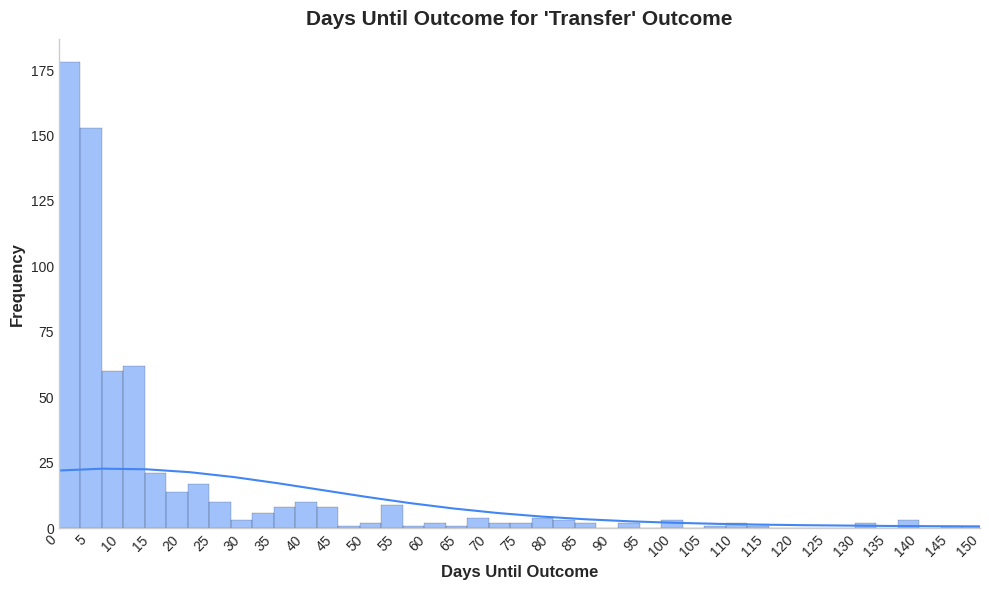

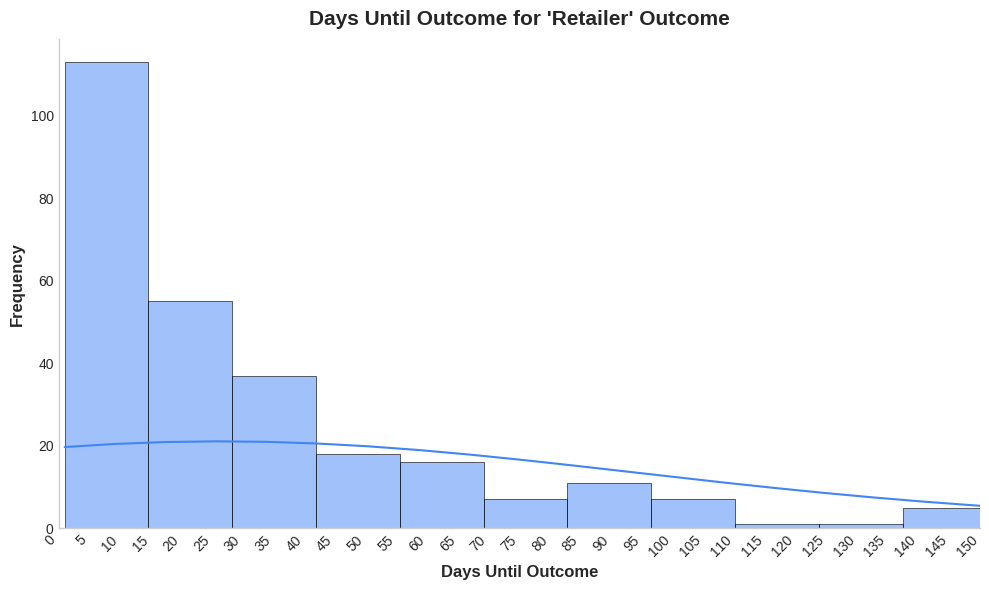

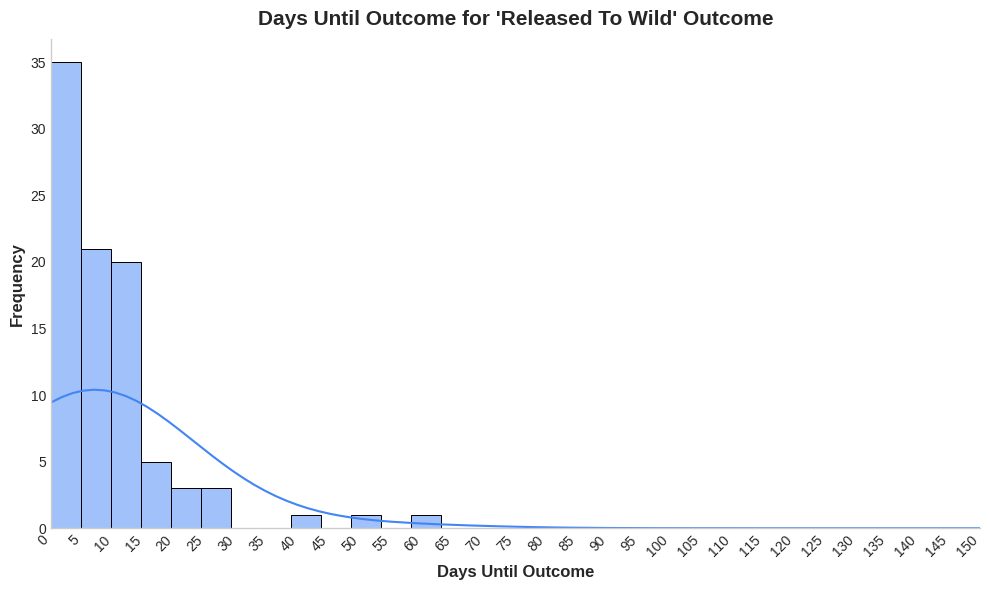

In [ ]:
#@title { vertical-output: true }
# For readability, focusing on the top 6 most frequent movement types
top_movement_types = df_bloomington_featured['movementtype'].value_counts().nlargest(6).index

# --- Loop through each movement type and create a separate plot ---
for m_type in top_movement_types:

    # 1. Filter the df for the current movement type
    df_subset = df_bloomington_featured[df_bloomington_featured['movementtype'] == m_type]

    # 2. Create a temporary EDA analyzer instance for this subset
    eda_subset_analyzer = ExploratoryDataAnalyzer(df_subset)

    # 3. Call plot_distribution method
    eda_subset_analyzer.plot_distribution(
        column='days_until_outcome',
        title_suffix=f"for '{m_type}' Outcome",
        xtick_interval = 5,
        xlim=(0, 150)
    )

Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.
Note: X-axis ticks for 'days_until_outcome' set to intervals of 5.


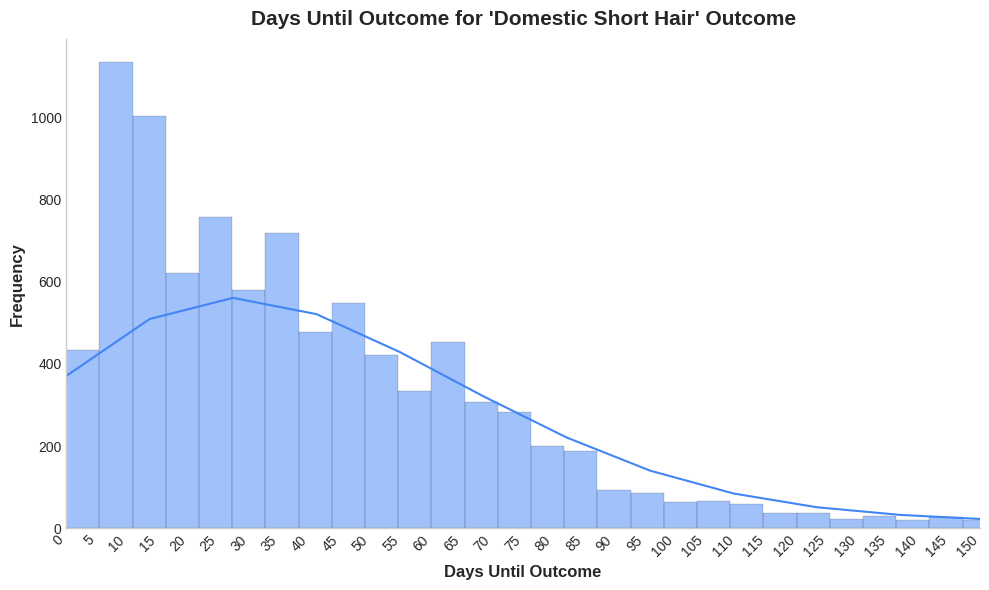

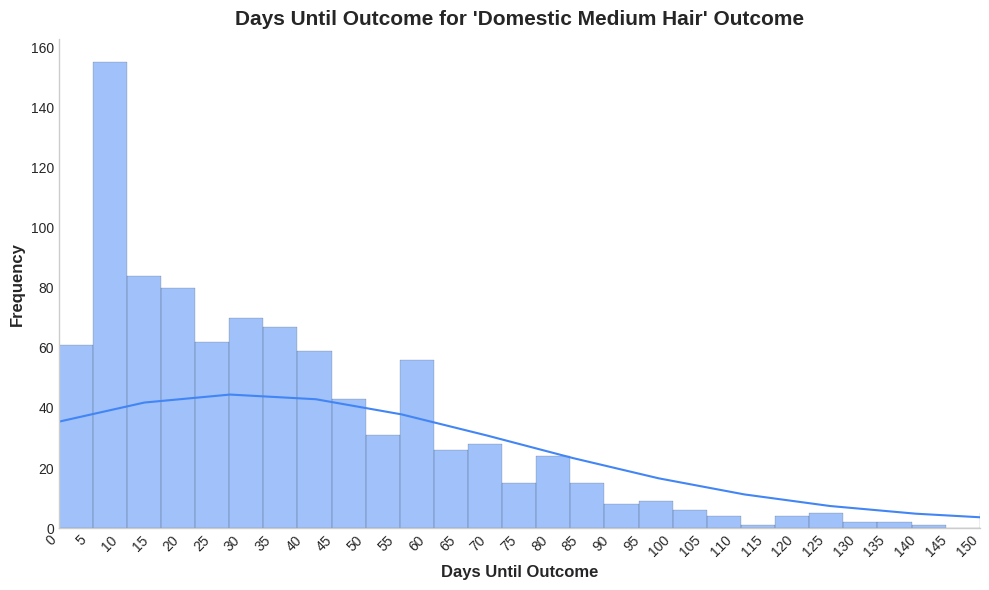

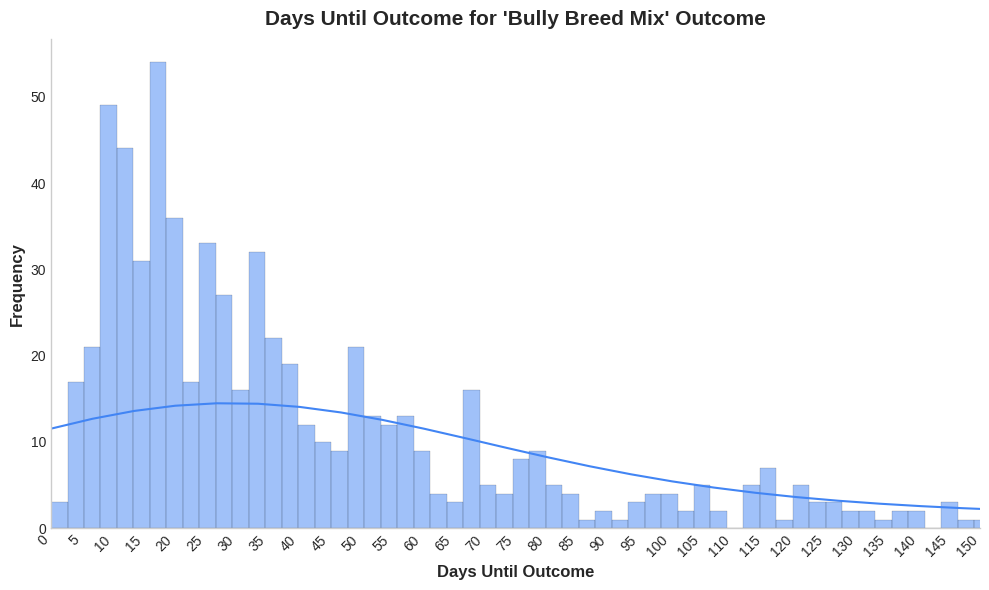

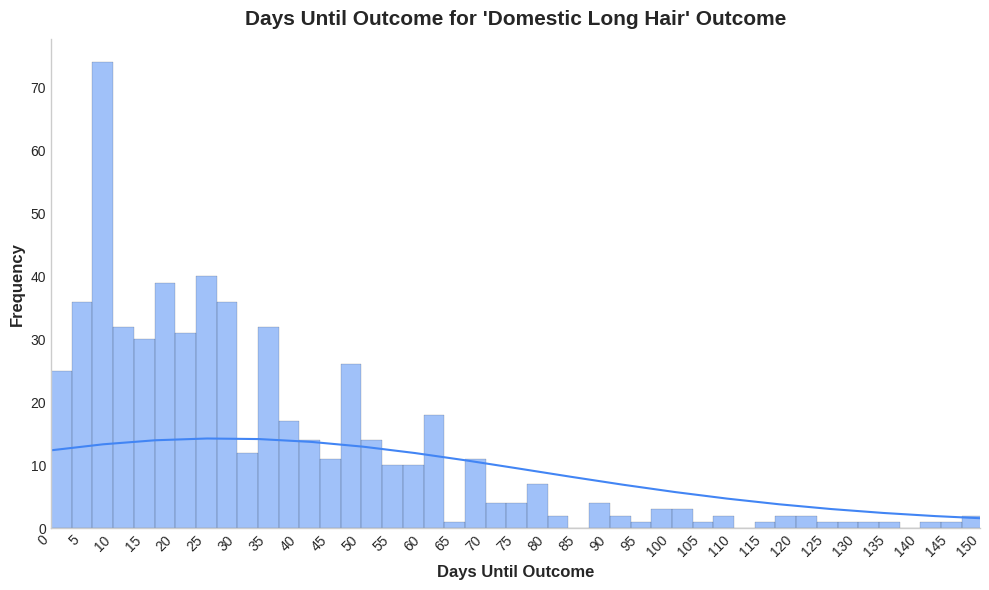

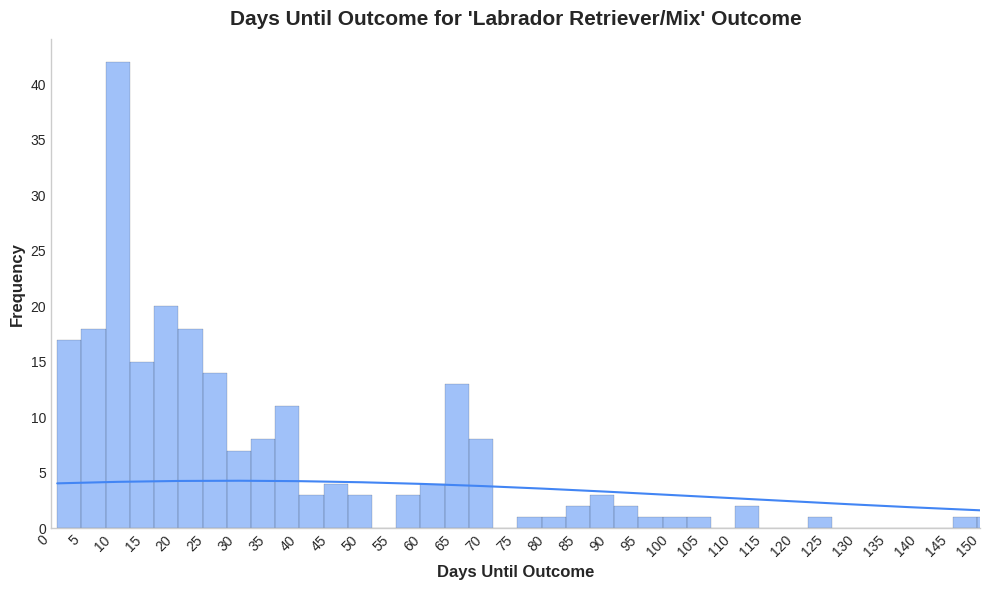

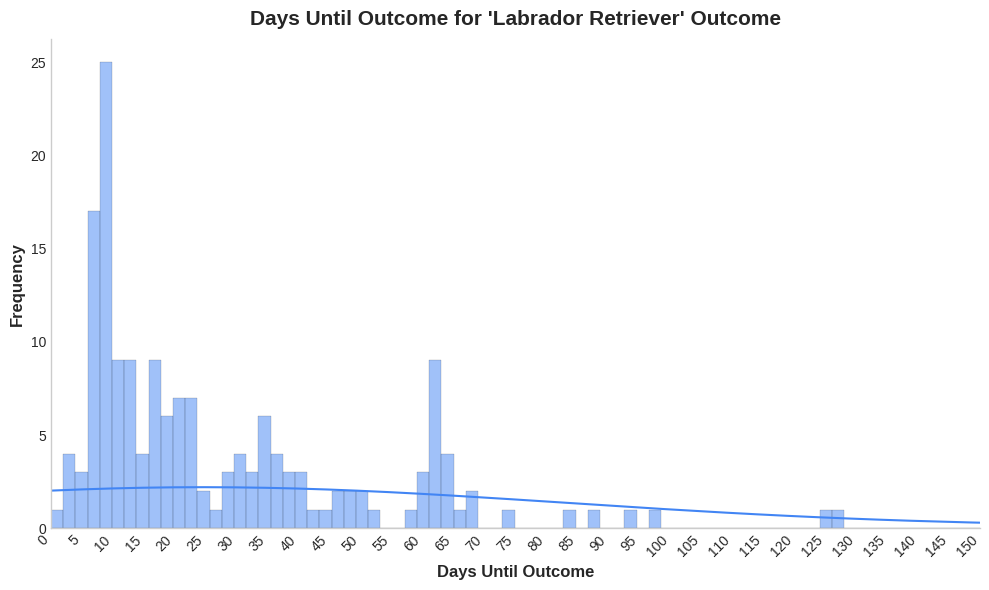

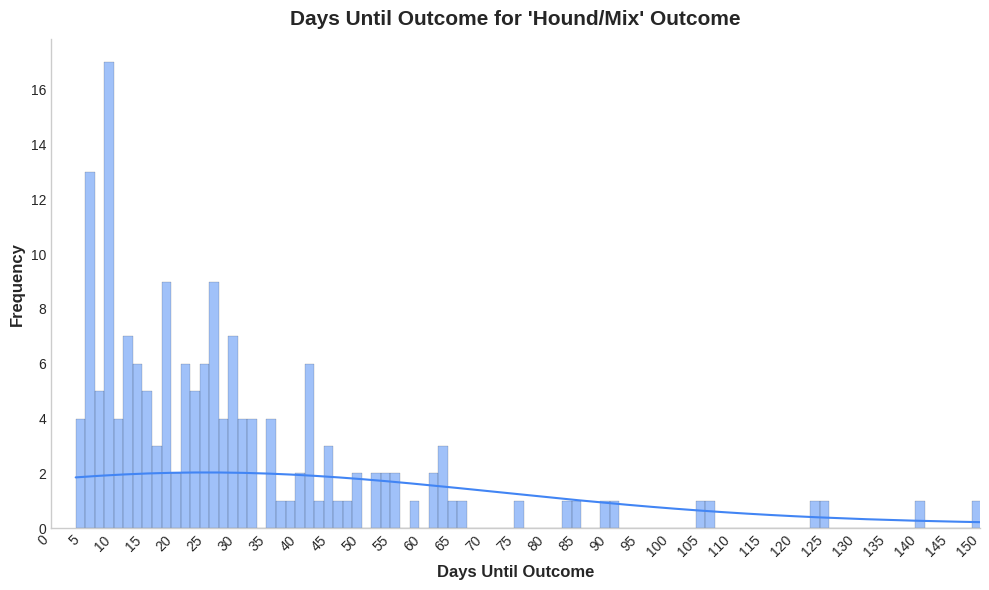

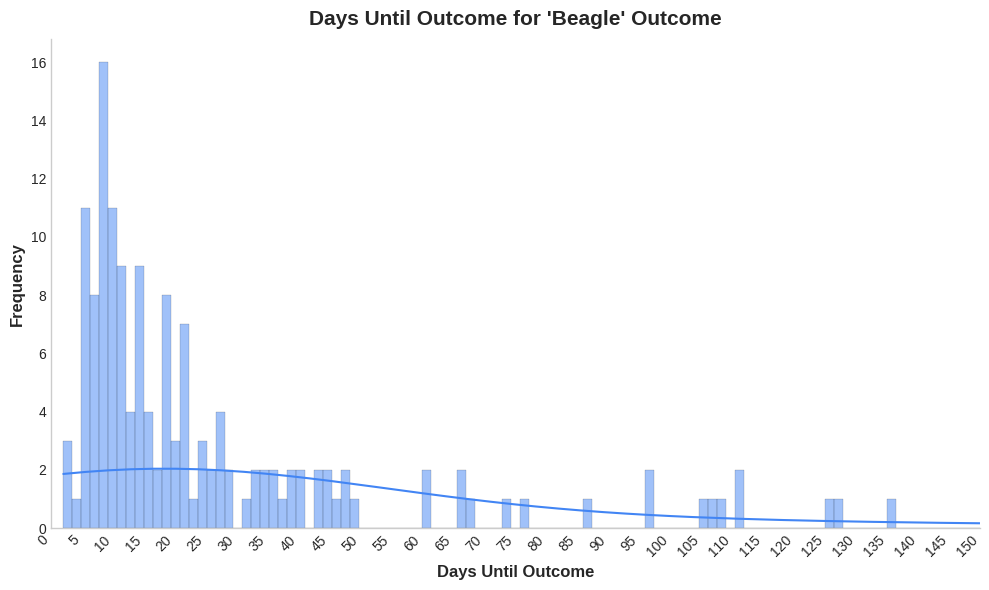

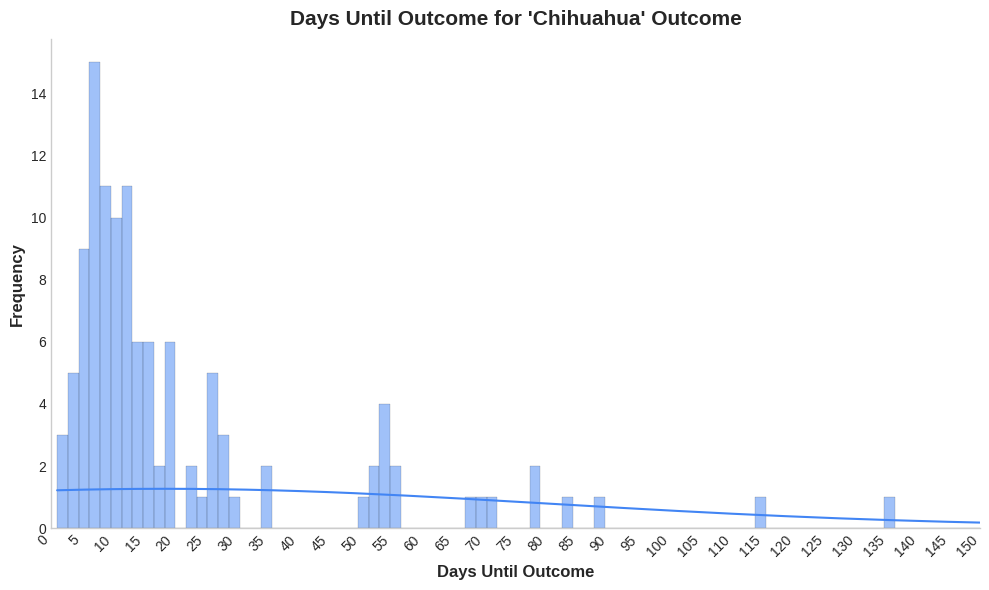

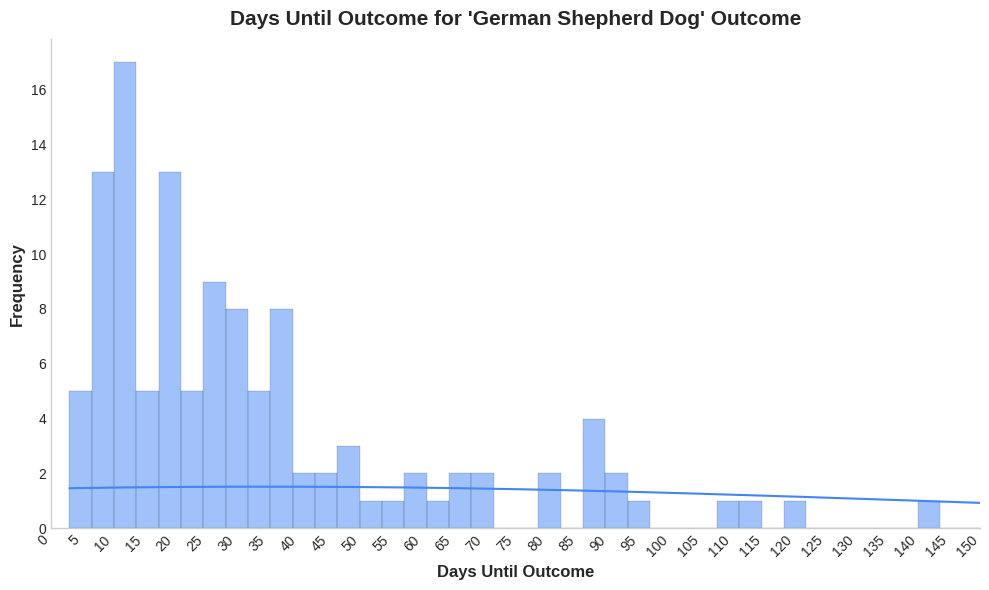

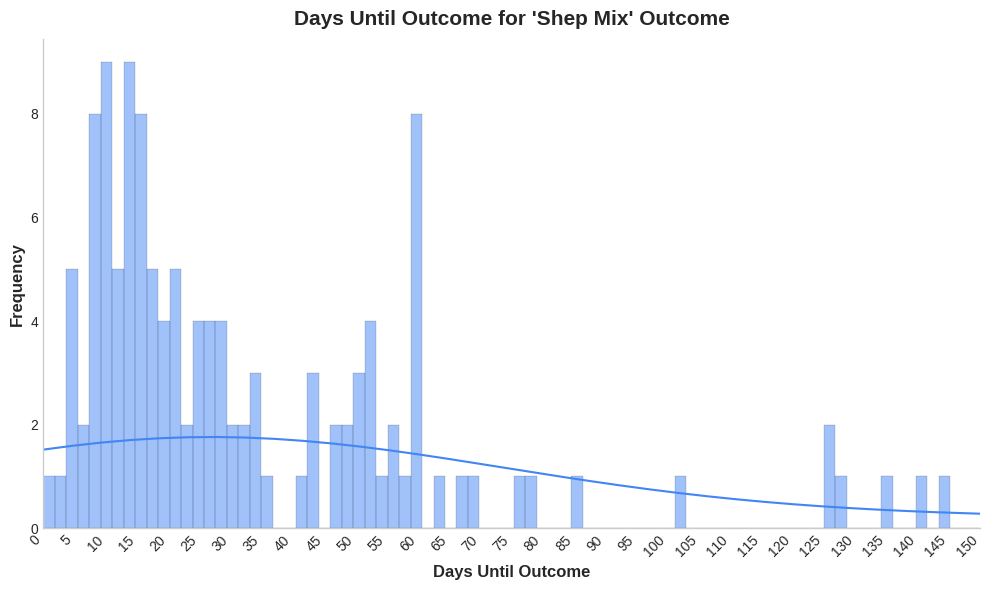

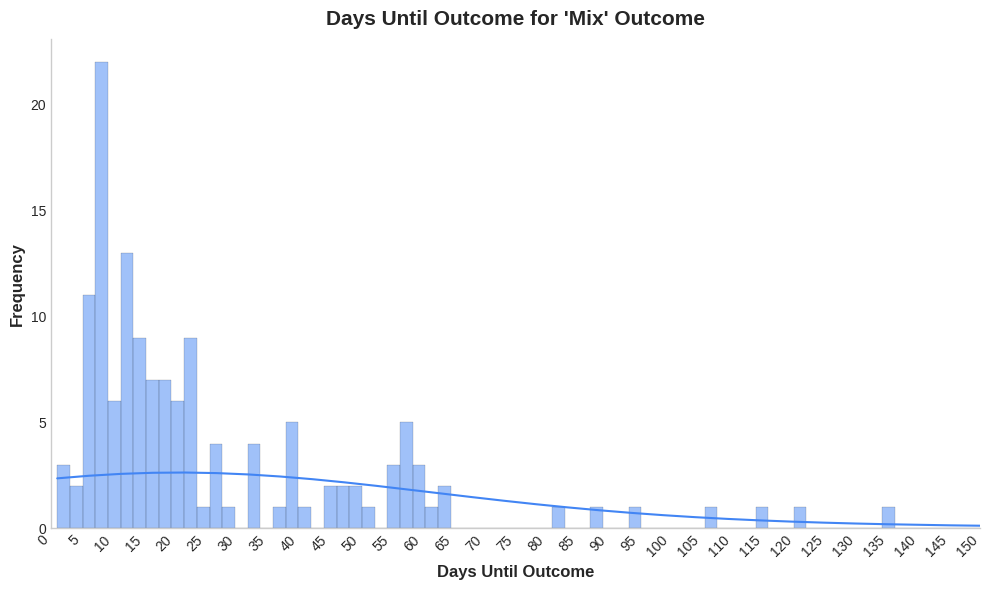

In [ ]:
#@title { vertical-output: true }
# For readability, let's focus on the top 12 most frequent breeds
top_breed_types = df_bloomington_featured['breedname'].value_counts().nlargest(12).index

# --- Loop through each movement type and create a separate plot ---
for breed in top_breed_types:

    # 1. Filter the DataFrame for the current movement type
    df_subset = df_bloomington_featured[(df_bloomington_featured['breedname'] == breed) & (df_bloomington_featured['movementtype'] == 'Adoption')]

    # 2. Create a temporary EDA analyzer instance for this subset
    eda_subset_analyzer = ExploratoryDataAnalyzer(df_subset)

    # 3. Call plot_distribution method
    eda_subset_analyzer.plot_distribution(
        column='days_until_outcome',
        title_suffix=f"for '{breed}' Outcome",
        xtick_interval = 5,
        xlim=(0, 150),
        bins = 500
    )

## Feature Selection
___
`intakereason`, `animaltype`, `age`, `basecolor`, `days_until_outcome`, `is_returned`, `sexname`

Unique to this dataset: `breed`